# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from scipy import stats
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score , classification_report , accuracy_score , confusion_matrix 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
import catboost as cb
import tensorflow as tf
from keras import callbacks
from keras.layers import Dense, Input, Dropout, Normalization, BatchNormalization
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
tf.random.set_seed(42)
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV

2024-10-15 18:48:17.616023: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Cleaning

## Load the dataset
This dataset is taken from the Kaggle page 'https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package/data'.

This dataset comprises about 10 years of daily weather observations from numerous locations across Australia. The observations were gathered from a multitude of weather stations. You can access daily observations from 'http://www.bom.gov.au/climate/data'.

In [2]:
# Load the dataset into a dataframe
df = pd.read_csv('weatherAUS.csv')

## Information about the data
Let's see the first 5 rows of the dataset.

In [3]:
df.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN     16.9     21.8         No   
1       1010.6       1007.8       NaN       NaN     17.2     24.3         No   
2       1007.6       1008.7       NaN       2.0     21.0     23.2         No   
3       1017.6       1012.8       NaN       NaN     18.1     26.5         No   
4       1010.8       1006.0       7.0       8.0     17.8     29.7         No   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 23 columns]

Now, we can plot the features of this dataset. In particular, we can understand that the target column is **RainTomorrow**. So, in the *Machine Learning* part we are going to predict this column.

In [4]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

We can print the shape of the dataset

In [5]:
number_of_rows = df.shape[0]
number_of_features = df.shape[1]
print(f'The dataset contains {number_of_rows} rows')
print(f'The dataset contains {number_of_features} columns')

The dataset contains 145460 rows
The dataset contains 23 columns


## Data Cleaning
We can now focus our attention on the data cleaning part in order to discover:
- **NaN values**
- **Outliers**
- **Multicollinearity Problem**

Firstly, we can plot the number of unique values.

In [6]:
for col in df.columns:
    unique_values = df[col].unique()
    print(f"Column '{col}' has {len(unique_values)} unique values")

Column 'Date' has 3436 unique values
Column 'Location' has 49 unique values
Column 'MinTemp' has 390 unique values
Column 'MaxTemp' has 506 unique values
Column 'Rainfall' has 682 unique values
Column 'Evaporation' has 359 unique values
Column 'Sunshine' has 146 unique values
Column 'WindGustDir' has 17 unique values
Column 'WindGustSpeed' has 68 unique values
Column 'WindDir9am' has 17 unique values
Column 'WindDir3pm' has 17 unique values
Column 'WindSpeed9am' has 44 unique values
Column 'WindSpeed3pm' has 45 unique values
Column 'Humidity9am' has 102 unique values
Column 'Humidity3pm' has 102 unique values
Column 'Pressure9am' has 547 unique values
Column 'Pressure3pm' has 550 unique values
Column 'Cloud9am' has 11 unique values
Column 'Cloud3pm' has 11 unique values
Column 'Temp9am' has 442 unique values
Column 'Temp3pm' has 503 unique values
Column 'RainToday' has 3 unique values
Column 'RainTomorrow' has 3 unique values


In particular we can see that columns **RainToday** and **RainTomorrow** contains 3 unique values. Probably they are boolean features. Let's see:

In [7]:
for col in ['RainToday', 'RainTomorrow']:
    unique_values = df[col].unique()
    print(f"Column '{col}' has {len(unique_values)} unique values: {unique_values}\n")

Column 'RainToday' has 3 unique values: ['No' 'Yes' nan]

Column 'RainTomorrow' has 3 unique values: ['No' 'Yes' nan]



So, we can convert our columns into boolean $0$ and $1$

In [8]:
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})
df['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0})

Now we can check null values

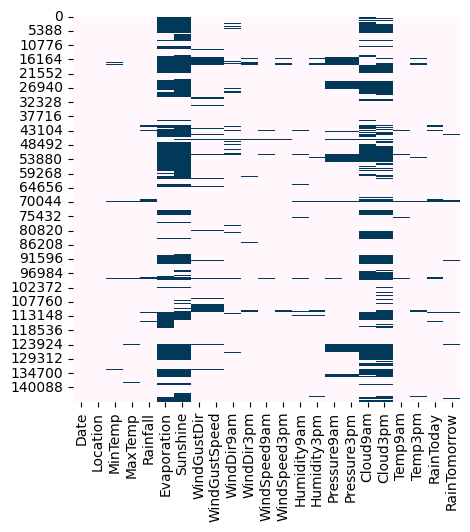

In [9]:
plt.figure(figsize=(5,5))
sns.heatmap(df.isnull(), cbar=False, cmap='PuBu')
plt.show()

From this plot we can understand that columns **Evaporation**, **Sunshine**, **Pressure3pm**, **Pressure9am**, **Cloud9am** and **Cloud3pm** contain a lot of NaN values. Other columns also contain them but in a smaller percentage.

Let's see the percentage of null values for each column.

In [10]:
# create a table with data missing 
missing_values = df.isnull().sum() # missing values

percent_missing = df.isnull().sum()/df.shape[0]*100 # missing value %

value = {
    'missing_values ':missing_values,
    'percent_missing %':percent_missing , 
     'data type' : df.dtypes
}
frame=pd.DataFrame(value)
frame

missing_values   percent_missing % data type
Date                         0           0.000000    object
Location                     0           0.000000    object
MinTemp                   1485           1.020899   float64
MaxTemp                   1261           0.866905   float64
Rainfall                  3261           2.241853   float64
Evaporation              62790          43.166506   float64
Sunshine                 69835          48.009762   float64
WindGustDir              10326           7.098859    object
WindGustSpeed            10263           7.055548   float64
WindDir9am               10566           7.263853    object
WindDir3pm                4228           2.906641    object
WindSpeed9am              1767           1.214767   float64
WindSpeed3pm              3062           2.105046   float64
Humidity9am               2654           1.824557   float64
Humidity3pm               4507           3.098446   float64
Pressure9am              15065          10.356799   float64
Pressure3pm              15028          10.331363   float64
Cloud9am                 55888          38.421559   float64
Cloud3pm                 59358          40.807095   float64
Temp9am                   1767           1.214767   float64
Temp3pm                   3609           2.481094   float64
RainToday                 3261           2.241853   float64
RainTomorrow              3267           2.245978   float64

Now, we distinguish categorical and numerical features. In this we work separately with them.

In [11]:
categorical, contin=[],[]

for i in df.columns:
    
    if df[i].dtype == 'object':
        categorical.append(i)
    else:
        contin.append(i)
        
print(categorical)
print(contin)

['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']


Now, we explore problems on categorical features.

Missing values in categorical features:

In [12]:
(df[categorical].isnull().sum()/len(df[categorical]))

Date           0.000000
Location       0.000000
WindGustDir    0.070989
WindDir9am     0.072639
WindDir3pm     0.029066
dtype: float64

We can fill missing values in categorical features with the mode

In [13]:
for i in categorical:
    df[i].fillna(df[i].mode()[0], inplace=True)

And we convert them into continuous by using *LabelEncoder* function.

In [14]:
lencoders = {}
for col in df.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    df[col] = lencoders[col].fit_transform(df[col])

Now, we can consider problems in numerical features:

In [15]:
(df[contin].isnull().sum()/len(df[contin]))

MinTemp          0.010209
MaxTemp          0.008669
Rainfall         0.022419
Evaporation      0.431665
Sunshine         0.480098
WindGustSpeed    0.070555
WindSpeed9am     0.012148
WindSpeed3pm     0.021050
Humidity9am      0.018246
Humidity3pm      0.030984
Pressure9am      0.103568
Pressure3pm      0.103314
Cloud9am         0.384216
Cloud3pm         0.408071
Temp9am          0.012148
Temp3pm          0.024811
RainToday        0.022419
RainTomorrow     0.022460
dtype: float64

Since columns **RainToday** and **RainTomorrow** contain only $2$% of null values, I prefer to drop them.

In [16]:
df = df.dropna(subset=['RainToday', 'RainTomorrow'])

For the other values we use the **Multiple Imputation by Chained Equations (MICE)** of *Scikit-Learn* library. 

This is a strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion.
- You basically take the variable that contains missing values as a response $Y$ and other variables as predictors $X$.
- Build a model with rows where $Y$ is not missing
- Then predict the missing observations by using the trained model

Do this multiple times by doing random draws of the data and taking the mean of the predictions.

In [17]:
# Multiple Imputation by Chained Equations
mice_imputer = IterativeImputer(max_iter=1000)
df.iloc[:,:] = mice_imputer.fit_transform(df)

#for i in contin:
    #df[i].fillna(df[i].median(), inplace=True)

Final check

In [18]:
# create a table with data missing 
missing_values=df.isnull().sum() # missing values

percent_missing = df.isnull().sum()/df.shape[0]*100 # missing value %

value = {
    'missing_values ':missing_values,
    'percent_missing %':percent_missing , 
     'data type' : df.dtypes
}
frame=pd.DataFrame(value)
frame

missing_values   percent_missing % data type
Date                         0                0.0     int64
Location                     0                0.0     int64
MinTemp                      0                0.0   float64
MaxTemp                      0                0.0   float64
Rainfall                     0                0.0   float64
Evaporation                  0                0.0   float64
Sunshine                     0                0.0   float64
WindGustDir                  0                0.0     int64
WindGustSpeed                0                0.0   float64
WindDir9am                   0                0.0     int64
WindDir3pm                   0                0.0     int64
WindSpeed9am                 0                0.0   float64
WindSpeed3pm                 0                0.0   float64
Humidity9am                  0                0.0   float64
Humidity3pm                  0                0.0   float64
Pressure9am                  0                0.0   float64
Pressure3pm                  0                0.0   float64
Cloud9am                     0                0.0   float64
Cloud3pm                     0                0.0   float64
Temp9am                      0                0.0   float64
Temp3pm                      0                0.0   float64
RainToday                    0                0.0   float64
RainTomorrow                 0                0.0   float64

Let's find **outliers**

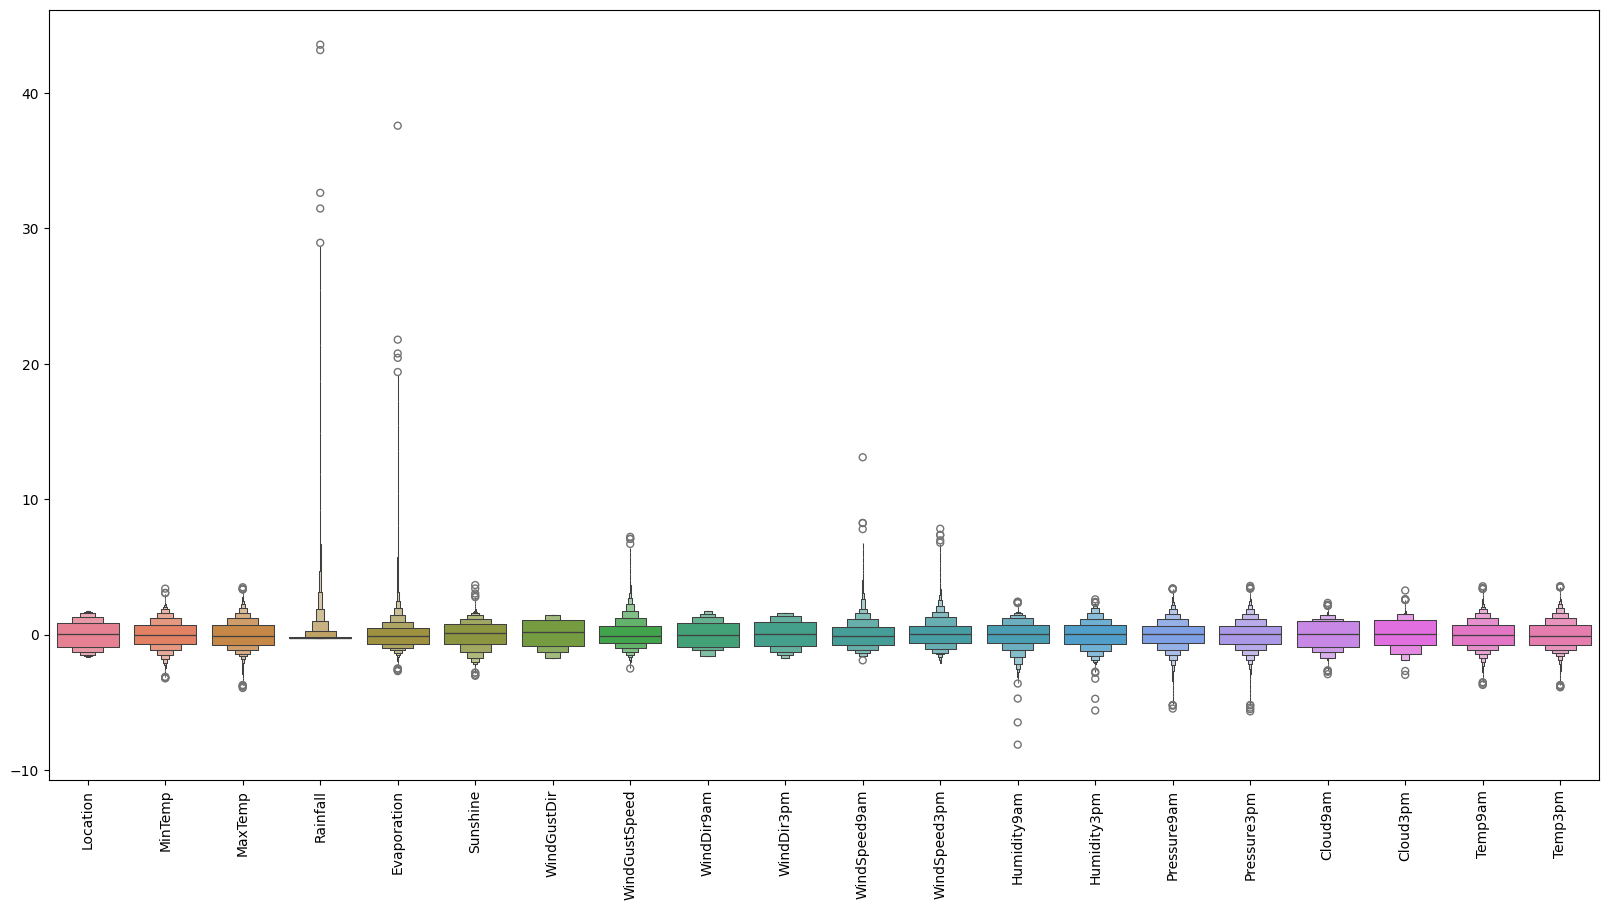

In [19]:
# Prepairing attributes of scale data

features = df.drop(['RainTomorrow','RainToday','Date'], axis=1) # dropping target and extra columns

# Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names) 


plt.figure(figsize=(20,10))
sns.boxenplot(data = features)
plt.xticks(rotation=90)
plt.show()

From this first chart we can see that, in particular, columns **Rainfall**, **Evaporation** and **WindSpeed9am** are caracterised with an high value of outliers.

Now, in order to fix outliers, we add three functions, which use $IQR$ method:
- **outlier_thresholds**: this function calculates, for the specific column of the dataset, its first and third quantile and the Interquantile Range. $IQR$ is defined as the range between the first quartile ($Q1$) and the third quartile ($Q3$) in a dataset. To find the boundaries for identifying potential outliers based on the $IQR$, a common rule of thumb is to consider values outside the range: 
$$[Q1 - 1.5 * IQR,\quad Q3 + 1.5 * IQR]$$

- **check_outliers**: this function verifies that in a specific column there are outliers by checking if there are values outside the previous range. It returns True if there are outliers in that specific column otherwise False

- **replace_with_thresholds**: a common practice is to replace outliers with the specific threshold. In particular, values that are lower than the lower bound are substituted with the lower bound and values that are bigger than the upper bound are replaced with the upper bound.

In [20]:
# Outlier Equation
def outlier_thresholds (dataframe, column, q1=0.25, q3=0.75) :
    quartile1 = dataframe[column].quantile(q1)
    quartile3 = dataframe[column].quantile(q3)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquartile_range
    low_limit = quartile1 - 1.5 * interquartile_range
    return low_limit, up_limit

# Checking Outliers
def check_outlier(dataframe, column):
    low_limit, up_limit = outlier_thresholds(dataframe, column)
    outliers = (dataframe[column] > up_limit) | (dataframe[column] < low_limit)
    if outliers.any():
        return True
    else:
        return False

# Replace with threshold
def replace_with_thresholds (dataframe, column) :
    low_limit , up_limit = outlier_thresholds(dataframe, column)
    dataframe.loc[(dataframe[column] < low_limit), column] = low_limit
    dataframe.loc[(dataframe[column] > up_limit), column] = up_limit

# Replace with median
def replace_with_median(dataframe, column):
    low_limit, up_limit = outlier_thresholds(dataframe, column)
    median_value = dataframe[column].mean()
    dataframe.loc[(dataframe[column] < low_limit), column] = median_value
    dataframe.loc[(dataframe[column] > up_limit), column] = median_value

In [21]:
print('Before removing the outliers :')
for column in (df.drop(columns = ['RainTomorrow', 'RainToday', 'Date', 'Location']).columns):
    print(column, check_outlier(df, column))

Before removing the outliers :
MinTemp True
MaxTemp True
Rainfall True
Evaporation True
Sunshine True
WindGustDir False
WindGustSpeed True
WindDir9am False
WindDir3pm False
WindSpeed9am True
WindSpeed3pm True
Humidity9am True
Humidity3pm True
Pressure9am True
Pressure3pm True
Cloud9am False
Cloud3pm False
Temp9am True
Temp3pm True


In [22]:
print('After removing the outliers :')
for column in (df.drop(columns = ['RainTomorrow', 'RainToday', 'Date', 'Location']).columns):
    replace_with_thresholds(df, column)
    print(column, check_outlier(df, column))

After removing the outliers :
MinTemp False
MaxTemp False
Rainfall False
Evaporation False
Sunshine False
WindGustDir False


WindGustSpeed False
WindDir9am False
WindDir3pm False
WindSpeed9am False
WindSpeed3pm False
Humidity9am False
Humidity3pm False
Pressure9am False
Pressure3pm False
Cloud9am False
Cloud3pm False
Temp9am False
Temp3pm False


Final check

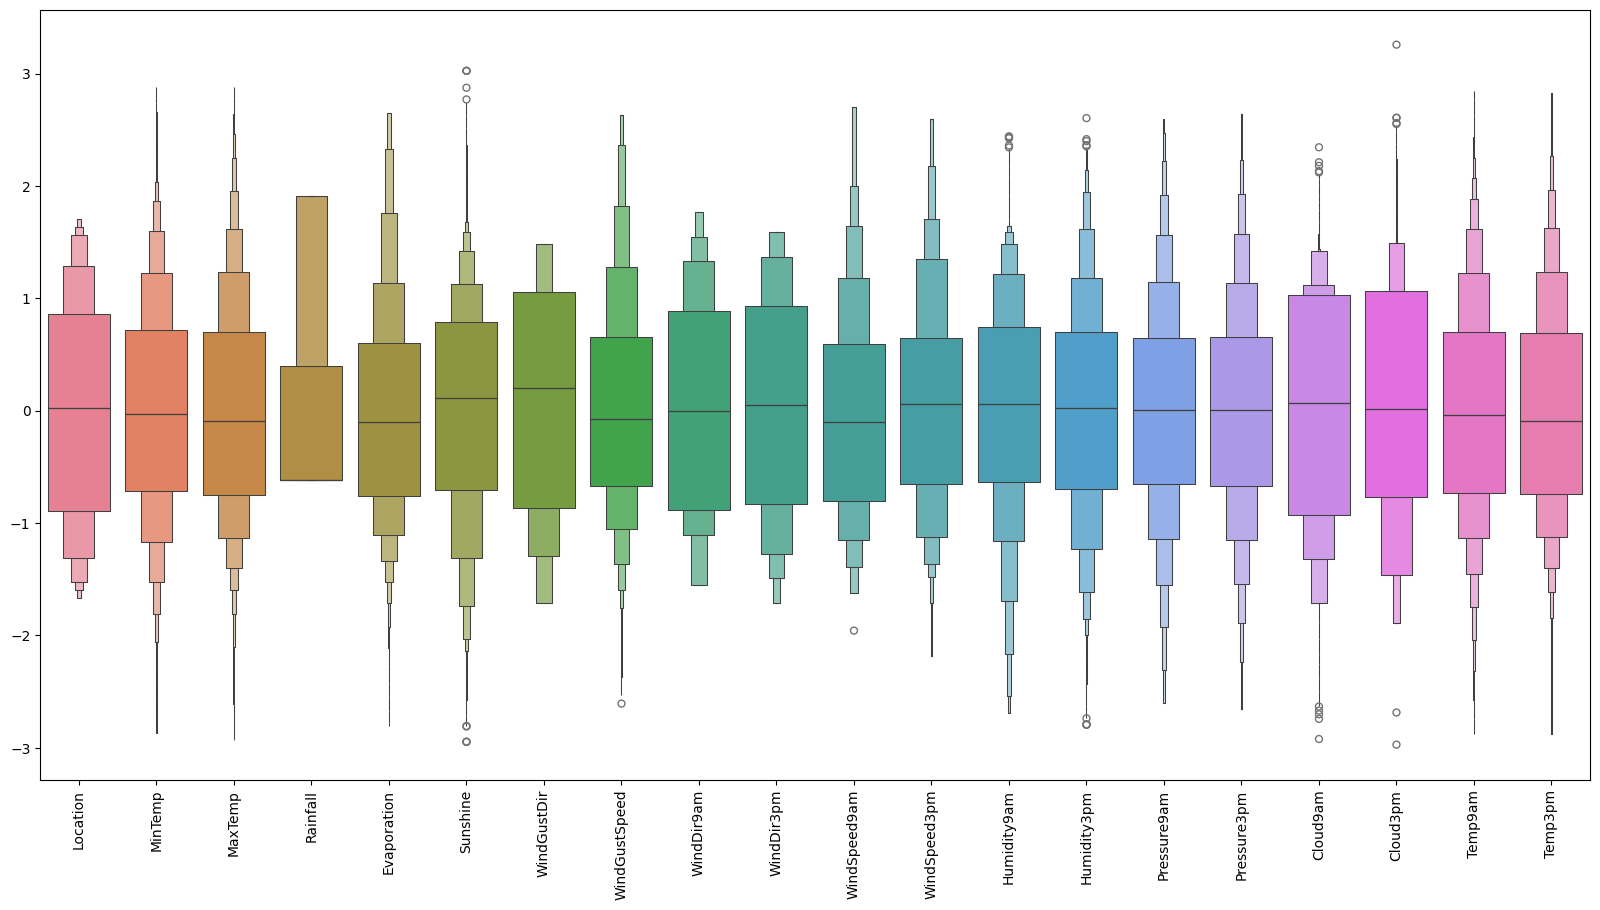

In [23]:
features = df.drop(['RainTomorrow','RainToday','Date'], axis=1) # dropping target and extra columns

# Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names) 

#Detecting outliers

plt.figure(figsize=(20,10))
sns.boxenplot(data = features)
plt.xticks(rotation=90)
plt.show()

Now, we try to explore **Multicollinearity problem**

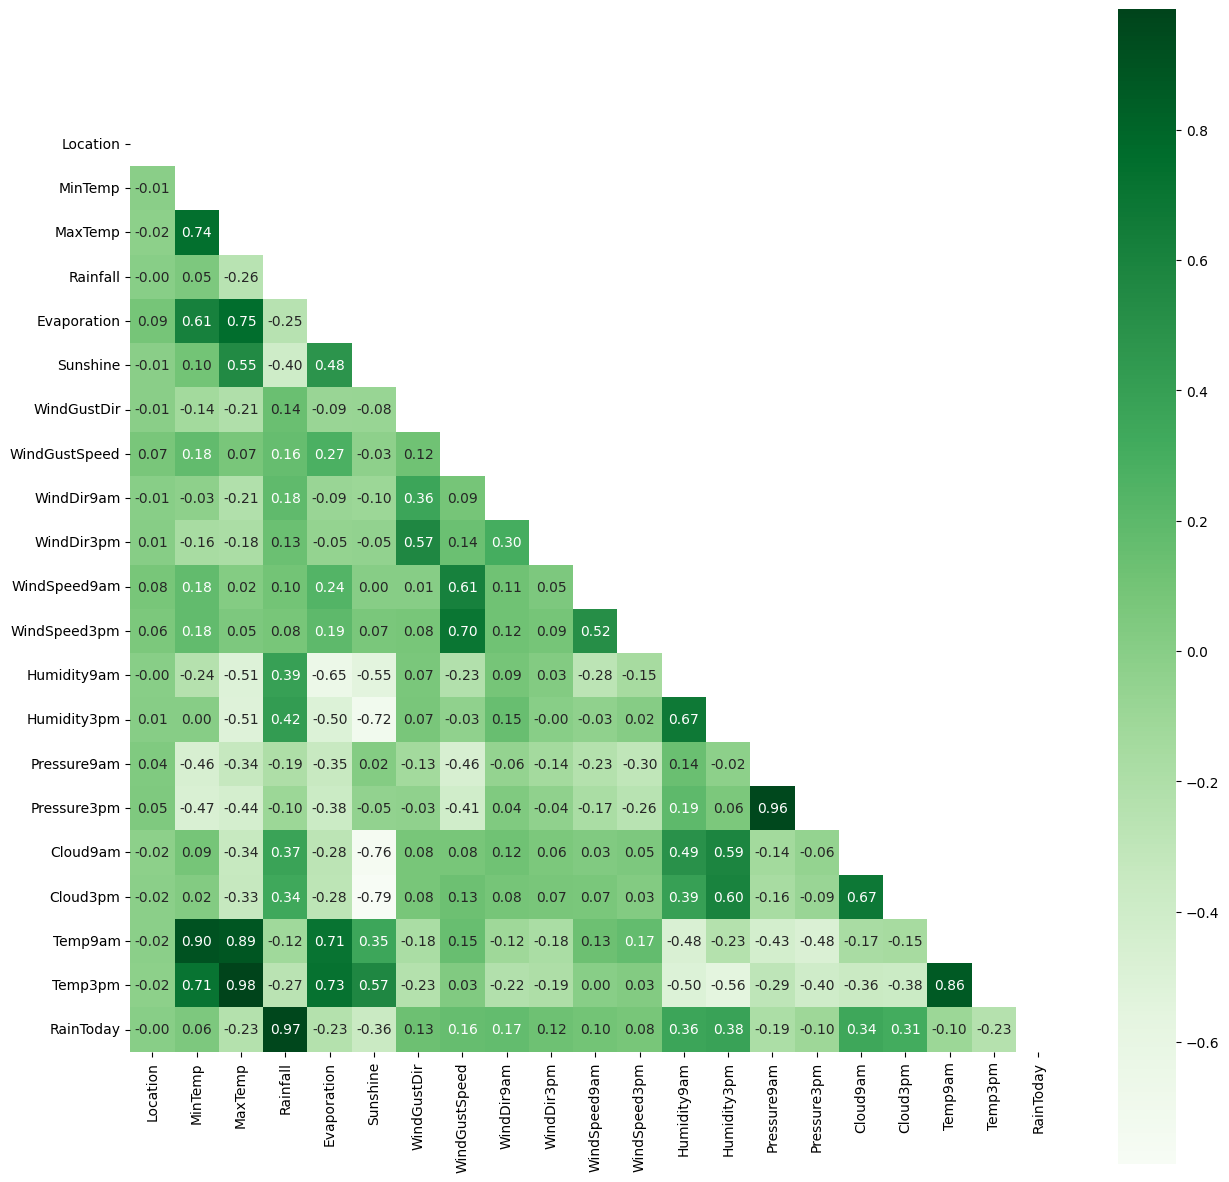

In [24]:
corr = df.drop(['RainTomorrow', 'Date'], axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(15,15))
ax = sns.heatmap(corr, mask=mask, square=True, annot=True, fmt='.2f', cmap='Greens')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

From the matrix we can observe that some features are higly correlated. 

So, we can adopt the **VIF** method or *Variance Inflaction Factor*. In VIF method, we pick each feature and regress it against all of the other features. For each regression, the factor is calculated as :
$$ VIF = \frac{1}{1 - R^2}$$
As we see from the formula, greater the value of $R^2$, greater is the $VIF$. Hence, greater $VIF$ denotes greater correlation.

In [25]:
# add a constant
X = add_constant(df.drop(['RainTomorrow'], axis=1))

# for each column we calculate the vif value
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


          feature           VIF
0           const  43000.933464
1            Date      1.019089
2        Location      1.048043
3         MinTemp     10.915623
4         MaxTemp     49.509326
5        Rainfall     16.580866
6     Evaporation      3.826661
7        Sunshine      5.563556
8     WindGustDir      1.626109
9   WindGustSpeed      3.057047
10     WindDir9am      1.296399
11     WindDir3pm      1.650072
12   WindSpeed9am      1.946910
13   WindSpeed3pm      2.283799
14    Humidity9am      4.634240
15    Humidity3pm      6.831019
16    Pressure9am     24.275623
17    Pressure3pm     23.138382
18       Cloud9am      2.941021
19       Cloud3pm      3.098813
20        Temp9am     23.135183
21        Temp3pm     55.815780
22      RainToday     15.481261


Now, step by step, we select the variable with the highest $VIF$ value and we remove it. In this way, we saw that deleting **Temp3pm**, **Temp9am**, **Pressure9am** and **Rainfall** features produced an important decrease.

In [26]:
df_reduced = df.drop(['Temp3pm', 'Pressure9am', 'Temp9am', 'Rainfall'], axis=1)

X_reduced = add_constant(df_reduced.drop(['RainTomorrow'], axis=1))
vif_data_reduced = pd.DataFrame()
vif_data_reduced["feature"] = X_reduced.columns
vif_data_reduced["VIF"] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]

print(vif_data_reduced)


          feature           VIF
0           const  40994.929955
1            Date      1.017247
2        Location      1.047645
3         MinTemp      5.633780
4         MaxTemp      8.086556
5     Evaporation      3.622636
6        Sunshine      5.388329
7     WindGustDir      1.609030
8   WindGustSpeed      2.967927
9      WindDir9am      1.275793
10     WindDir3pm      1.559342
11   WindSpeed9am      1.923658
12   WindSpeed3pm      2.205593
13    Humidity9am      2.857733
14    Humidity3pm      4.017702
15    Pressure3pm      1.686417
16       Cloud9am      2.897327
17       Cloud3pm      3.007988
18      RainToday      1.362563


So we can drop them

In [27]:
df.drop(['Temp3pm', 'Pressure9am', 'Temp9am', 'Rainfall'], axis=1, inplace=True)

# Machine Learning
Now we can focus our attention on predicting the target column **RainTomorrow** by using different ML algorithm.

In [28]:
df.drop('Date',axis = 1, inplace = True)

## Data Preprocessing

From the chart we can see that we have the problem of **IMBALACED DATASET**.

This aspect is a problem in the field of Machine Learning because when we try to apply any prediction algorithm we will notice that it will predict the majority class well, but not the minority.

This is because the algorithm was trained on an instance that had a majority of 'NO' cases.

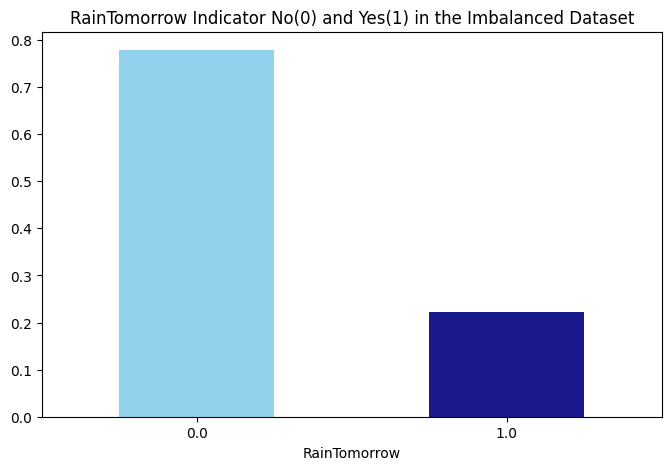

In [29]:
fig = plt.figure(figsize = (8,5))
df.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

But **BEFORE** trying to use some skills to avoid this problem we have to split the data into train and test set:

### Divide the data into train and test set

In [30]:
X = df.drop('RainTomorrow', axis = 1)
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=df['RainTomorrow'])

print('X_train size', X_train.shape)
print('y_train size', y_train.shape)
print('X_test size', X_test.shape)
print('y_test size', y_test.shape)

X_train size (105590, 17)
y_train size (105590,)
X_test size (35197, 17)
y_test size (35197,)


### Rebalance the data
Now we can try to apply some skills to avoid imbalanced dataset. We are going to use **SMOTE** and **UNDERSAMPLE** on the train set, not to the test set. If we use SMOTE on the whole dataset before splitting, some synthetic samples will end up in the test set, leading to overly optimistic results.

#### Synthetic Minority Oversampling Technique (**SMOTE**)
**SMOTE** is an oversampling technique where the synthetic samples are generated for the minority class. 
- At first, the total number of oversampling observations $N$ is set up. Generally, it is selected such that the binary class distribution is $1:1$.

- Then the iteration starts by first selecting a positive class instance at random.

- Next, the **KNN’s** (by default 5) for that instance is obtained.

-  At last, $N$ of these $K$ instances is chosen to interpolate new synthetic instances. To do that, using any distance metric the difference in distance between the feature vector and its neighbors is calculated. Now, this difference is multiplied by any random value in $(0,1]$ and is added to the previous feature vector.

<img src="./screenshot.png" alt="Esempio di immagine" width="400"/>

In [31]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Class Distribution after SMOTE:", y_train_smote.value_counts())

print('X_train size', X_train_smote.shape)
print('y_train size', y_train_smote.shape)
print('X_test size', X_test.shape)
print('y_test size', y_test.shape)

Class Distribution after SMOTE: RainTomorrow
0.0    82189
1.0    82189
Name: count, dtype: int64
X_train size (164378, 17)
y_train size (164378,)
X_test size (35197, 17)
y_test size (35197,)


#### Undersample
An other way of handling imbalanced datasets is to reduce the number of observations from the majority class to the minority class ones.

The most well known algorithm in this group is random undersampling, where samples from the targeted classes are removed at random.

In [32]:
rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')

X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

print("Class Distribution after undersample:", y_train_under.value_counts())

print('X_train size', X_train_under.shape)
print('y_train size', y_train_under.shape)
print('X_test size', X_test.shape)
print('y_test size', y_test.shape)

Class Distribution after undersample: RainTomorrow
0.0    23401
1.0    23401
Name: count, dtype: int64
X_train size (46802, 17)
y_train size (46802,)
X_test size (35197, 17)
y_test size (35197,)


### Standardize them
By using *StandardScaler* we apply standardization to the three different models, i.e. **no resample datset**, **SMOTE dataset** and **undersample dataset**.

In [33]:
# Standardize the original training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Standardize the SMOTE training set
scaler_smote = StandardScaler()
X_train_smote_scaled = scaler_smote.fit_transform(X_train_smote)
X_test_smote_scaled = scaler_smote.transform(X_test)

# Standardize the under-sampled training set
scaler_under = StandardScaler()
X_train_under_scaled = scaler_under.fit_transform(X_train_under)
X_test_under_scaled = scaler_under.transform(X_test)

### Model Evaluation Class
This class train and test the selected model and generates the most important metrics:
- **Accuracy**: it calculates the fraction of correct prediction
    $$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$
- **Precision**: in words, precision answers the question: "Out of all the instances predicted as positive by the model, how many were actually positive?". In particular, it is intuitively **the ability of the classifier not to label as positive a sample that is negative.** It is particularly important in situations where the cost of false positives (instances predicted as positive but are actually negative) is high, and you want to minimize the chances of making false positive predictions.
    $$Precision = \frac{TP}{TP + FP} = \frac{TP}{allPositivePrediction}$$
- **Recall**: in words, recall answers the question: "Out of all the actual positive instances, how many did the model correctly identify?". In particular, it is intuitively **the ability of the classifier to find all the positive samples.** It is particularly important in situations where the cost of missing positive instances (false negatives) is high, and you want to minimize the chances of false negatives.
    $$Recall = \frac{TP}{TP + FN} = \frac{TP}{allActualPositive}$$
- **F1**: the F1 score provides a balance between precision and recall. It ranges from $0$ to $1$, where $1$ indicates perfect precision and recall, and $0$ indicates poor performance
    $$F1 = 2\times\frac{Precision \times Recall}{Precision \times Recall}$$
- **Precision-Recall Curve**: Plotting recall values on the x-axis and corresponding precision values on the y-axis generates a PR curve that illustrates a negative slope function. It represents the trade-off between precision (reducing FPs) and recall (reducing FNs) for a given model.

- **ROC Curve**: the ROC curve is drawn by calculating the true positive rate (**TPR**) and false positive rate (**FPR**) at every possible threshold, then graphing TPR over FPR. The **Area Under the ROC curve** (AUC) represents the probability that the model, if given a randomly chosen positive and negative example, will rank the positive higher than the negative.

In [34]:
class Model:
    def __init__(self, model, name = None, scaled = True, resample = None):
        self.model = model
        self.name = name
        self.scaled = scaled
        self.resample = resample
    def fit(self):
        if self.scaled == True and self.resample == None:
            self.model.fit(X_train_scaled, y_train)
        if self.scaled == False and self.resample == None:
            self.model.fit(X_train, y_train)
        if self.scaled == True and self.resample == 'smote':
            self.model.fit(X_train_smote_scaled, y_train_smote)
        if self.scaled == False and self.resample == 'smote':
            self.model.fit(X_train_smote, y_train_smote)
        if self.scaled == True and self.resample == 'under':
            self.model.fit(X_train_under_scaled, y_train_under)
        if self.scaled == False and self.resample == 'under':
            self.model.fit(X_train_under, y_train_under)
    def __get_predictions(self):
        if self.scaled == True and self.resample == None:
            return self.model.predict(X_test_scaled), self.model.predict_proba(X_test_scaled)[:,1]
        if self.scaled == False and self.resample == None:
            return self.model.predict(X_test), self.model.predict_proba(X_test)[:,1]
        if self.scaled == True and self.resample == 'smote':
            return self.model.predict(X_test_smote_scaled), self.model.predict_proba(X_test_smote_scaled)[:,1]
        if self.scaled == False and self.resample == 'smote':
            return self.model.predict(X_test), self.model.predict_proba(X_test)[:,1]
        if self.scaled == True and self.resample == 'under':
            return self.model.predict(X_test_under_scaled), self.model.predict_proba(X_test_under_scaled)[:,1]
        if self.scaled == False and self.resample == 'under':
            return self.model.predict(X_test), self.model.predict_proba(X_test)[:,1]
    def get_metrics(self) -> pd.Series:
        y_pred, y_probs = self.__get_predictions()
        accuracy = metrics.accuracy_score(y_test, y_pred)
        precision = metrics.precision_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred)
        roc_auc = metrics.roc_auc_score(y_test, y_probs)
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        pr_auc = metrics.average_precision_score(y_test, y_probs)
        metrics_series = pd.Series({
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC AUC': roc_auc,
            'Confusion Matrix': conf_mat,
            'PR AUC': pr_auc,
            'Name': self.name
        })
        if self.name == '' or self.name is None:
            metrics_series.Name =type(self.model).__name__
        return metrics_series
    
    def visualize_metrics(self):
        y_pred, y_probs = self.__get_predictions()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
        roc_auc = metrics.roc_auc_score(y_test, y_probs)
        # Calculate Precision-Recall curve and AUC
        precision, recall, _ = metrics.precision_recall_curve(y_test, y_probs)
        pr_auc = metrics.auc(recall, precision)
        # Plot ROC curve
        plt.figure(figsize=(20, 10))
        plt.subplot(2, 2, 1)
        plt.axis('equal')
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')

        # Plot Precision-Recall curve
        plt.subplot(2, 2, 2)
        plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left')

        residuals = y_test - y_probs
        # Plot Confusion Matrix and Distribution of errors
        plt.subplot(2, 2, 3)
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['Actual 0', 'Actual 1'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.subplot(2, 2, 4)
        sns.histplot(residuals, bins=30, edgecolor='black', kde=True)
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.title('Distribution of Errors')
        plt.show()

Here I create 3 different dataframe because for each ML algorithm that I'm going to use, I'm going to save the performance for each approach (No Resample, SMOTE, Undersample).

In [35]:
models_df = pd.DataFrame(columns=['Name',
    'Accuracy',
    'Precision',
    'Recall',
    'F1-Score',
    'ROC AUC',
    'Confusion Matrix',
    'PR AUC'])

models_df_smote = pd.DataFrame(columns=['Name',
    'Accuracy',
    'Precision',
    'Recall',
    'F1-Score',
    'ROC AUC',
    'Confusion Matrix',
    'PR AUC'])

models_df_under = pd.DataFrame(columns=['Name',
    'Accuracy',
    'Precision',
    'Recall',
    'F1-Score',
    'ROC AUC',
    'Confusion Matrix',
    'PR AUC'])

## Linear Discriminant Analysis (LDA)
A classifier with a linear decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule. In particular, the model fits a Gaussian density to each class, assuming that all classes share the same covariance matrix. It also assumes that the data is linearly separable, meaning that a linear decision boundary can accurately classify the different classes.

### No resample

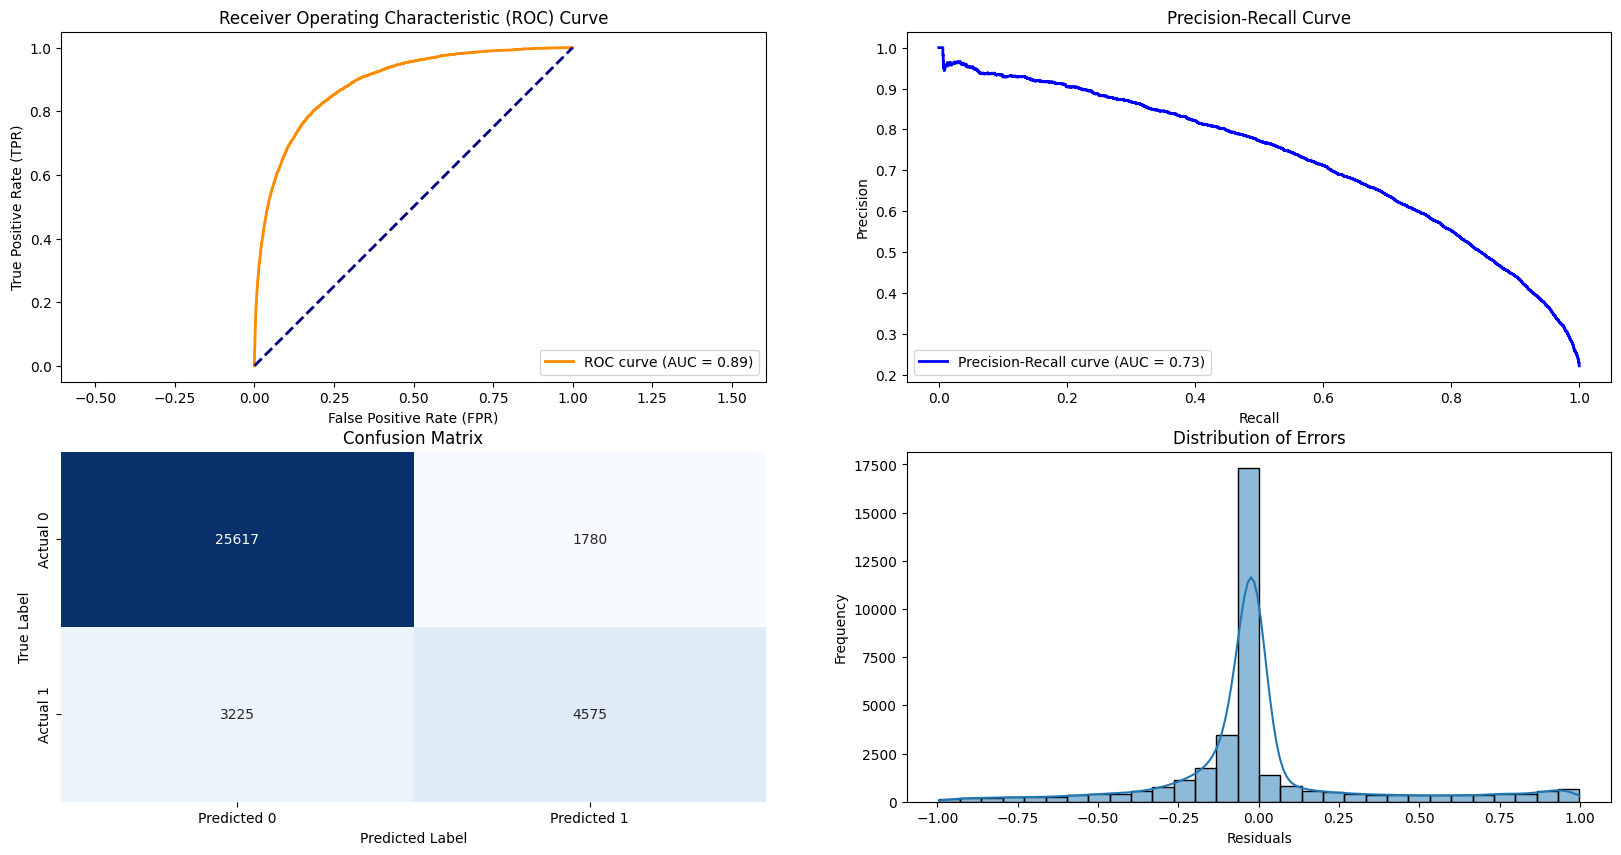

In [36]:
model = Model(LinearDiscriminantAnalysis(), name='LDA No Resample', scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [37]:
metrics_LDA_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_LDA_no_resample.to_frame().T])
print(metrics_LDA_no_resample)

Accuracy                                   0.8578
Precision                                0.719906
Recall                                   0.586538
F1-Score                                 0.646415
ROC AUC                                  0.888577
Confusion Matrix    [[25617, 1780], [3225, 4575]]
PR AUC                                   0.727093
Name                              LDA No Resample
dtype: object


### SMOTE

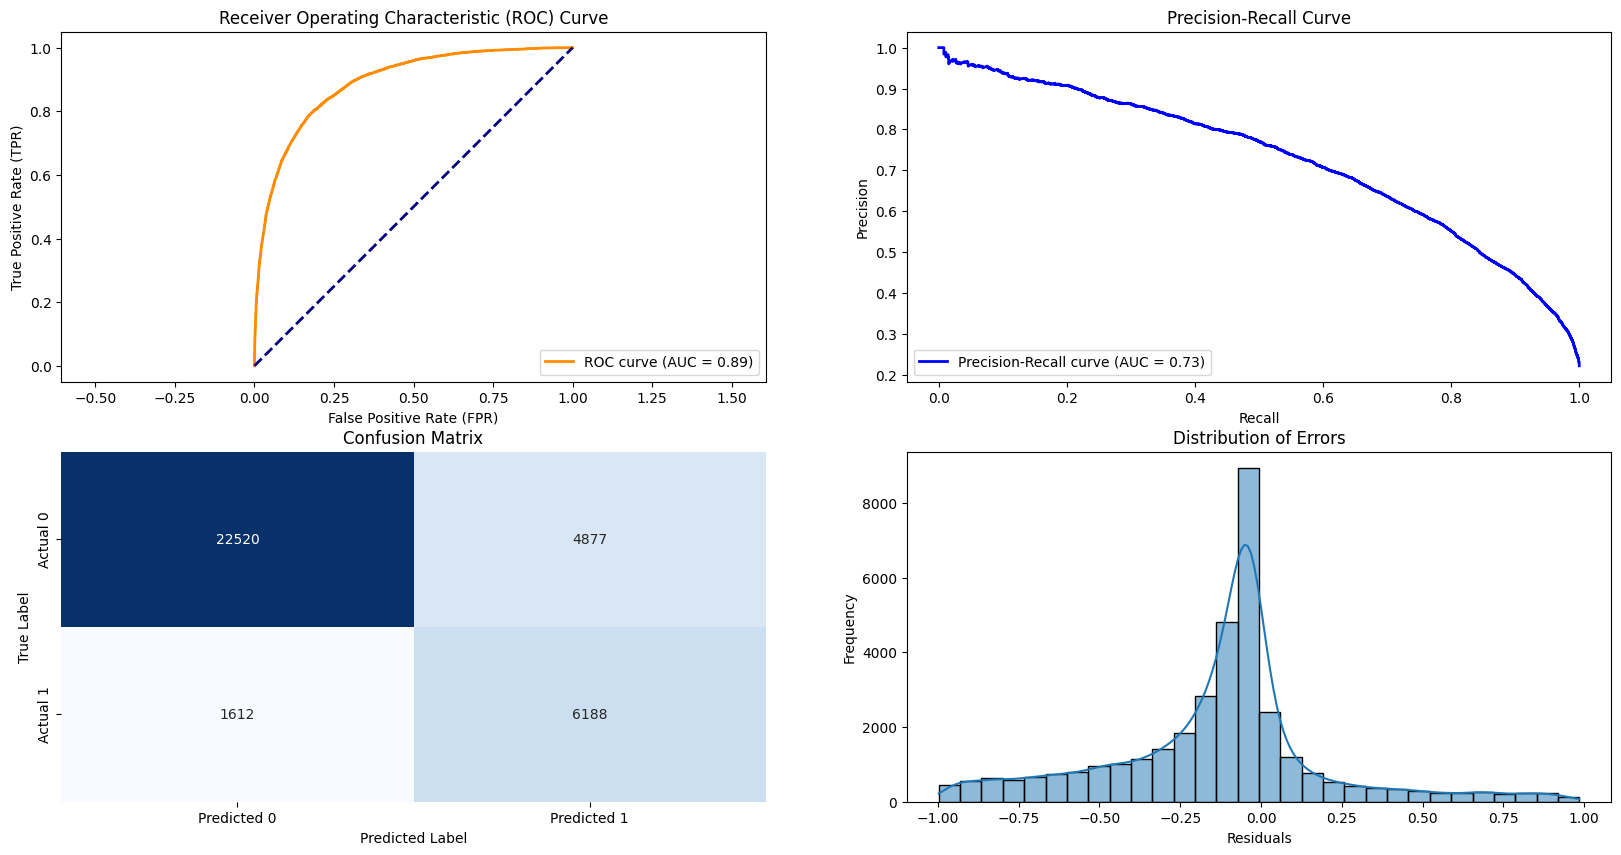

In [38]:
model = Model(LinearDiscriminantAnalysis(), name='LDA SMOTE', scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [39]:
metrics_LDA_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_LDA_smote.to_frame().T])
print(metrics_LDA_smote)

Accuracy                                 0.815638
Precision                                0.559241
Recall                                   0.793333
F1-Score                                  0.65603
ROC AUC                                   0.88886
Confusion Matrix    [[22520, 4877], [1612, 6188]]
PR AUC                                   0.726089
Name                                    LDA SMOTE
dtype: object


### Undersample

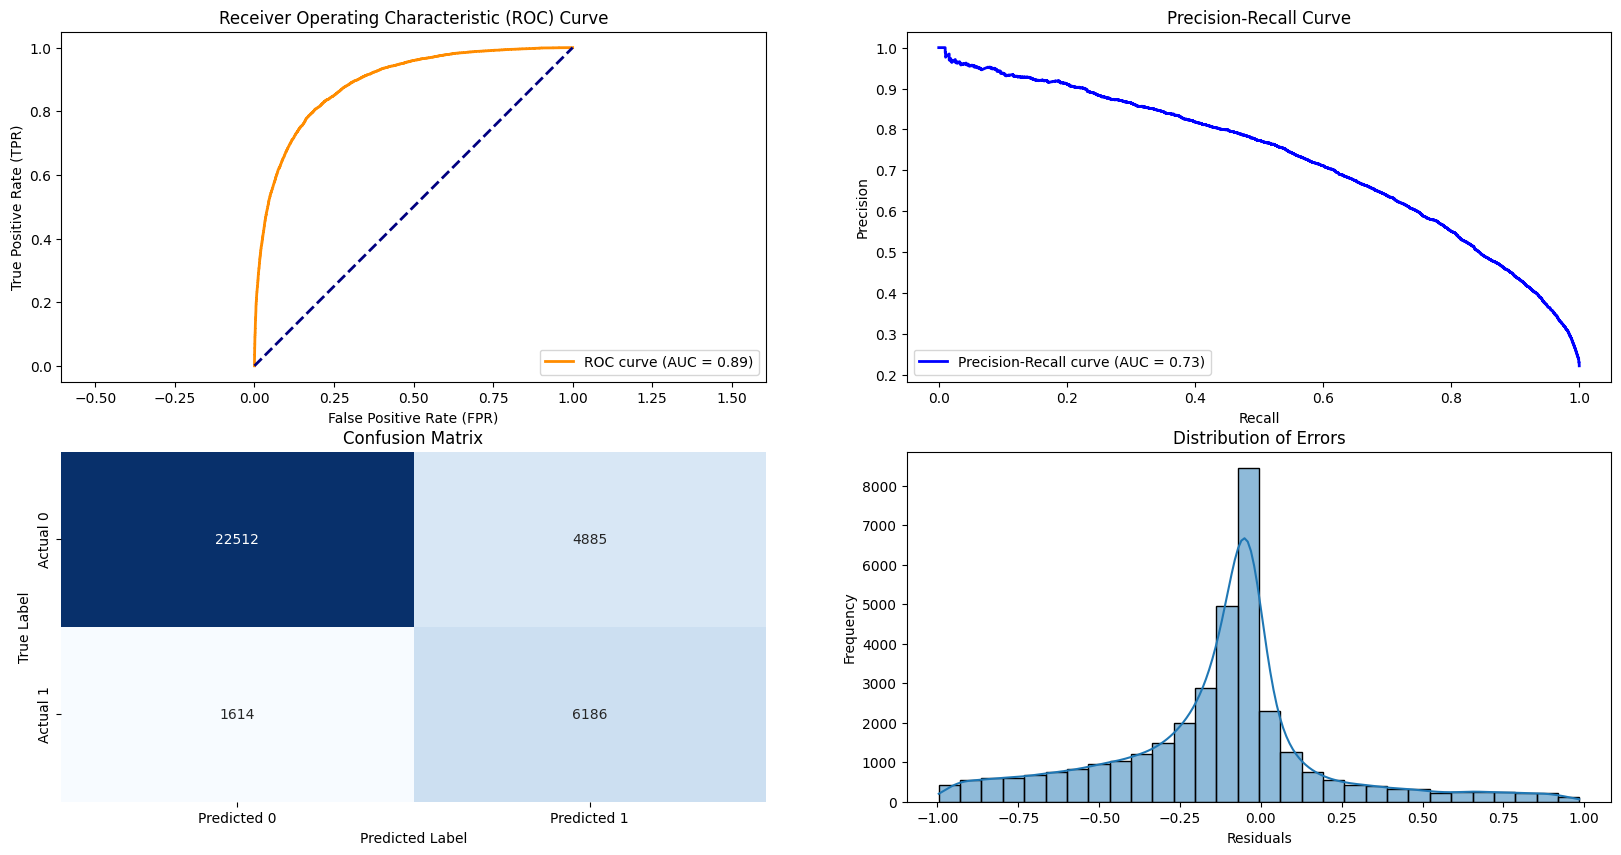

In [40]:
model = Model(LinearDiscriminantAnalysis(), name='LDA undersample', scaled=True, resample='under')
model.fit()
model.visualize_metrics()

In [41]:
metrics_LDA_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_LDA_under.to_frame().T])
print(metrics_LDA_under)

Accuracy                                 0.815354
Precision                                0.558757
Recall                                   0.793077
F1-Score                                 0.655609
ROC AUC                                  0.889342
Confusion Matrix    [[22512, 4885], [1614, 6186]]
PR AUC                                   0.727967
Name                              LDA undersample
dtype: object


## Logistic Regression
It is a special case of linear regression where the target variable is categorical in nature. Logistic Regression predicts the probability of occurrence of a binary event utilizing the Sigmoid Function.

### No resample
In this case we perform *GridSearchCV* in order to establish the parameters of the model that performs better.

In [42]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # Regularization penalty
    'solver': ['liblinear', 'lbfgs','newton-cg','newton-cholesky','sag','saga']  # Optimization algorithm
}
clf = GridSearchCV(LogisticRegression(), param_grid)
clf = clf.fit(X_train_scaled, y_train)
best_lr_model = clf.best_estimator_

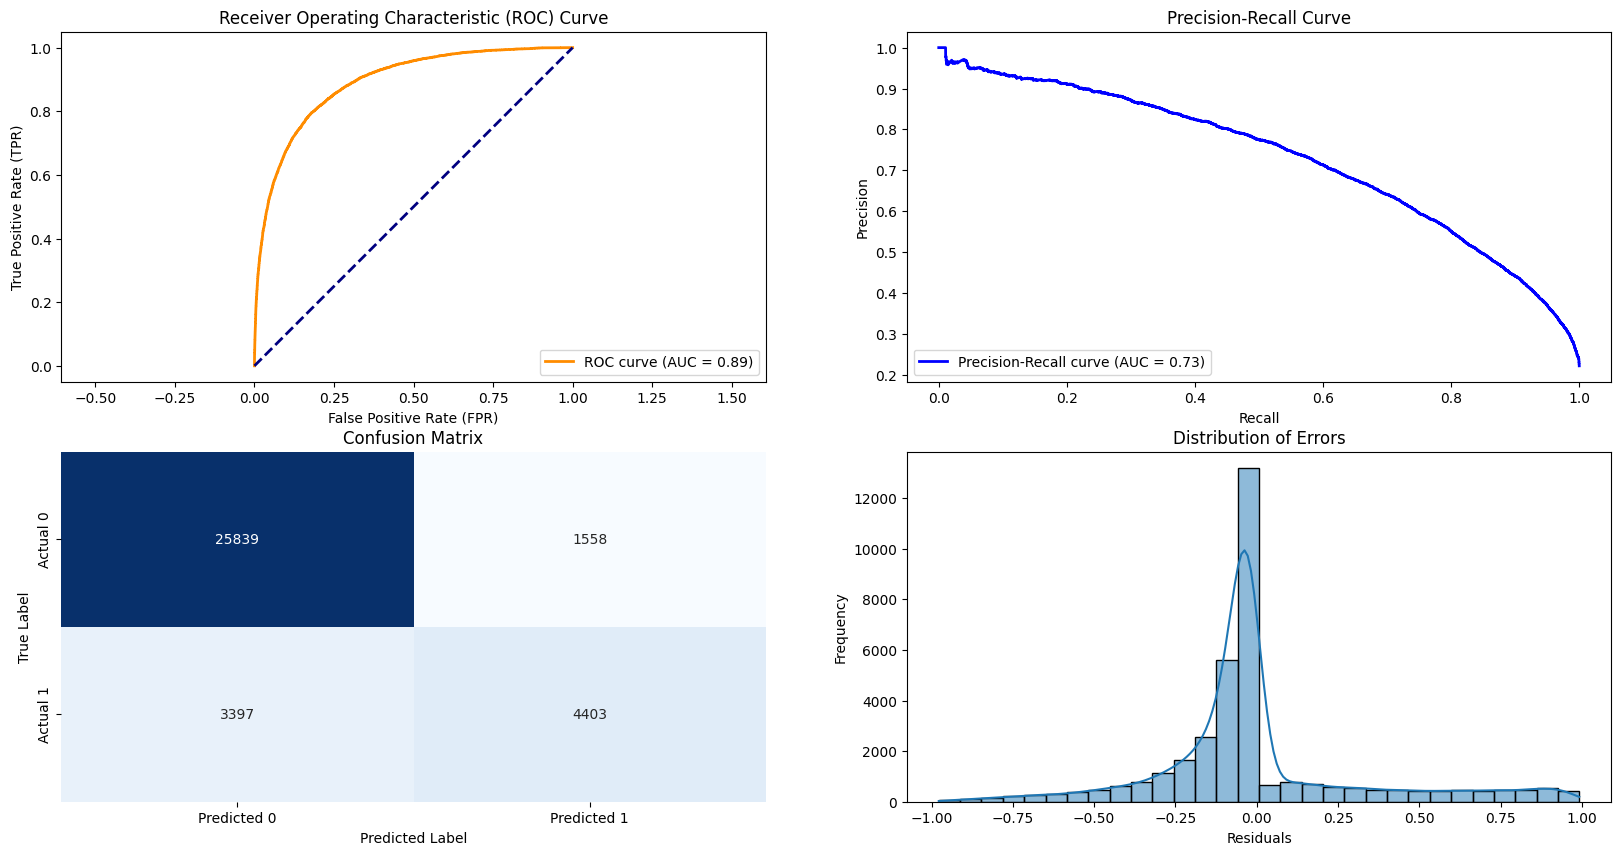

In [43]:
# Create the model
model = Model(best_lr_model, 
              name='Logistic Regression No Resample', 
              scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [44]:
metrics_LR_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_LR_no_resample.to_frame().T])
print(metrics_LR_no_resample)

Accuracy                                   0.859221
Precision                                  0.738634
Recall                                     0.564487
F1-Score                                   0.639924
ROC AUC                                    0.889739
Confusion Matrix      [[25839, 1558], [3397, 4403]]
PR AUC                                     0.729967
Name                Logistic Regression No Resample
dtype: object


### SMOTE

In [45]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # Regularization penalty
    'solver': ['liblinear', 'lbfgs','newton-cg','newton-cholesky','sag','saga']  # Optimization algorithm
}
clf = GridSearchCV(LogisticRegression(), param_grid)
clf = clf.fit(X_train_smote_scaled, y_train_smote)
best_lr_model = clf.best_estimator_

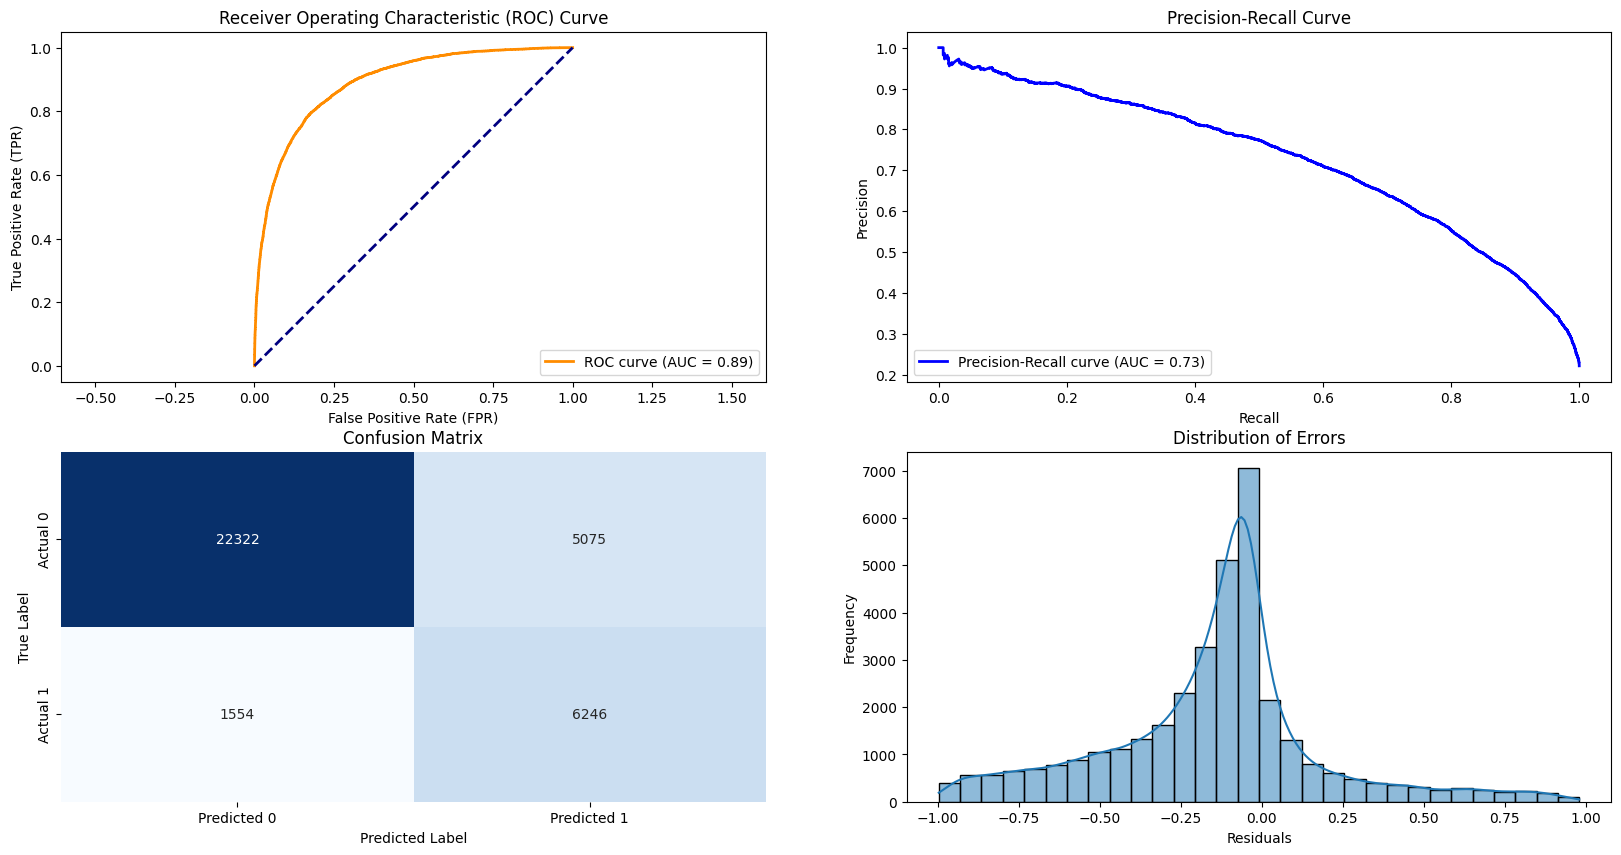

In [46]:
model = Model(best_lr_model, 
              name='Logistic Regression Smote', 
              scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [47]:
metrics_LR_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_LR_smote.to_frame().T])
print(metrics_LR_smote)

Accuracy                                  0.81166
Precision                                0.551718
Recall                                   0.800769
F1-Score                                 0.653313
ROC AUC                                  0.889469
Confusion Matrix    [[22322, 5075], [1554, 6246]]
PR AUC                                   0.726918
Name                    Logistic Regression Smote
dtype: object


### Undersample

In [48]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # Regularization penalty
    'solver': ['liblinear', 'lbfgs','newton-cg','newton-cholesky','sag','saga']  # Optimization algorithm
}
clf = GridSearchCV(LogisticRegression(), param_grid)
clf = clf.fit(X_train_under_scaled, y_train_under)
best_lr_model = clf.best_estimator_

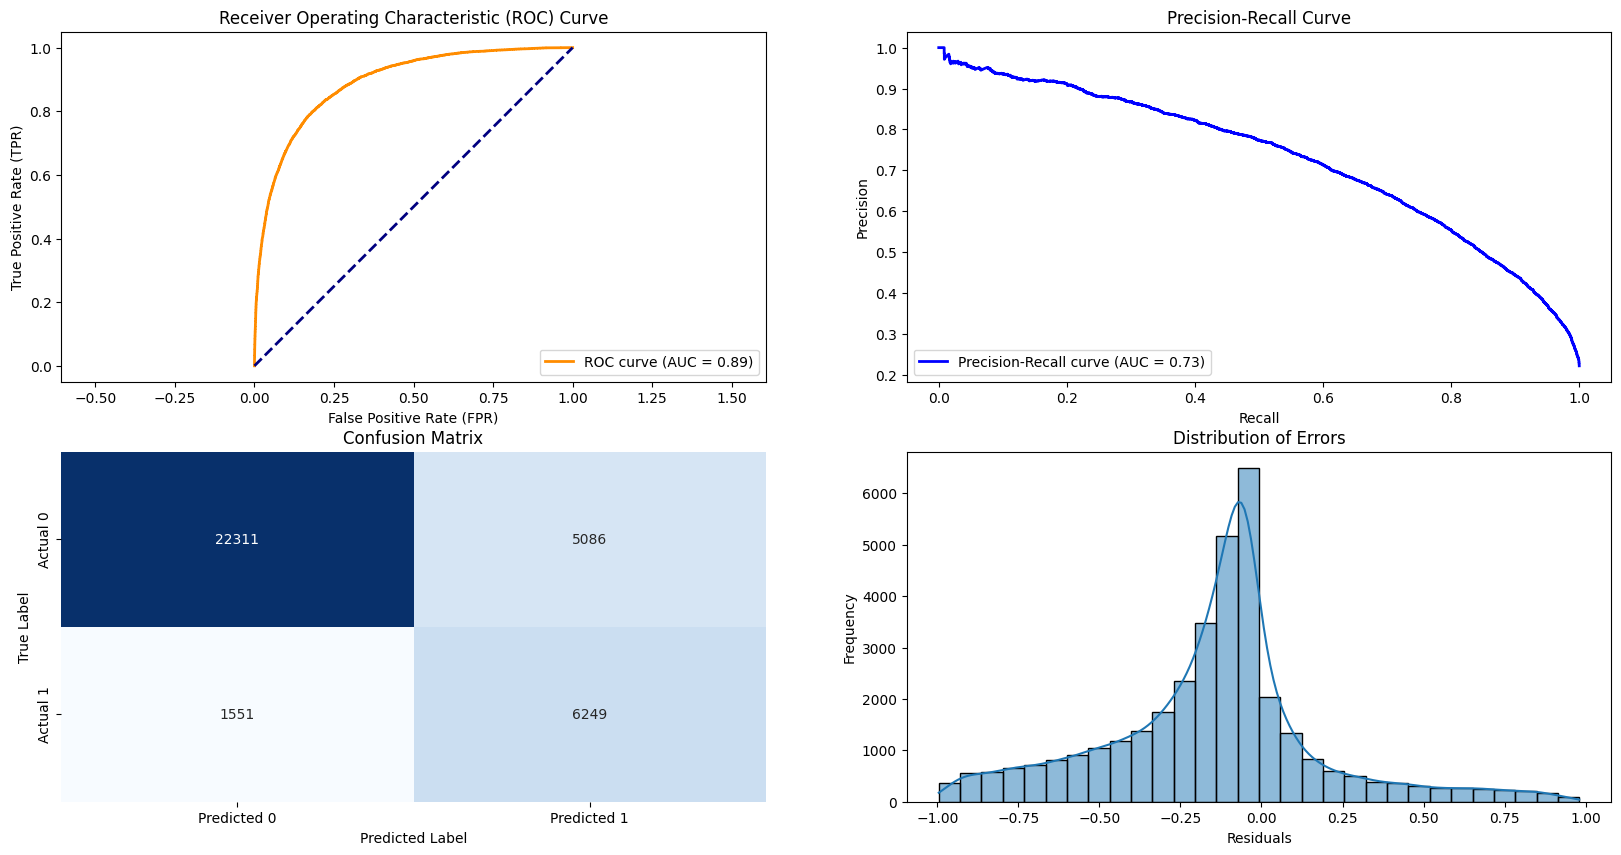

In [49]:
model = Model(best_lr_model, 
              name='Logistic Regression Undersample', 
              scaled=True, resample='under')
model.fit()
model.visualize_metrics()

In [50]:
metrics_LR_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_LR_under.to_frame().T])
print(metrics_LR_under)

Accuracy                                   0.811433
Precision                                  0.551301
Recall                                     0.801154
F1-Score                                   0.653149
ROC AUC                                    0.889934
Confusion Matrix      [[22311, 5086], [1551, 6249]]
PR AUC                                      0.72871
Name                Logistic Regression Undersample
dtype: object


## Decision Tree Classifier
In this case, but also in others, I preferred to use *RandomizedSearchCV*. Its concept is the same of *GridSearchCV*, but it is faster. In fact, in contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions.

### No Resample

In [ ]:
from scipy.stats import randint

param_dist = {
    'max_depth': randint(1, 20), # Maximum shaft depth
    'min_samples_split': randint(2, 40), # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 20), # Minimum number of samples required at a leaf node
    'criterion': ['gini', 'entropy'], # Function to be optimised for node division
    'max_features': ['sqrt', 'log2', None] # Maximum number of characteristics to be considered for division
}

dt = DecisionTreeClassifier(random_state=42)

random_search = RandomizedSearchCV(dt,
                                   param_distributions=param_dist, 
                                   n_iter=100, # Search on 100 random combinations of parameters.
                                   cv=5, # It uses a 5-fold cross-validation to evaluate each combination of hyper-parameters.
                                   verbose=2, # Level of detail shown during the search. With 2, you get more information on progress.
                                   random_state=42, 
                                   n_jobs=-1)


random_search.fit(X_train_scaled, y_train)
best_dt_model = random_search.best_estimator_

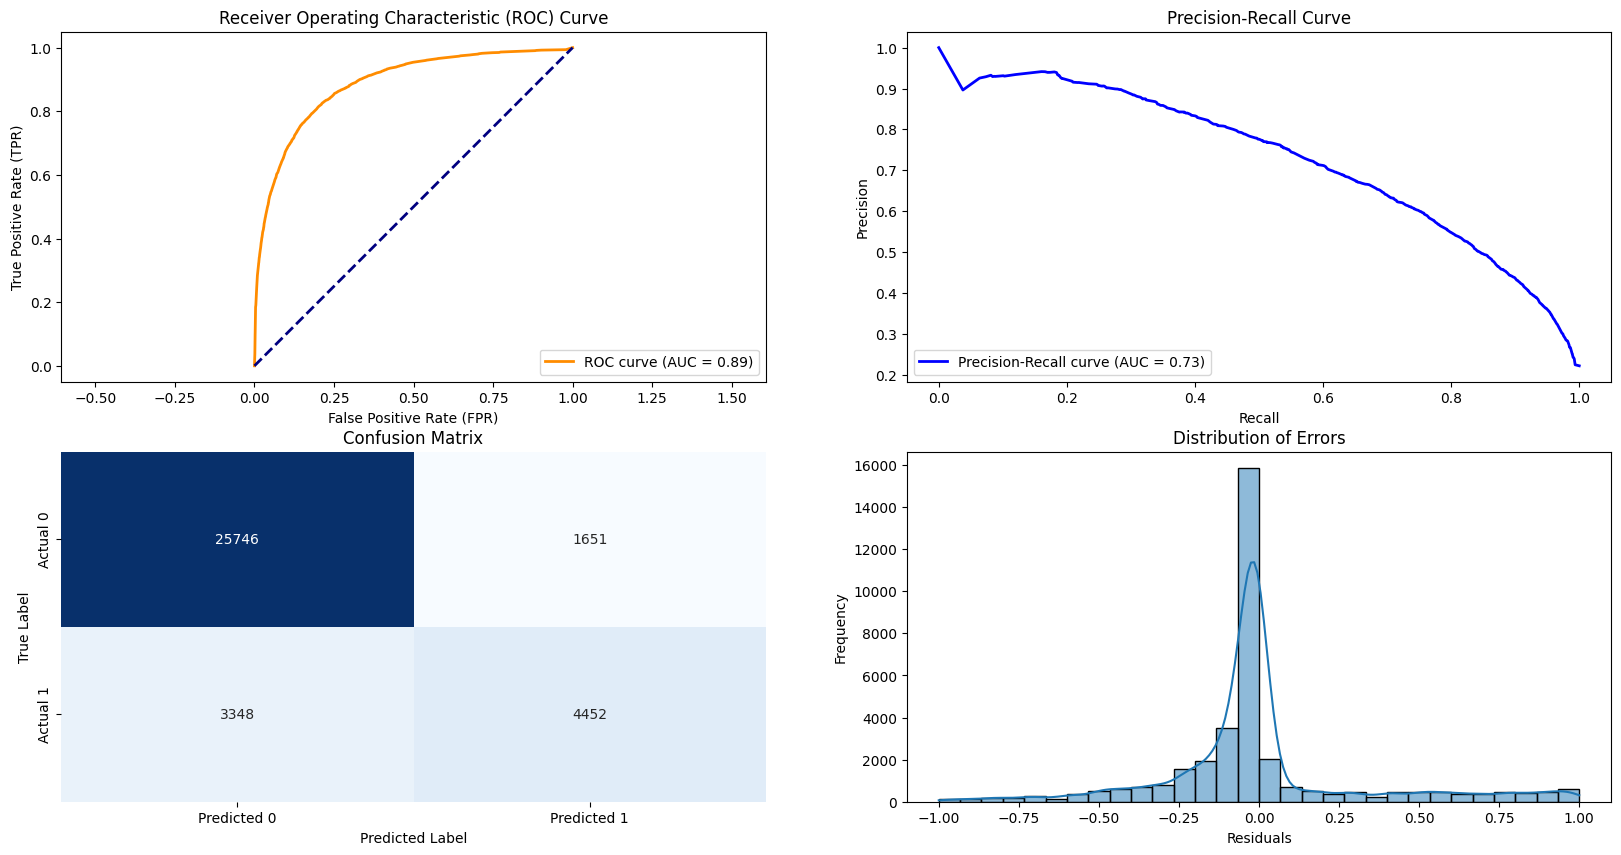

In [52]:
model = Model(best_dt_model, 
              name='DT No Resample', 
              scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [53]:
metrics_DT_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_DT_no_resample.to_frame().T])
print(metrics_DT_no_resample)

Accuracy                                 0.857971
Precision                                0.729477
Recall                                   0.570769
F1-Score                                 0.640437
ROC AUC                                   0.88525
Confusion Matrix    [[25746, 1651], [3348, 4452]]
PR AUC                                   0.726767
Name                               DT No Resample
dtype: object


### SMOTE

In [ ]:
param_dist = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 40),
    'min_samples_leaf': randint(1, 20),
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

dt = DecisionTreeClassifier(random_state=42)

random_search = RandomizedSearchCV(dt, param_distributions=param_dist, 
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)


random_search.fit(X_train_smote_scaled, y_train_smote)
best_dt_model = random_search.best_estimator_

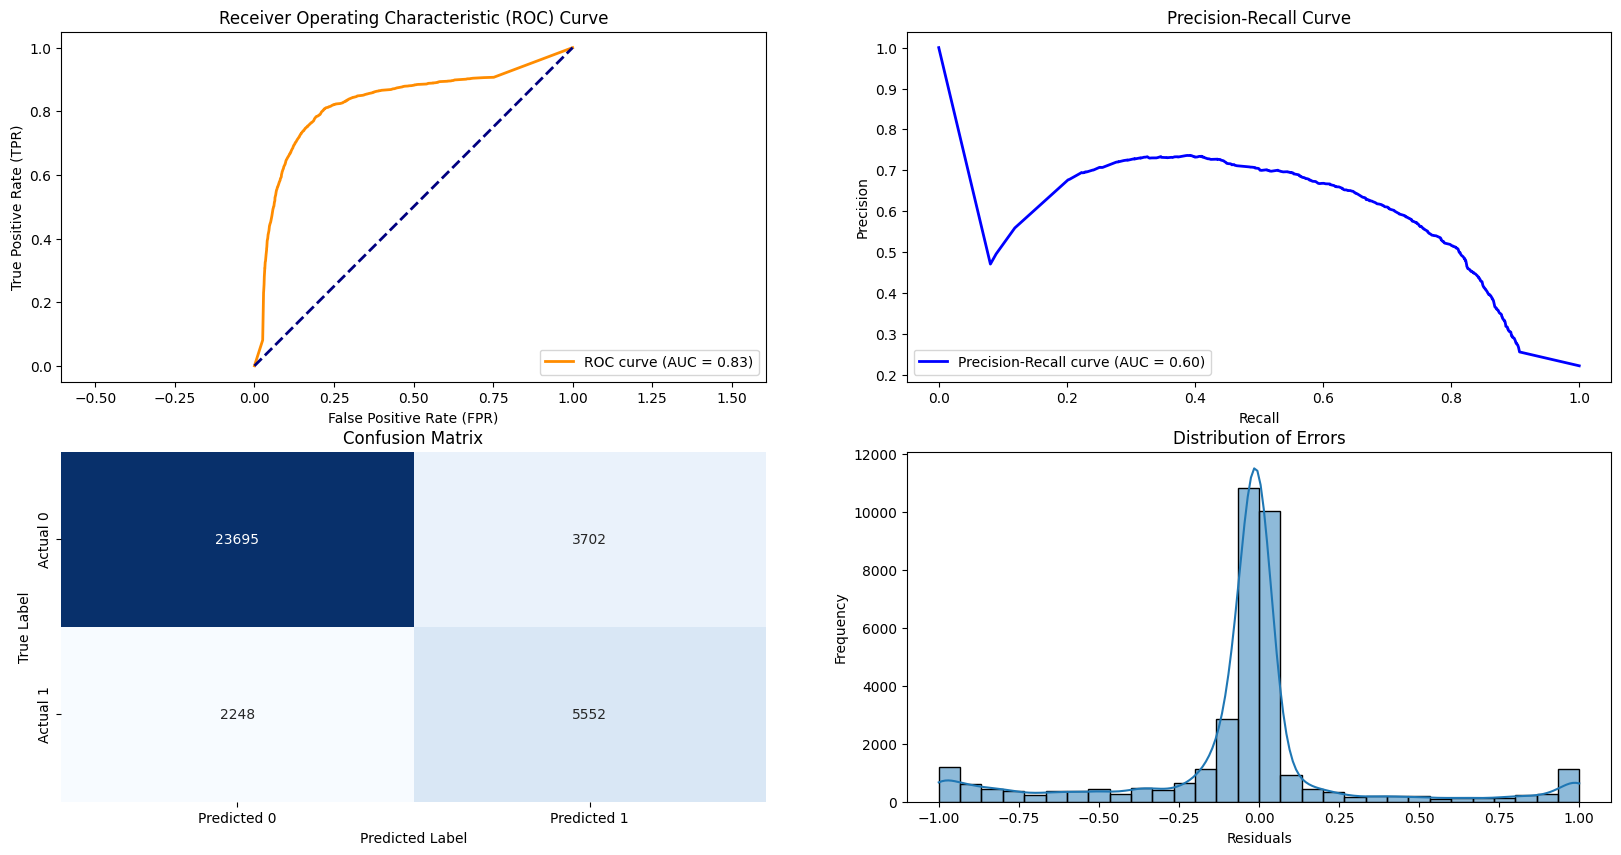

In [55]:
model = Model(best_dt_model, 'DT Smote', scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [56]:
metrics_DT_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_DT_smote.to_frame().T])
print(metrics_DT_smote)

Accuracy                                 0.830952
Precision                                0.599957
Recall                                   0.711795
F1-Score                                 0.651108
ROC AUC                                  0.826855
Confusion Matrix    [[23695, 3702], [2248, 5552]]
PR AUC                                   0.581907
Name                                     DT Smote
dtype: object


### Undersample

In [ ]:
param_dist = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 40),
    'min_samples_leaf': randint(1, 20),
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

dt = DecisionTreeClassifier(random_state=42)

random_search = RandomizedSearchCV(dt, param_distributions=param_dist, 
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)


random_search.fit(X_train_under_scaled, y_train_under)
best_dt_model = random_search.best_estimator_

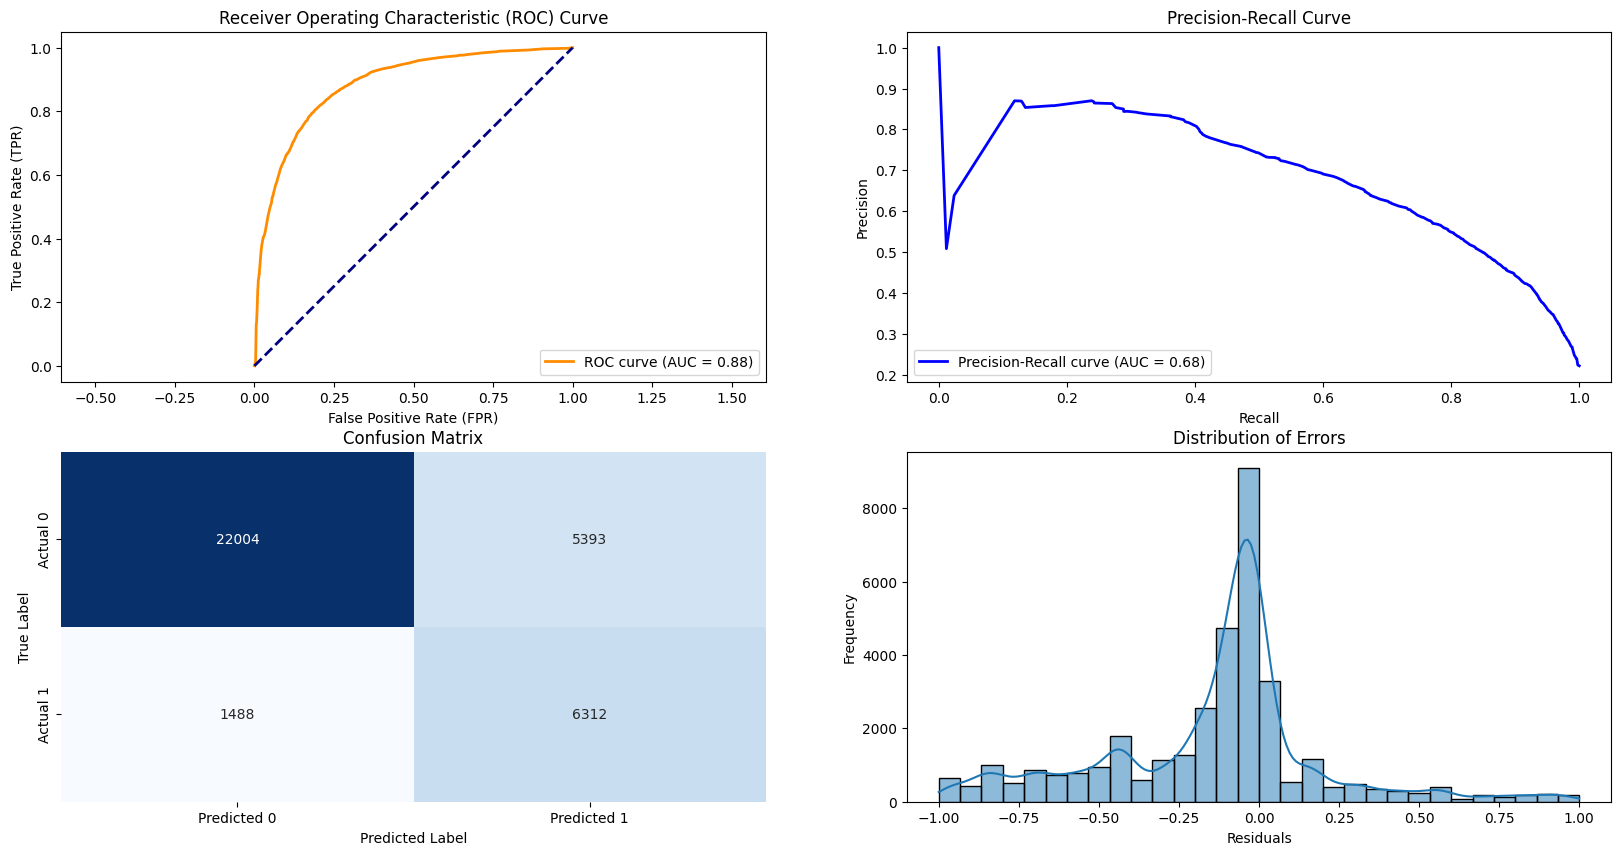

In [58]:
model = Model(best_dt_model, name='DT Undersample', scaled=False, resample='under')
model.fit()
model.visualize_metrics()

In [59]:
metrics_DT_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_DT_under.to_frame().T])
print(metrics_DT_under)

Accuracy                                   0.8045
Precision                                0.539257
Recall                                   0.809231
F1-Score                                 0.647219
ROC AUC                                  0.883556
Confusion Matrix    [[22004, 5393], [1488, 6312]]
PR AUC                                   0.692408
Name                               DT Undersample
dtype: object


## Random Forest
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

### No Resample

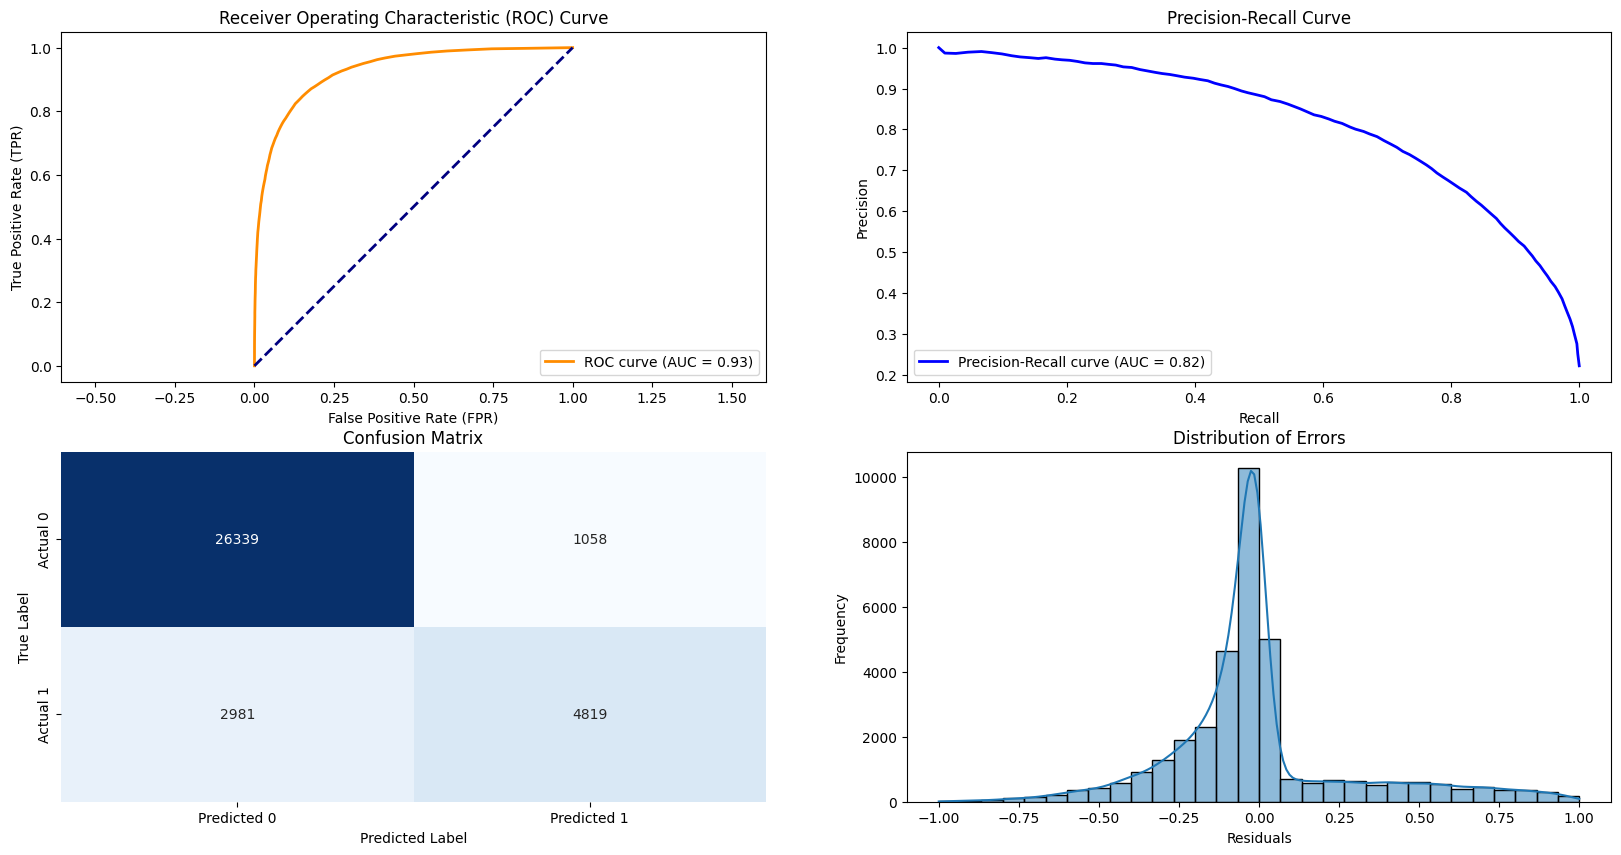

In [60]:
model = Model(RandomForestClassifier(), name='RF No Resample', scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [61]:
metrics_RF_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_RF_no_resample.to_frame().T])
print(metrics_RF_no_resample)

Accuracy                                 0.885246
Precision                                0.819976
Recall                                   0.617821
F1-Score                                 0.704687
ROC AUC                                  0.927123
Confusion Matrix    [[26339, 1058], [2981, 4819]]
PR AUC                                   0.815329
Name                               RF No Resample
dtype: object


### SMOTE

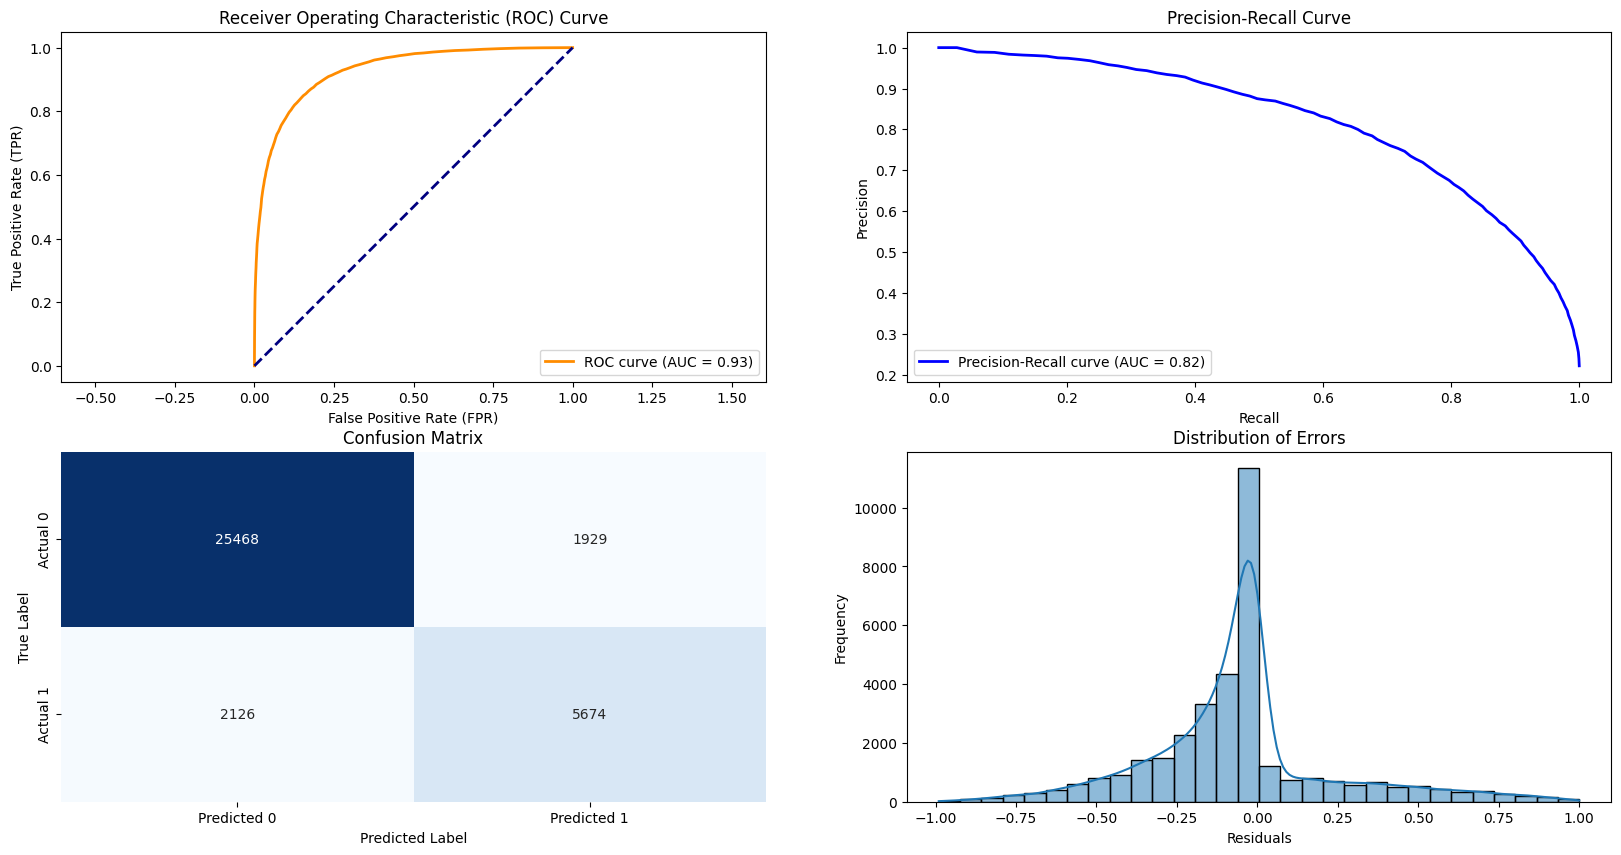

In [62]:
model = Model(RandomForestClassifier(), name='RF SMOTE', scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [63]:
metrics_RF_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_RF_smote.to_frame().T])
print(metrics_RF_smote)

Accuracy                                 0.884791
Precision                                0.746284
Recall                                   0.727436
F1-Score                                  0.73674
ROC AUC                                  0.927299
Confusion Matrix    [[25468, 1929], [2126, 5674]]
PR AUC                                   0.815562
Name                                     RF SMOTE
dtype: object


### Undersample

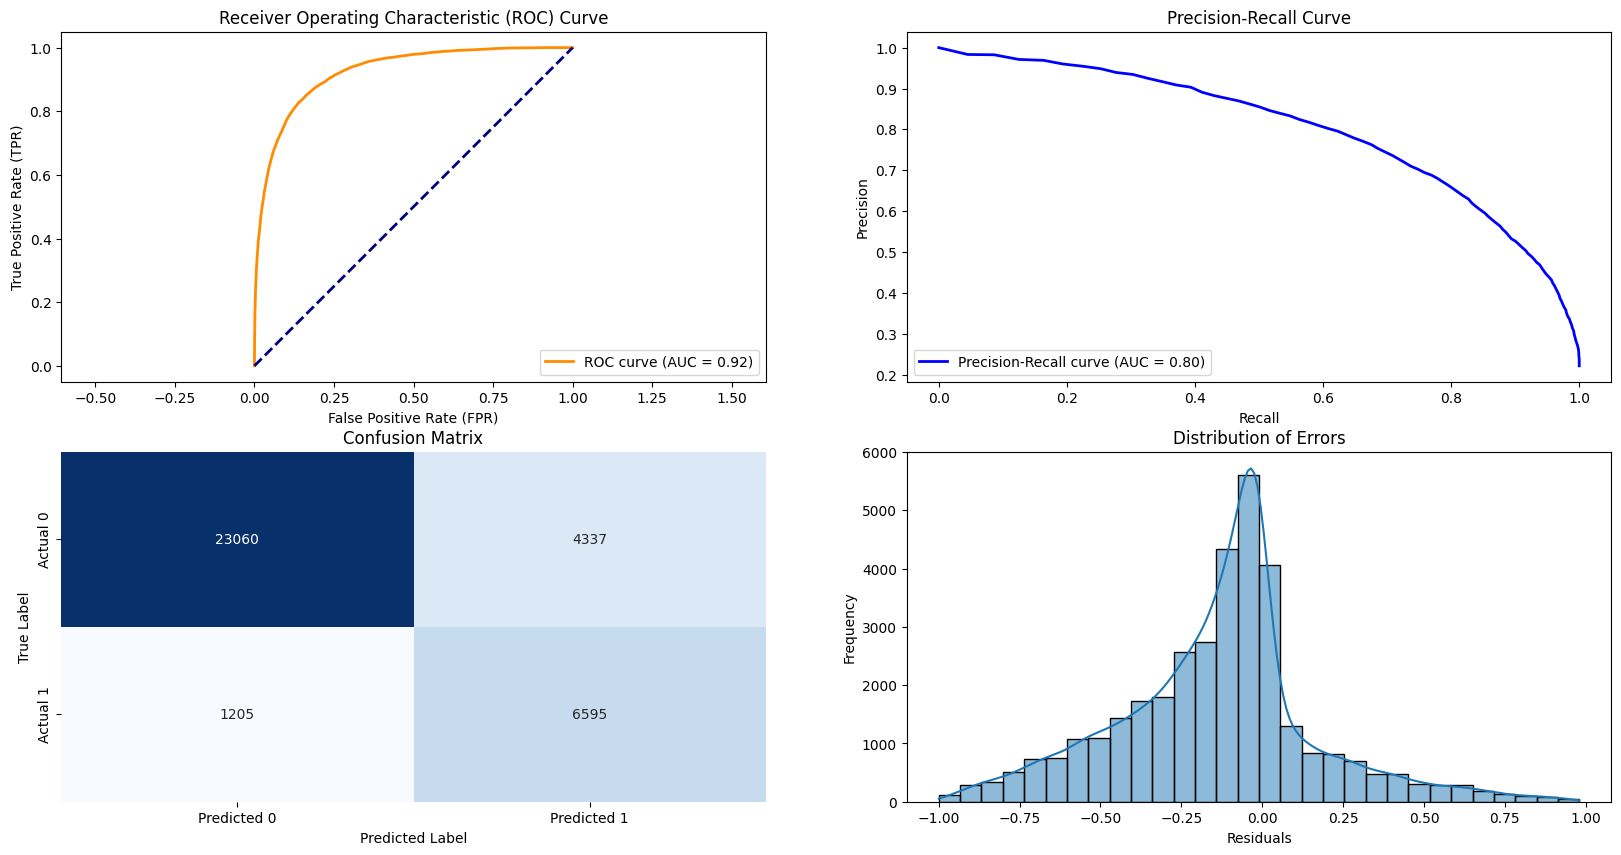

In [64]:
model = Model(RandomForestClassifier(), name='RF Undersample', scaled=True, resample='under')
model.fit()
model.visualize_metrics()

In [65]:
metrics_RF_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_RF_under.to_frame().T])
print(metrics_RF_under)

Accuracy                                 0.842543
Precision                                0.603275
Recall                                   0.845513
F1-Score                                 0.704143
ROC AUC                                  0.923195
Confusion Matrix    [[23060, 4337], [1205, 6595]]
PR AUC                                   0.798911
Name                               RF Undersample
dtype: object


## KNN
The K-Nearest Neighbors (K-NN) algorithm is a simple and intuitive supervised machine learning method used for both classification and regression tasks. It operates based on the principle that similar data points tend to share common characteristics and are often found close to each other in the feature space.

### No Resample

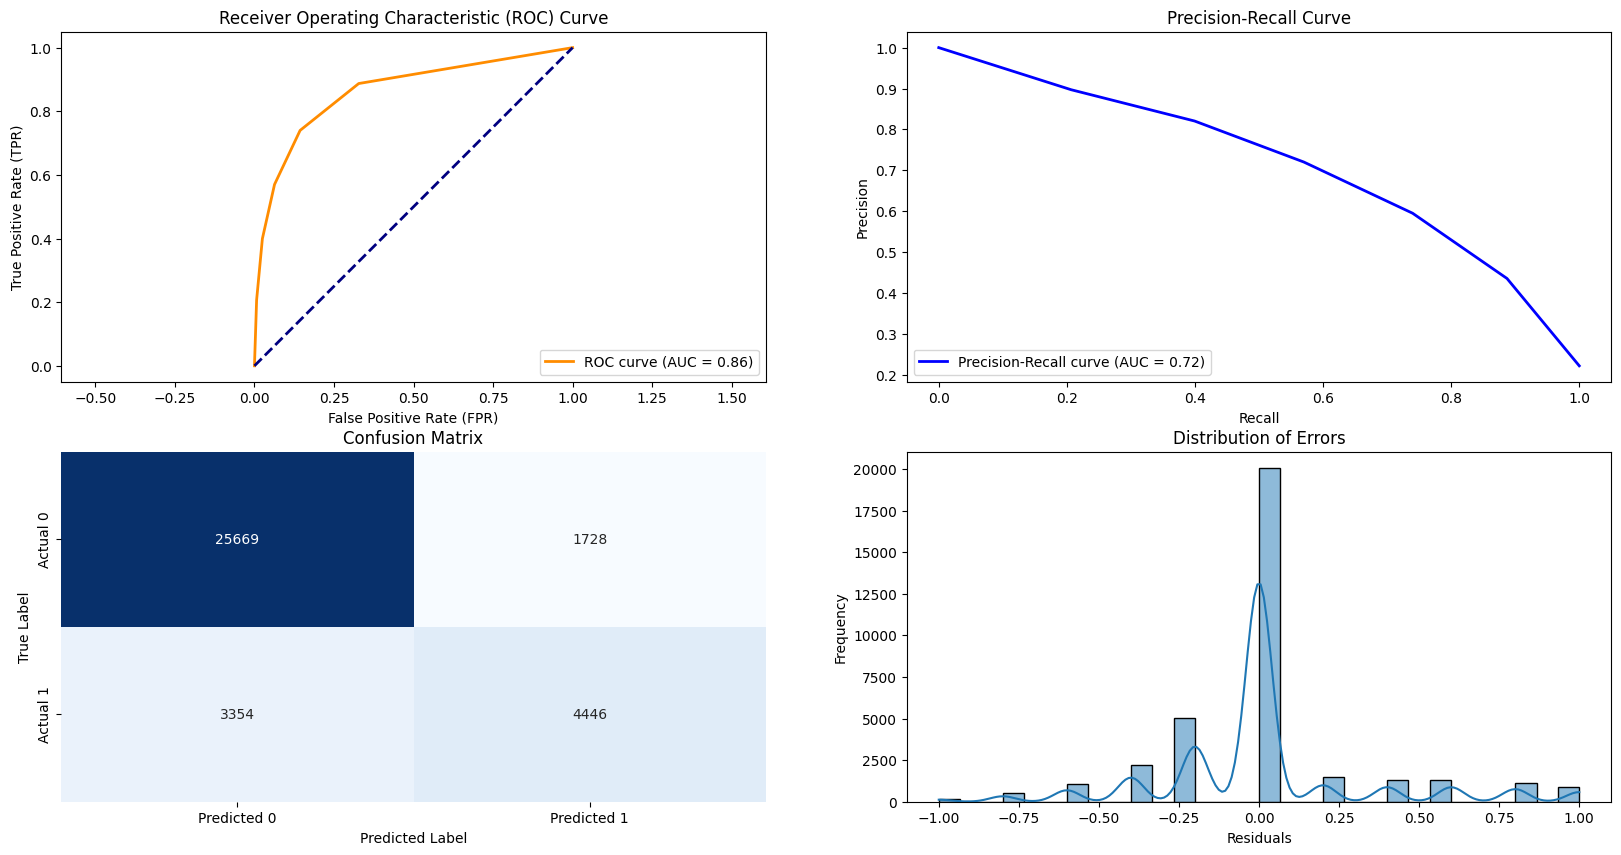

In [66]:
model = Model(KNeighborsClassifier(),'KNN No Resample', scaled=True, resample = None)
model.fit()
model.visualize_metrics()

In [67]:
metrics_KNN_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_KNN_no_resample.to_frame().T])
print(metrics_KNN_no_resample)

Accuracy                                 0.855613
Precision                                0.720117
Recall                                       0.57
F1-Score                                 0.636325
ROC AUC                                  0.861607
Confusion Matrix    [[25669, 1728], [3354, 4446]]
PR AUC                                   0.656541
Name                              KNN No Resample
dtype: object


### SMOTE

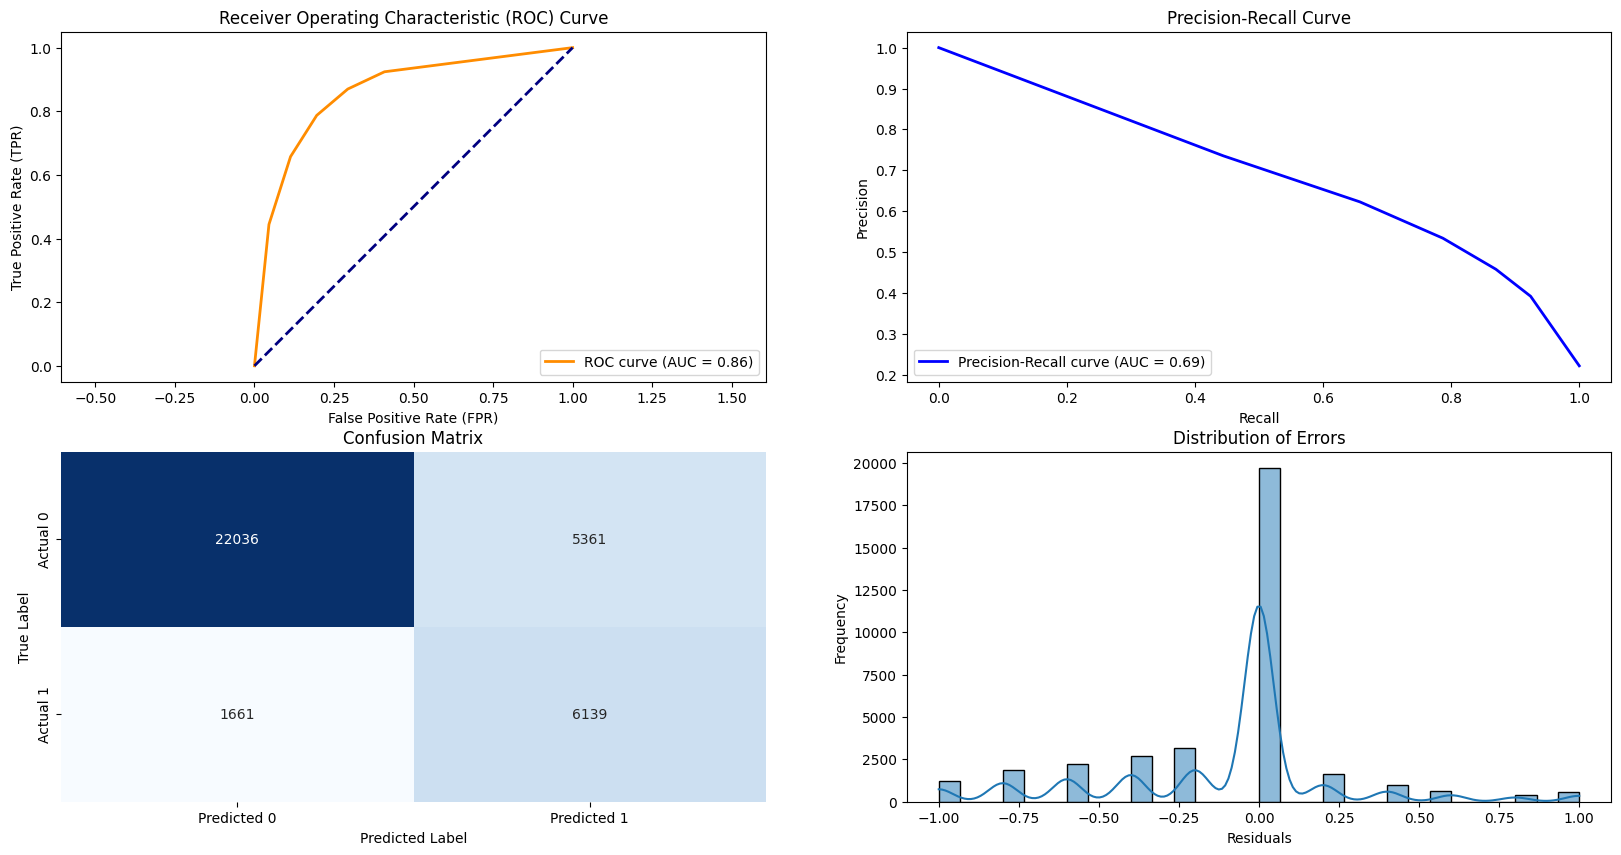

In [68]:
model = Model(KNeighborsClassifier(),'KNN SMOTE', scaled=True, resample = 'smote')
model.fit()
model.visualize_metrics()

In [69]:
metrics_KNN_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_KNN_smote.to_frame().T])
print(metrics_KNN_smote)

Accuracy                                 0.800494
Precision                                0.533826
Recall                                   0.787051
F1-Score                                 0.636166
ROC AUC                                  0.860175
Confusion Matrix    [[22036, 5361], [1661, 6139]]
PR AUC                                    0.60457
Name                                    KNN SMOTE
dtype: object


### Undersample

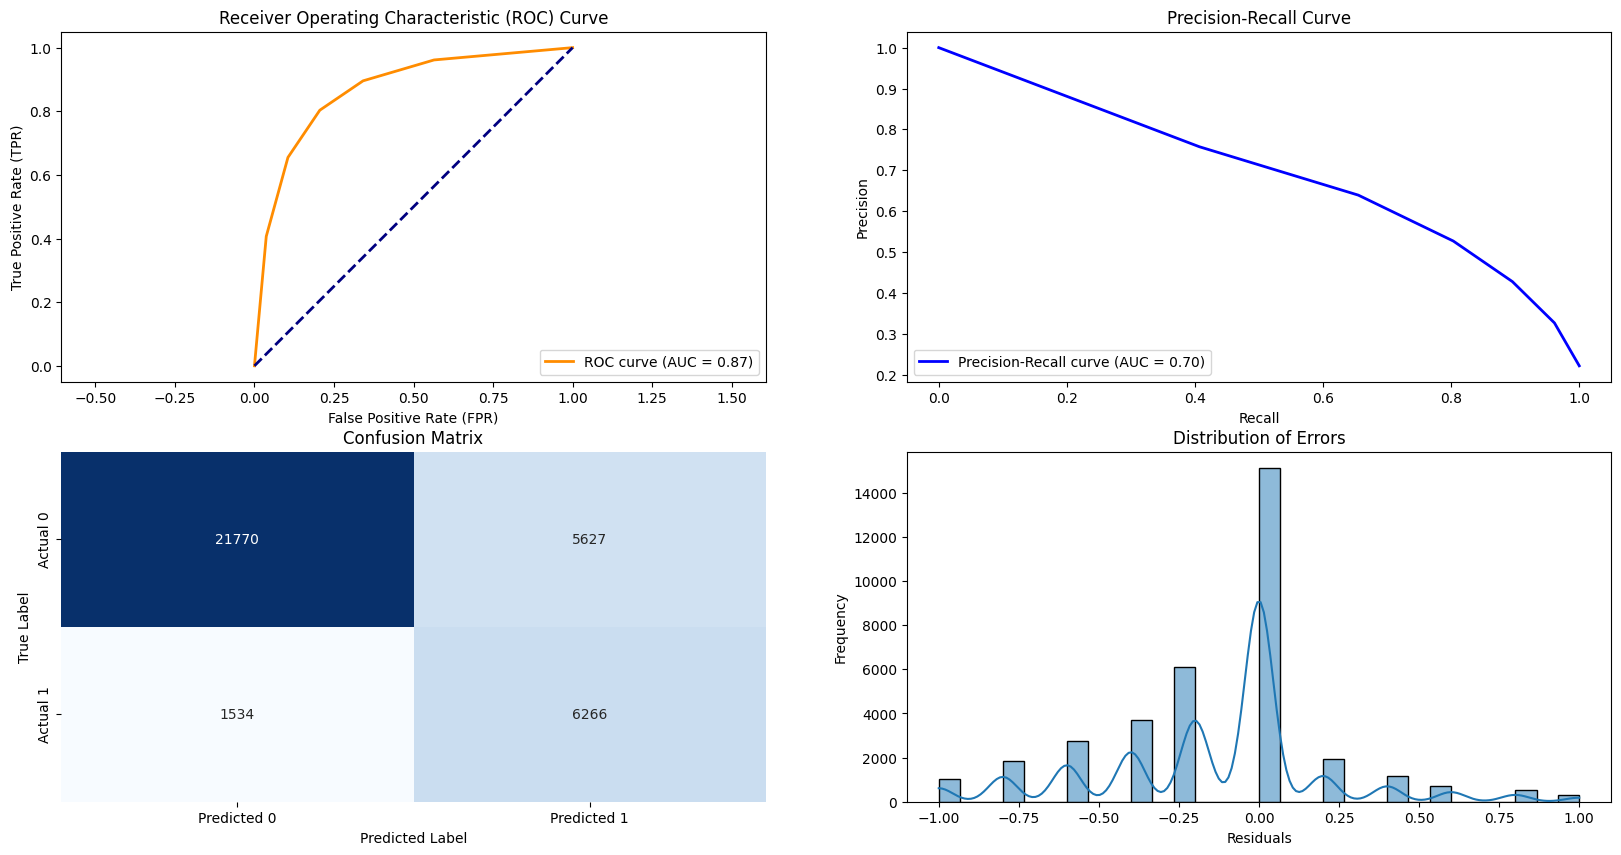

In [70]:
model = Model(KNeighborsClassifier(),'KNN Undersample', scaled=True, resample = 'under')
model.fit()
model.visualize_metrics()

In [71]:
metrics_KNN_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_KNN_under.to_frame().T])
print(metrics_KNN_under)

Accuracy                                 0.796545
Precision                                0.526865
Recall                                   0.803333
F1-Score                                 0.636368
ROC AUC                                  0.866511
Confusion Matrix    [[21770, 5627], [1534, 6266]]
PR AUC                                   0.614456
Name                              KNN Undersample
dtype: object


## Gradient Boosting Classifier
Gradient Boosting is an ensemble learning technique that combines the predictions of multiple weak learners (typically decision trees) to create a strong predictive model. The Gradient Boosting Classifier, specifically, is used for classification tasks.

Here's a brief description of the Gradient Boosting Classifier:
- **Base Learners (Weak Models)**: The algorithm starts with an initial weak learner, often a shallow decision tree. The model initially makes predictions, and the errors or residuals (the differences between predicted and actual values) are identified.

- **Gradient Descent Optimization**: In subsequent iterations, new weak learners are added to the ensemble, and they focus on correcting the errors made by the existing ensemble. The optimization process is akin to descending a gradient in the error space, hence the name "gradient boosting."

- **Weighted Contributions**: Each weak learner contributes to the final prediction with a certain weight. The weights are determined during the training process, and they depend on the contribution of each learner in minimizing the overall prediction error.

- **Shrinkage (Learning Rate)**: A hyperparameter called the learning rate controls the contribution of each weak learner. A smaller learning rate requires more weak learners but often leads to better generalization.

- **Regularization**: Gradient Boosting includes regularization techniques to prevent overfitting. This may involve constraining the complexity of the individual weak learners or introducing penalties for large weights.

- **Prediction**: The final prediction is made by aggregating the predictions of all weak learners, and the class with the majority of votes is selected as the predicted class for classification tasks.

### No Resample

In [ ]:
from scipy.stats import uniform

param_dist = {
    'n_estimators': [500, 800, 1000], # Number of trees in the Gradient Boosting forest. 
    'learning_rate': uniform(0.01, 0.3), # Learning rate, which determines the update of each tree 
    'max_depth': [3, 5, 7],
    'min_samples_split': [10, 20, 40],
    'min_samples_leaf': [20, 50, 70],
    'max_features': ['sqrt', 'log2']
}

gb = GradientBoostingClassifier(random_state=42)

random_search = RandomizedSearchCV(gb, param_distributions=param_dist, 
                                   n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train_scaled, y_train)
best_gb_model = random_search.best_estimator_

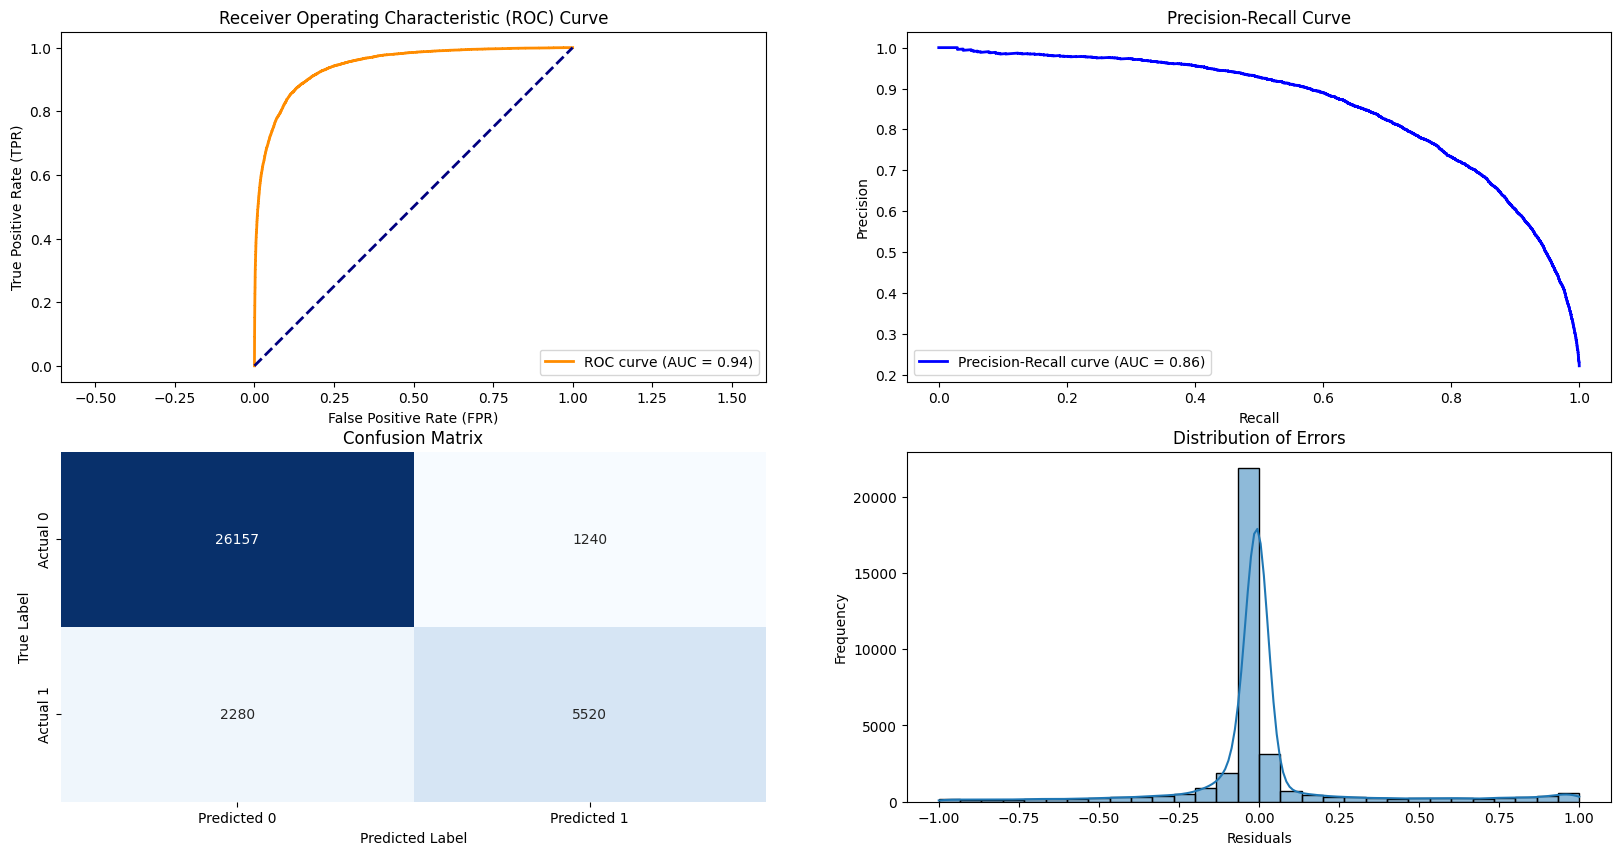

In [73]:
model = Model(best_gb_model, name='Gradient Boosting No Resample', scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [74]:
metrics_GBC_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_GBC_no_resample.to_frame().T])
print(metrics_GBC_no_resample)

Accuracy                                 0.899991
Precision                                0.816568
Recall                                   0.707692
F1-Score                                 0.758242
ROC AUC                                   0.94288
Confusion Matrix    [[26157, 1240], [2280, 5520]]
PR AUC                                   0.856161
Name                Gradient Boosting No Resample
dtype: object


### SMOTE

In [ ]:

param_dist = {
    'n_estimators': [500, 800, 1000],
    'learning_rate': uniform(0.01, 0.3),  
    'max_depth': [3, 5, 7],
    'min_samples_split': [10, 20, 40],
    'min_samples_leaf': [20, 50, 70],
    'max_features': ['sqrt', 'log2']
}

gb = GradientBoostingClassifier(random_state=42)

random_search = RandomizedSearchCV(gb, param_distributions=param_dist, 
                                   n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train_smote_scaled, y_train_smote)
best_gb_model = random_search.best_estimator_

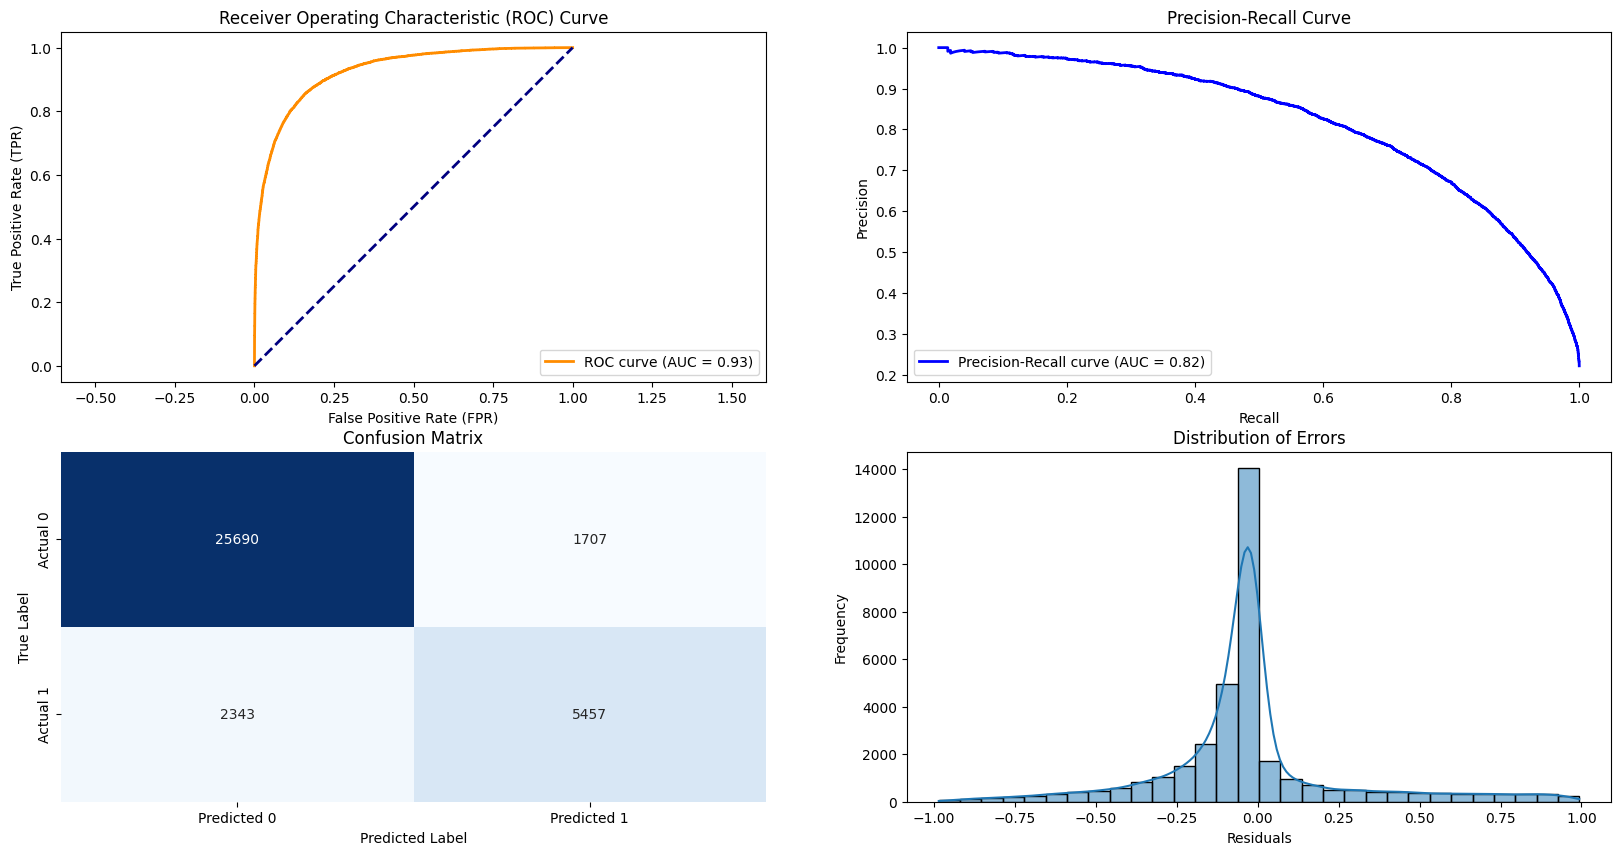

In [76]:
model = Model(best_gb_model, name='Gradient Boosting SMOTE', scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [77]:
metrics_GBC_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_GBC_smote.to_frame().T])
print(metrics_GBC_smote)

Accuracy                                 0.884933
Precision                                0.761725
Recall                                   0.699615
F1-Score                                  0.72935
ROC AUC                                  0.925584
Confusion Matrix    [[25690, 1707], [2343, 5457]]
PR AUC                                   0.817516
Name                      Gradient Boosting SMOTE
dtype: object


### Undersample

In [ ]:

param_dist = {
    'n_estimators': [500, 800, 1000],
    'learning_rate': uniform(0.01, 0.3),  
    'max_depth': [3, 5, 7],
    'min_samples_split': [10, 20, 40],
    'min_samples_leaf': [20, 50, 70],
    'max_features': ['sqrt', 'log2']
}

gb = GradientBoostingClassifier(random_state=42)

random_search = RandomizedSearchCV(gb, param_distributions=param_dist, 
                                   n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train_under_scaled, y_train_under)
best_gb_model = random_search.best_estimator_

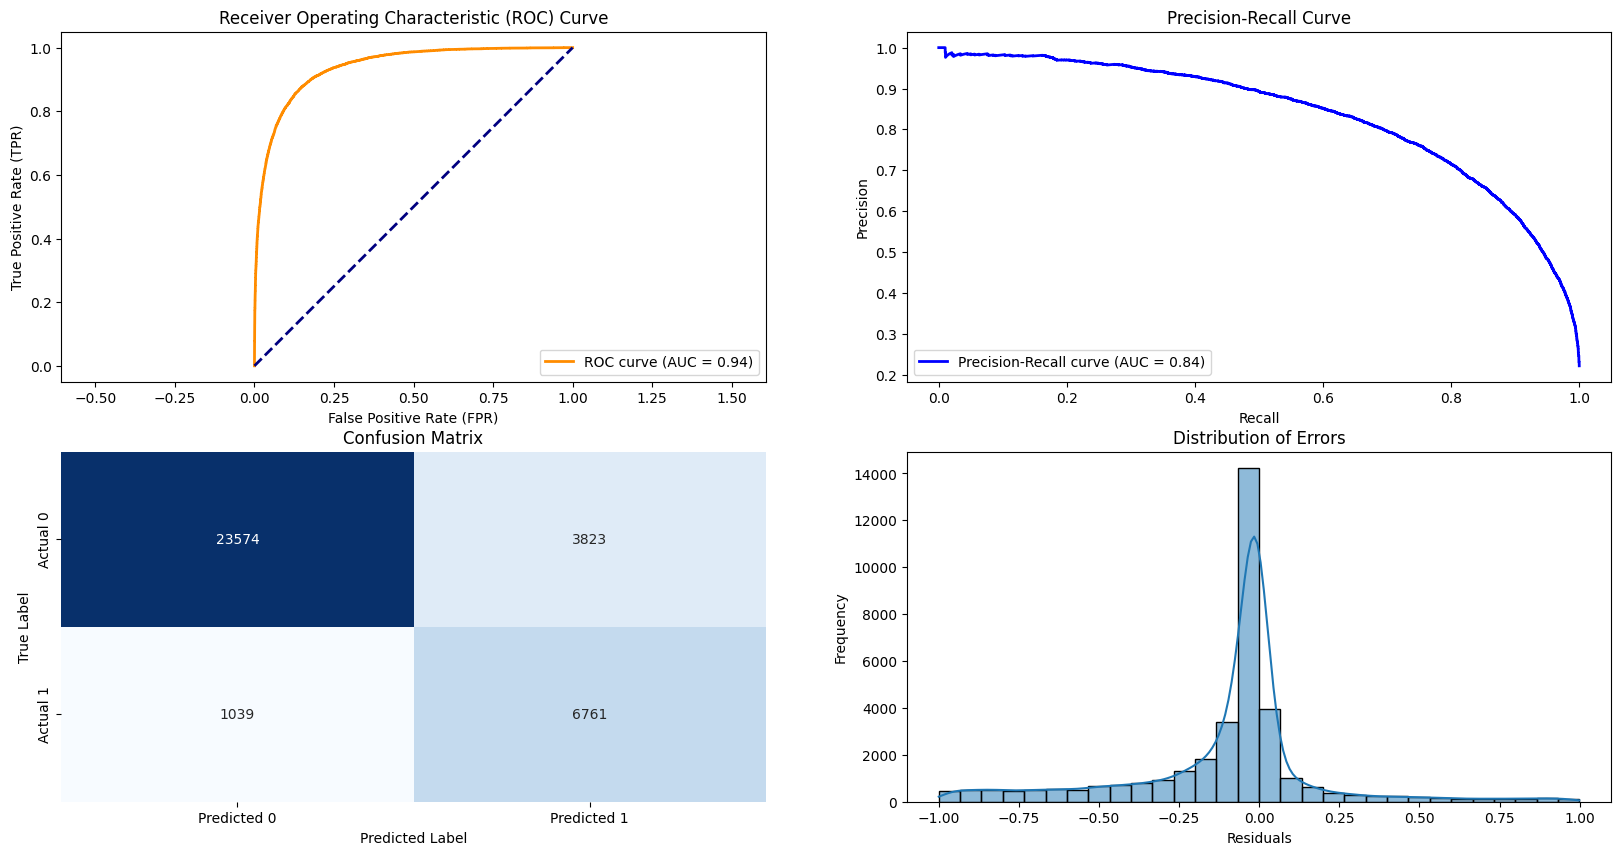

In [79]:
model = Model(best_gb_model, name='Gradient Boosting Undersample', scaled=True, resample='under')
model.fit()
model.visualize_metrics()

In [80]:
metrics_GBC_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_GBC_under.to_frame().T])
print(metrics_GBC_under)

Accuracy                                 0.861863
Precision                                0.638794
Recall                                   0.866795
F1-Score                                 0.735531
ROC AUC                                  0.938293
Confusion Matrix    [[23574, 3823], [1039, 6761]]
PR AUC                                   0.835885
Name                Gradient Boosting Undersample
dtype: object


## XGBoost
XGBoost builds upon the principles of traditional gradient boosting while introducing several enhancements and optimizations that make it a go-to choice for predictive modeling tasks.
It is characterised by improvements over GBM:
- XGBoost is known for its efficiency in optimizing against the loss function by utilizing the Hessian information, making it more efficient in training compared to GBM.

- It leverages parallel processing techniques and optimized algorithms to achieve faster training times and lower memory usage, making it ideal for large-scale datasets.

- XGBoost provides robust regularization capabilities, including L1 regularization (Lasso) and L2 regularization (Ridge), which help prevent overfitting and improve model generalization. L1 Regularization tries to minimize the feature weights or coefficients to zero (effectively becoming a feature selection), while L2 Regularization tries to shrink the coefficient evenly (help to deal with multicollinearity).  By implementing both regularizations, XGBoost could avoid overfitting better than the GBM.

- XGBoost offers built-in support for handling missing values during training and prediction, simplifying the preprocessing pipeline and reducing the need for manual imputation techniques.

### No Resample

In [81]:
param_dist = {
    'n_estimators': [500, 800, 1000],  
    'learning_rate': [0.01, 0.05, 0.1],  
    'max_depth': [5, 7, 9],  
    'subsample': [0.6, 0.8, 1.0], # Percentage of samples used to train each tree 
    'colsample_bytree': [0.6, 0.8, 1.0], # Percentage of features selected for each tree
    'gamma': [0, 0.1, 0.2, 0.3], # Minimum gain that must be obtained to split a node, useful for reducing overfitting.
    'reg_alpha': [0, 0.01, 0.1, 1], # L1 regularisation  
    'reg_lambda': [0, 0.01, 0.1, 1] # L2 regularisation
}

xgb_model = XGBClassifier(objective='binary:logistic', use_label_encoder=False)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  
    scoring='roc_auc',  
    cv=4,  
    verbose=1,
    random_state=42,
    n_jobs=-1  
)
random_search.fit(X_train_scaled, y_train)
best_xgb_model = random_search.best_estimator_

Fitting 4 folds for each of 50 candidates, totalling 200 fits


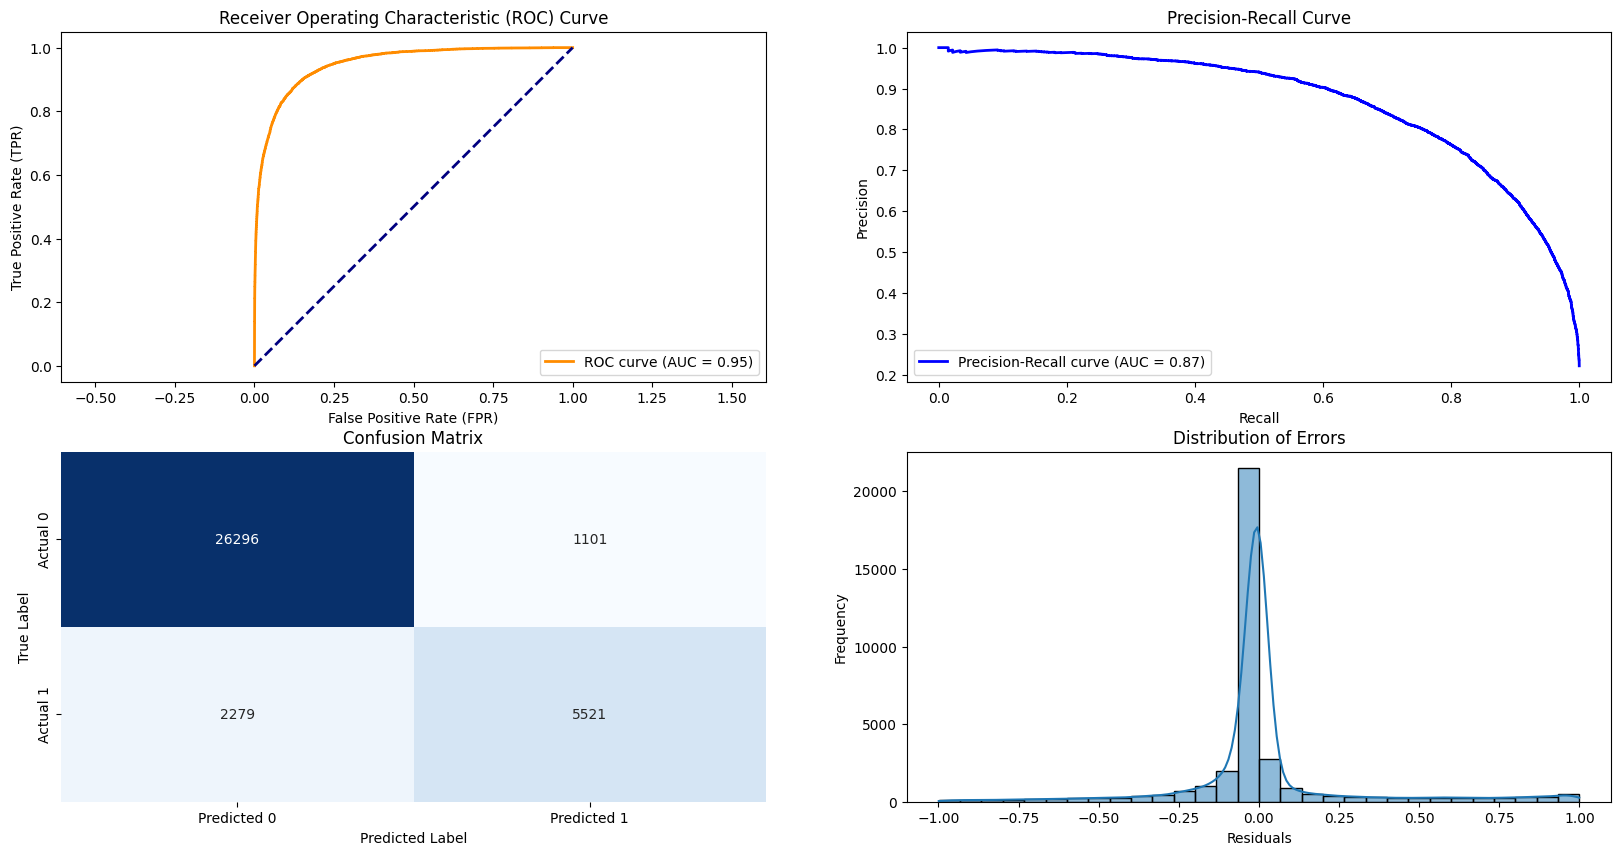

In [82]:
model = Model(best_xgb_model, name='XGB No Resample',
               scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [83]:
metrics_XG_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_XG_no_resample.to_frame().T])
print(metrics_XG_no_resample)

Accuracy                                 0.903969
Precision                                0.833736
Recall                                   0.707821
F1-Score                                 0.765636
ROC AUC                                   0.94877
Confusion Matrix    [[26296, 1101], [2279, 5521]]
PR AUC                                     0.8683
Name                              XGB No Resample
dtype: object


### SMOTE

In [84]:
param_dist = {
    'n_estimators': [500, 800, 1000],  
    'learning_rate': [0.01, 0.05, 0.1],  
    'max_depth': [5, 7, 9],  
    'subsample': [0.6, 0.8, 1.0],  
    'colsample_bytree': [0.6, 0.8, 1.0],  
    'gamma': [0, 0.1, 0.2, 0.3],  
    'reg_alpha': [0, 0.01, 0.1, 1],  
    'reg_lambda': [0, 0.01, 0.1, 1]  
}

xgb_model = XGBClassifier(objective='binary:logistic', use_label_encoder=False)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  
    scoring='roc_auc',  
    cv=4,  
    verbose=1,
    random_state=42,
    n_jobs=-1 
)

random_search.fit(X_train_smote_scaled, y_train_smote)
best_xgb_model = random_search.best_estimator_

Fitting 4 folds for each of 50 candidates, totalling 200 fits


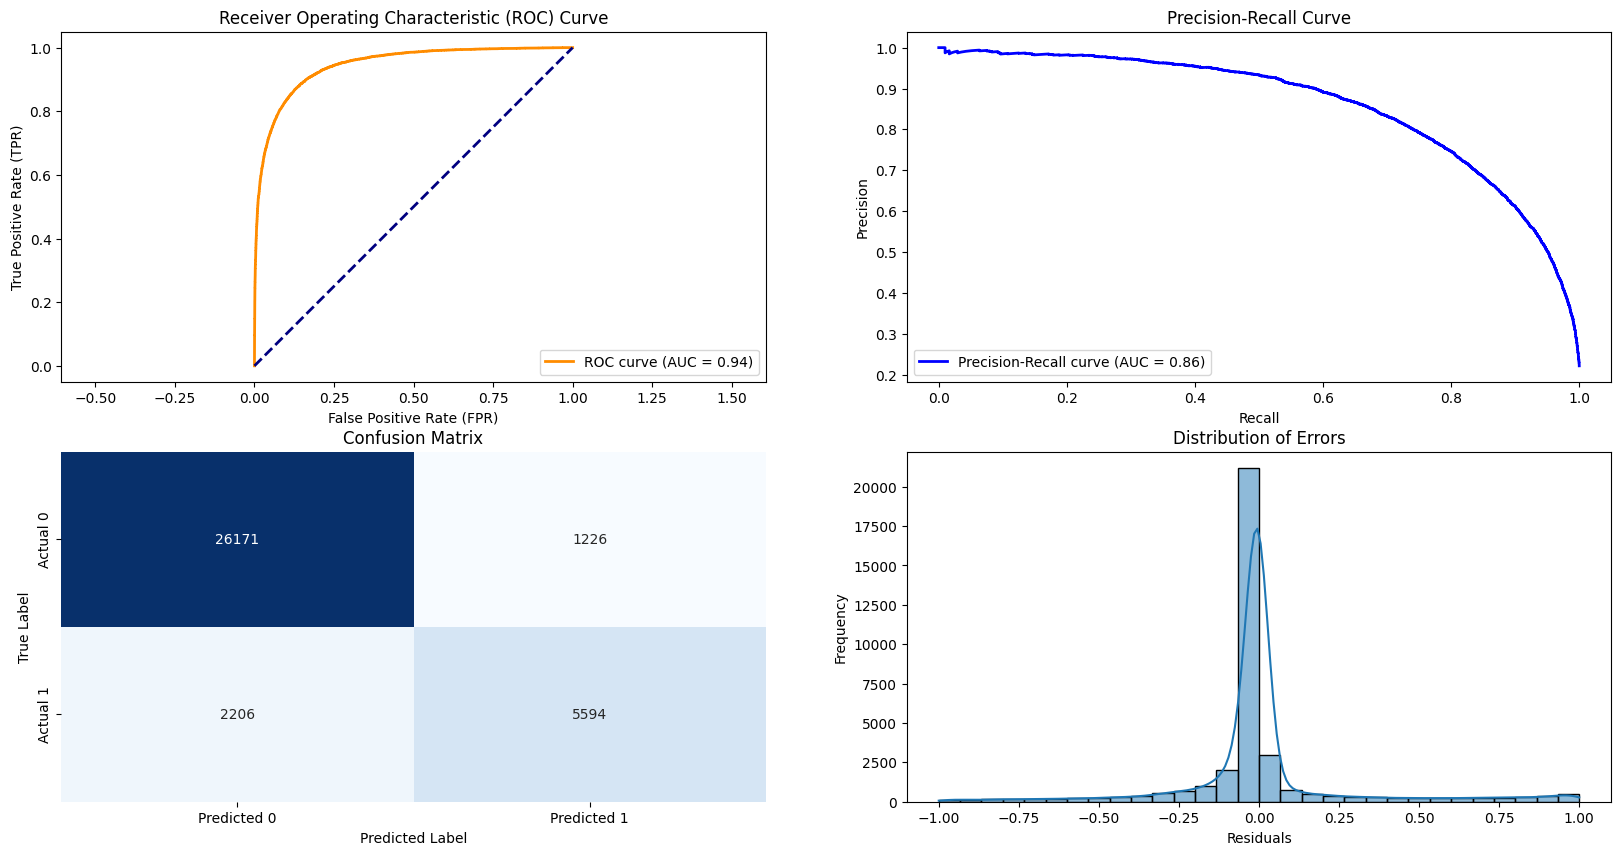

In [85]:
model = Model(best_xgb_model, name='XGB Smote',
               scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [86]:
metrics_XG_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_XG_smote.to_frame().T])
print(metrics_XG_smote)

Accuracy                                 0.902492
Precision                                0.820235
Recall                                   0.717179
F1-Score                                 0.765253
ROC AUC                                  0.944331
Confusion Matrix    [[26171, 1226], [2206, 5594]]
PR AUC                                   0.859232
Name                                    XGB Smote
dtype: object


### Undersample

In [87]:
param_dist = {
    'n_estimators': [500, 800, 1000],  
    'learning_rate': [0.01, 0.05, 0.1],  
    'max_depth': [5, 7, 9],  
    'subsample': [0.6, 0.8, 1.0],  
    'colsample_bytree': [0.6, 0.8, 1.0],  
    'gamma': [0, 0.1, 0.2, 0.3],  
    'reg_alpha': [0, 0.01, 0.1, 1],  
    'reg_lambda': [0, 0.01, 0.1, 1]  
}

xgb_model = XGBClassifier(objective='binary:logistic', use_label_encoder=False)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  
    scoring='roc_auc',  
    cv=4,  
    verbose=1,
    random_state=42,
    n_jobs=-1  
)

random_search.fit(X_train_under_scaled, y_train_under)
best_xgb_model = random_search.best_estimator_

Fitting 4 folds for each of 50 candidates, totalling 200 fits


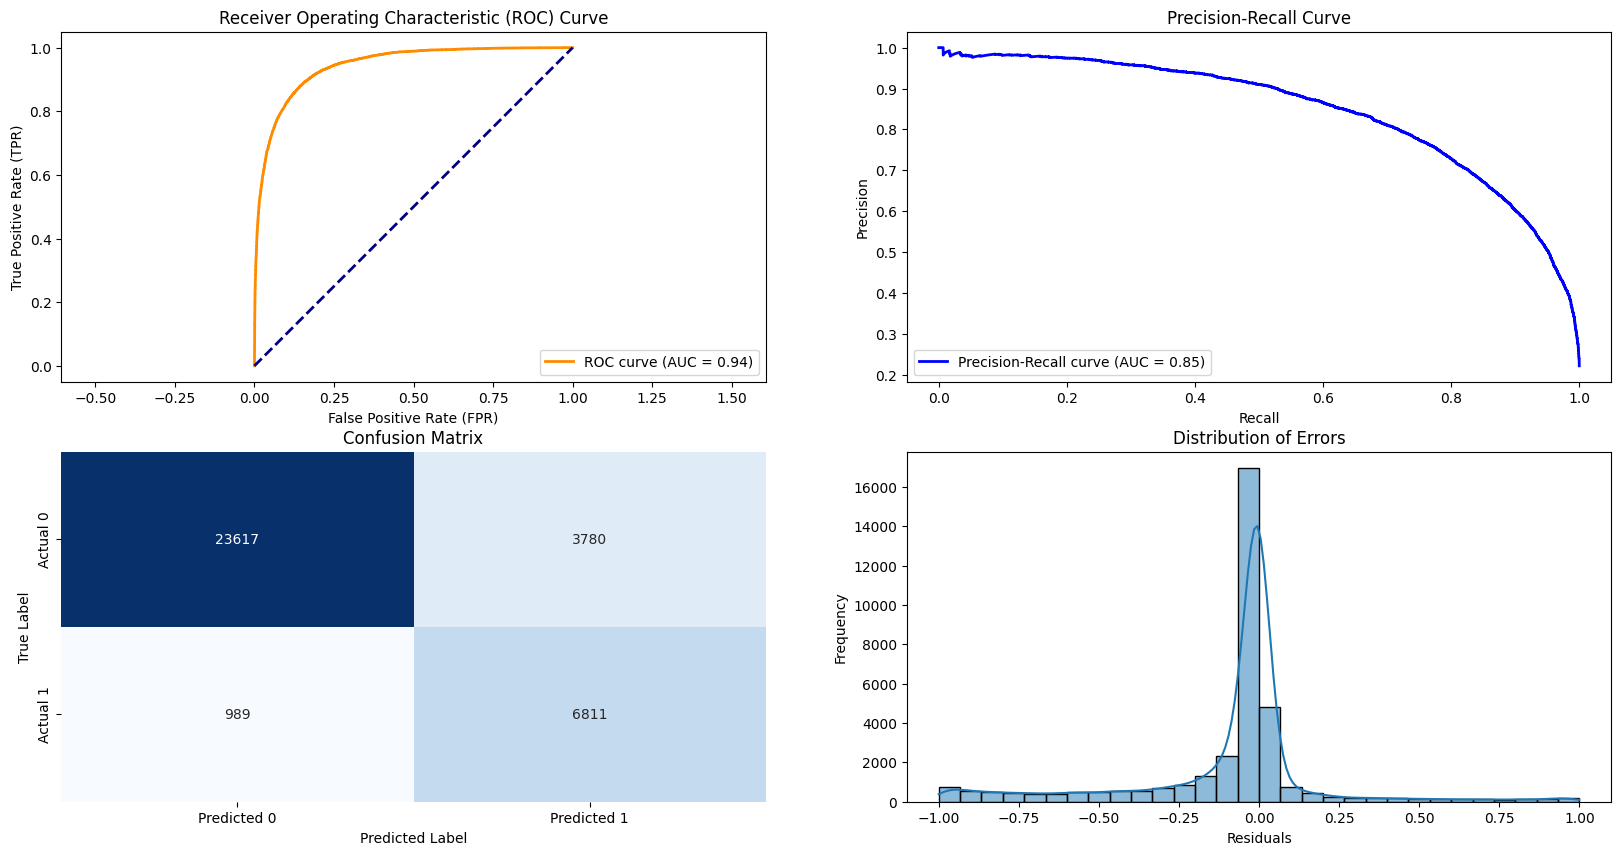

In [88]:
model = Model(best_xgb_model, name='XGB Undersample',
               scaled=True, resample='under')
model.fit()
model.visualize_metrics()

In [89]:
metrics_XG_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_XG_under.to_frame().T])
print(metrics_XG_under)

Accuracy                                0.864505
Precision                               0.643093
Recall                                  0.873205
F1-Score                                0.740688
ROC AUC                                 0.942543
Confusion Matrix    [[23617, 3780], [989, 6811]]
PR AUC                                  0.845877
Name                             XGB Undersample
dtype: object


## CatBoost
Catboost is a variant of gradient boosting that can handle both categorical and numerical features. It does not require any feature encodings techniques like One-Hot Encoder or Label Encoder to convert categorical features into numerical features. It also uses an algorithm called symmetric weighted quantile sketch(SWQS) which automatically handles the missing values in the dataset to reduce overfitting and improve the overall performance of the dataset. 

The main difference from XGB is that CatBoost uses *Symmetric tree growth*, wherease in XGB and GBC trees are grown *level-wise*. Symmetric trees are grown by splitting all leaves at the same depth identically

### No Resample

In [ ]:

model = cb.CatBoostClassifier()

param_grid = {
    'iterations': [500, 800],
    'learning_rate': [0.01, 0.1],
    'depth': [6, 8],
    'l2_leaf_reg': [1, 3],
}

random_search = RandomizedSearchCV(model, 
                                   param_distributions=param_grid, 
                                   n_iter=50, 
                                   cv=3, 
                                   scoring='roc_auc', 
                                   n_jobs=-1, 
                                   random_state=42)

random_search.fit(X_train_scaled, y_train)

best_model = random_search.best_estimator_

0:	learn: 0.6093560	total: 60.1ms	remaining: 48s
1:	learn: 0.5460507	total: 163ms	remaining: 1m 4s
2:	learn: 0.4955955	total: 204ms	remaining: 54.2s
3:	learn: 0.4611444	total: 242ms	remaining: 48.1s
4:	learn: 0.4352981	total: 294ms	remaining: 46.7s
5:	learn: 0.4137541	total: 335ms	remaining: 44.3s
6:	learn: 0.3962727	total: 369ms	remaining: 41.8s
7:	learn: 0.3833516	total: 405ms	remaining: 40.1s
8:	learn: 0.3730324	total: 448ms	remaining: 39.4s
9:	learn: 0.3645556	total: 486ms	remaining: 38.4s
10:	learn: 0.3577224	total: 537ms	remaining: 38.5s
11:	learn: 0.3508124	total: 571ms	remaining: 37.5s
12:	learn: 0.3455012	total: 602ms	remaining: 36.4s
13:	learn: 0.3406784	total: 640ms	remaining: 35.9s
14:	learn: 0.3371268	total: 673ms	remaining: 35.2s
15:	learn: 0.3340424	total: 704ms	remaining: 34.5s
16:	learn: 0.3316372	total: 736ms	remaining: 33.9s
17:	learn: 0.3290862	total: 772ms	remaining: 33.5s
18:	learn: 0.3270983	total: 802ms	remaining: 32.9s
19:	learn: 0.3250355	total: 833ms	remainin

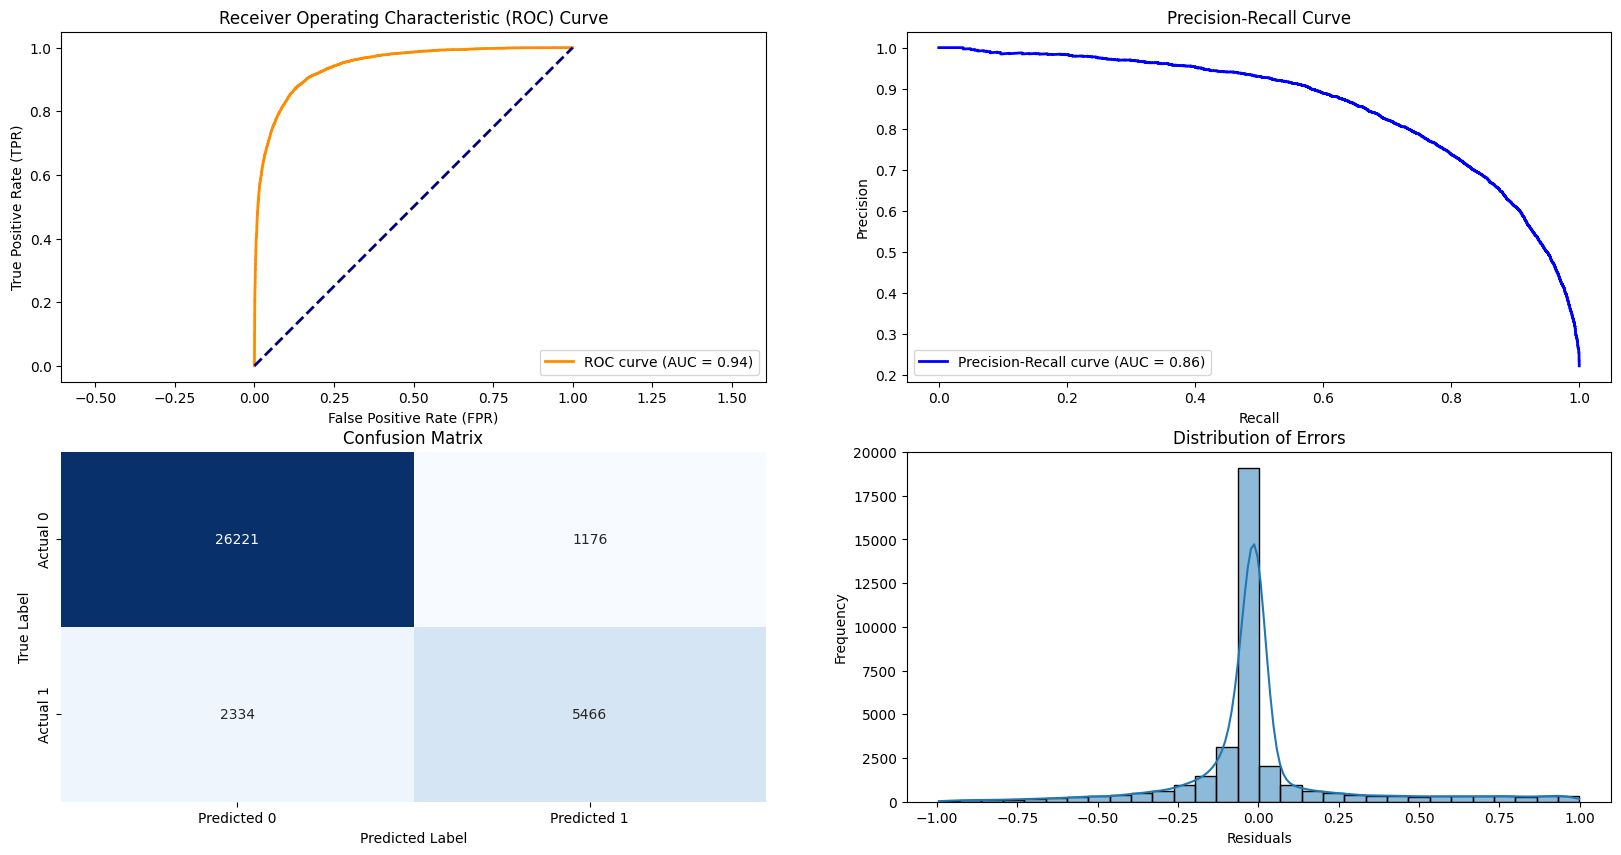

In [91]:
model = Model(best_model, 
              name='CatBoost No Resample', scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [92]:
metrics_CB_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_CB_no_resample.to_frame().T])
print(metrics_CB_no_resample)

Accuracy                                 0.900276
Precision                                0.822945
Recall                                   0.700769
F1-Score                                 0.756959
ROC AUC                                  0.944194
Confusion Matrix    [[26221, 1176], [2334, 5466]]
PR AUC                                   0.857553
Name                         CatBoost No Resample
dtype: object


### SMOTE

In [ ]:

model = cb.CatBoostClassifier()


param_grid = {
    'iterations': [500, 800],
    'learning_rate': [0.01, 0.1],
    'depth': [6, 8],
    'l2_leaf_reg': [1, 3],
}


random_search = RandomizedSearchCV(model, 
                                   param_distributions=param_grid, 
                                   n_iter=50, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42)

random_search.fit(X_train_smote_scaled, y_train_smote)


best_model = random_search.best_estimator_

0:	learn: 0.6099026	total: 51.4ms	remaining: 41s
1:	learn: 0.5532255	total: 106ms	remaining: 42.5s
2:	learn: 0.5154515	total: 163ms	remaining: 43.2s
3:	learn: 0.4880095	total: 215ms	remaining: 42.9s
4:	learn: 0.4660772	total: 275ms	remaining: 43.8s
5:	learn: 0.4482306	total: 327ms	remaining: 43.2s
6:	learn: 0.4333606	total: 391ms	remaining: 44.3s
7:	learn: 0.4215494	total: 448ms	remaining: 44.4s
8:	learn: 0.4108660	total: 521ms	remaining: 45.8s
9:	learn: 0.4024430	total: 574ms	remaining: 45.3s
10:	learn: 0.3942660	total: 630ms	remaining: 45.2s
11:	learn: 0.3886520	total: 671ms	remaining: 44.1s
12:	learn: 0.3833159	total: 711ms	remaining: 43.1s
13:	learn: 0.3783549	total: 754ms	remaining: 42.3s
14:	learn: 0.3722025	total: 793ms	remaining: 41.5s
15:	learn: 0.3666764	total: 833ms	remaining: 40.8s
16:	learn: 0.3590580	total: 874ms	remaining: 40.3s
17:	learn: 0.3559080	total: 920ms	remaining: 40s
18:	learn: 0.3534769	total: 963ms	remaining: 39.6s
19:	learn: 0.3490681	total: 1.01s	remaining:

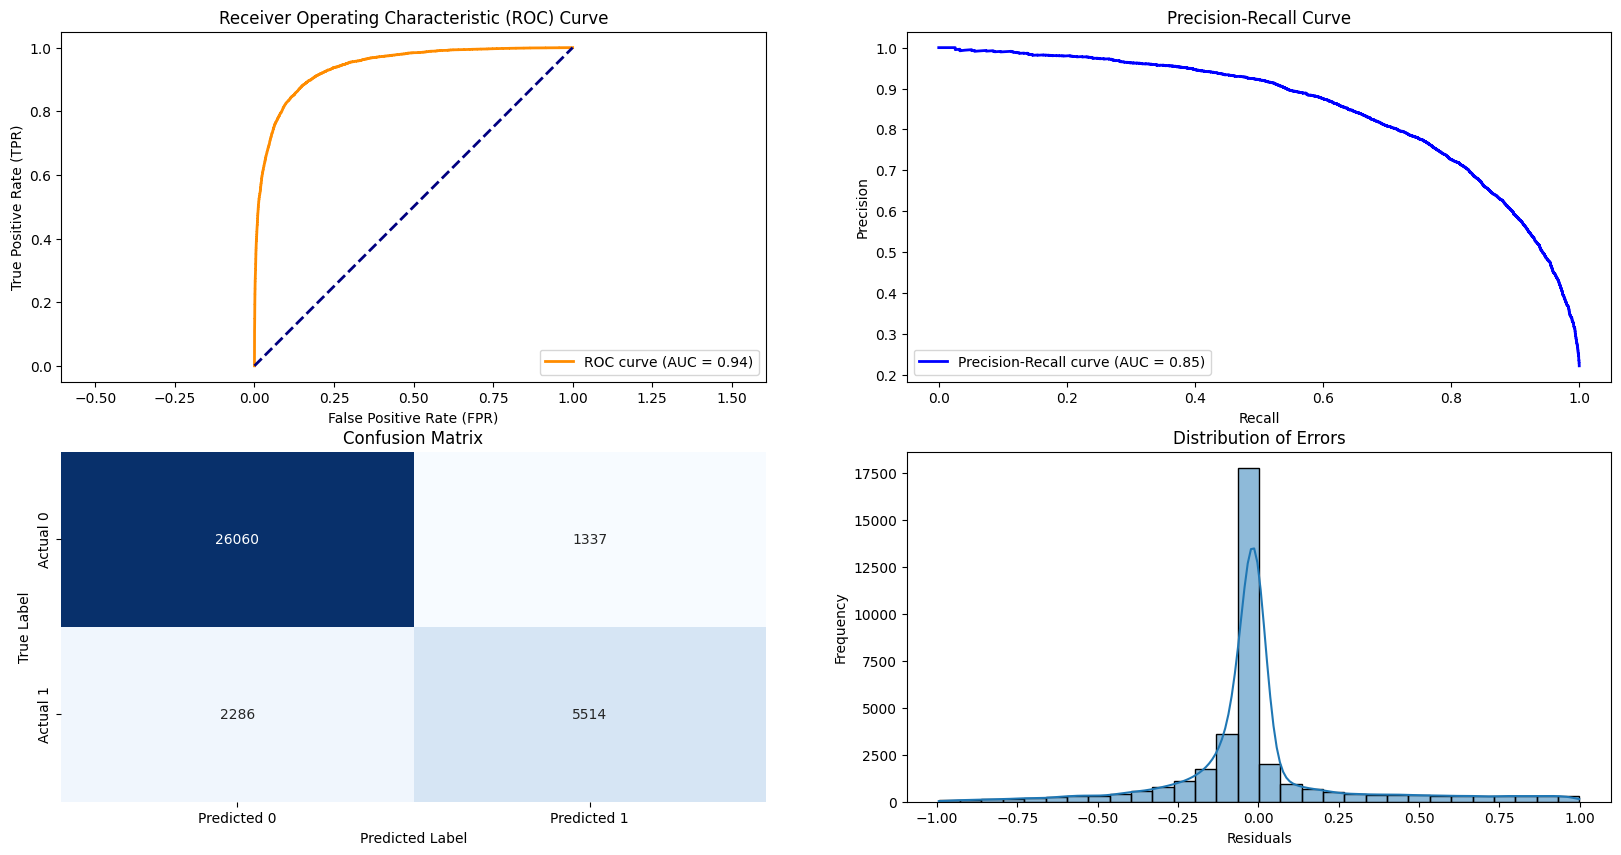

In [94]:
model = Model(best_model, 
              name='CatBoost SMOTE', scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [95]:
metrics_CB_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_CB_smote.to_frame().T])
print(metrics_CB_smote)

Accuracy                                 0.897065
Precision                                0.804846
Recall                                   0.706923
F1-Score                                 0.752713
ROC AUC                                  0.939834
Confusion Matrix    [[26060, 1337], [2286, 5514]]
PR AUC                                   0.848513
Name                               CatBoost SMOTE
dtype: object


### Undersample

In [ ]:

model = cb.CatBoostClassifier()

param_grid = {
    'iterations': [500, 800],
    'learning_rate': [0.01, 0.1],
    'depth': [6, 8],
    'l2_leaf_reg': [1, 3],
}


random_search = RandomizedSearchCV(model, 
                                   param_distributions=param_grid, 
                                   n_iter=50, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42)


random_search.fit(X_train_under_scaled, y_train_under)


best_model = random_search.best_estimator_

0:	learn: 0.6359767	total: 174ms	remaining: 2m 19s
1:	learn: 0.5934624	total: 220ms	remaining: 1m 27s
2:	learn: 0.5593115	total: 267ms	remaining: 1m 10s
3:	learn: 0.5325247	total: 317ms	remaining: 1m 3s
4:	learn: 0.5106991	total: 337ms	remaining: 53.5s
5:	learn: 0.4928608	total: 357ms	remaining: 47.2s
6:	learn: 0.4788878	total: 378ms	remaining: 42.8s
7:	learn: 0.4679174	total: 399ms	remaining: 39.5s
8:	learn: 0.4581464	total: 419ms	remaining: 36.8s
9:	learn: 0.4509284	total: 437ms	remaining: 34.5s
10:	learn: 0.4447961	total: 457ms	remaining: 32.8s
11:	learn: 0.4383503	total: 477ms	remaining: 31.3s
12:	learn: 0.4332667	total: 497ms	remaining: 30.1s
13:	learn: 0.4289115	total: 518ms	remaining: 29.1s
14:	learn: 0.4257528	total: 539ms	remaining: 28.2s
15:	learn: 0.4214981	total: 558ms	remaining: 27.4s
16:	learn: 0.4182524	total: 579ms	remaining: 26.6s
17:	learn: 0.4157777	total: 599ms	remaining: 26s
18:	learn: 0.4131613	total: 619ms	remaining: 25.5s
19:	learn: 0.4107833	total: 639ms	remain

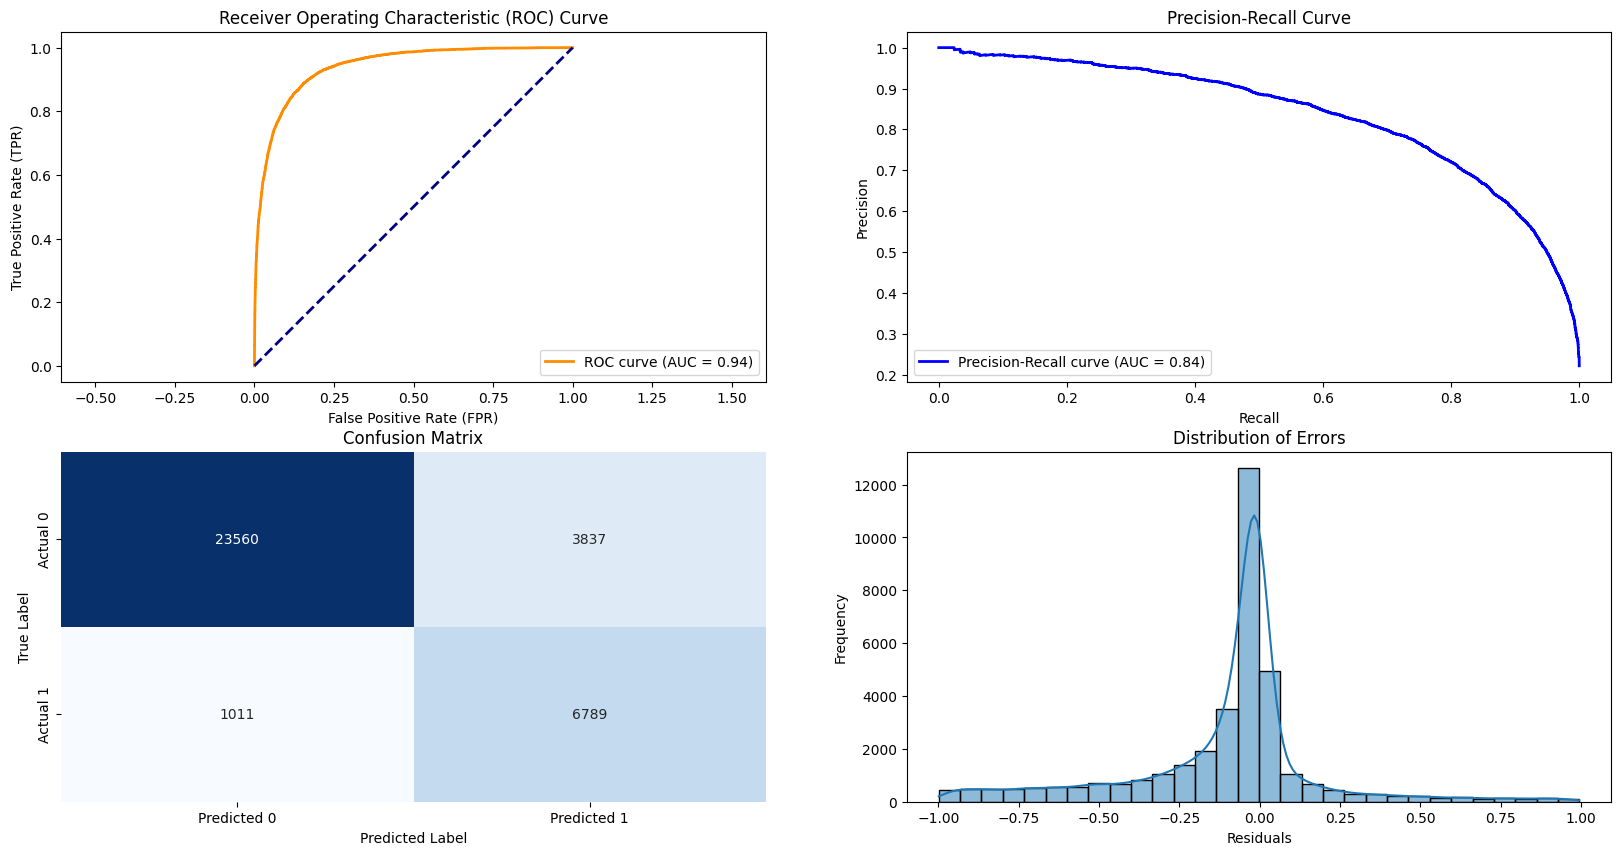

In [97]:
model = Model(best_model, 
              name='CatBoost Undersample', scaled=True, resample='under')
model.fit()
model.visualize_metrics()

In [98]:
metrics_CB_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_CB_under.to_frame().T])
print(metrics_CB_under)

Accuracy                                 0.862261
Precision                                0.638905
Recall                                   0.870385
F1-Score                                 0.736894
ROC AUC                                  0.939948
Confusion Matrix    [[23560, 3837], [1011, 6789]]
PR AUC                                   0.837157
Name                         CatBoost Undersample
dtype: object


## LightGBM
LightGBM stands for Light Gradient Boosting Machine, and it is designed to be fast and efficient. LightGBM has several advantages over other gradient boosting frameworks, such as XGBoost or CatBoost. Some of these advantages are:
- It supports categorical features directly, without the need for one-hot encoding or label encoding. (like CatBoost)

- It uses histogram-based algorithms, which reduce the number of split points and speed up the training process.

- It uses leaf-wise growth, which means it splits the tree by the leaf that has the maximum delta loss, rather than level-wise growth, which splits the tree by levels. This can result in better accuracy and lower overfitting. The difference is in the order in which the tree is expanded.

- It supports parallel and distributed learning, which can scale up to large datasets and clusters.

### No Resample

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

model = lgb.LGBMClassifier(objective="binary")

param_distributions = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [6, 8, 10, 12],
    'num_leaves': [20, 31, 40, 50],
    'min_child_samples': [20, 30, 40],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}


random_search = RandomizedSearchCV(model, param_distributions, n_iter=50, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42)


random_search.fit(X_train_scaled, y_train)


best_model_lgb = random_search.best_estimator_

[LightGBM] [Info] Number of positive: 23401, number of negative: 82189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 105590, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221621 -> initscore=-1.256243
[LightGBM] [Info] Start training from score -1.256243


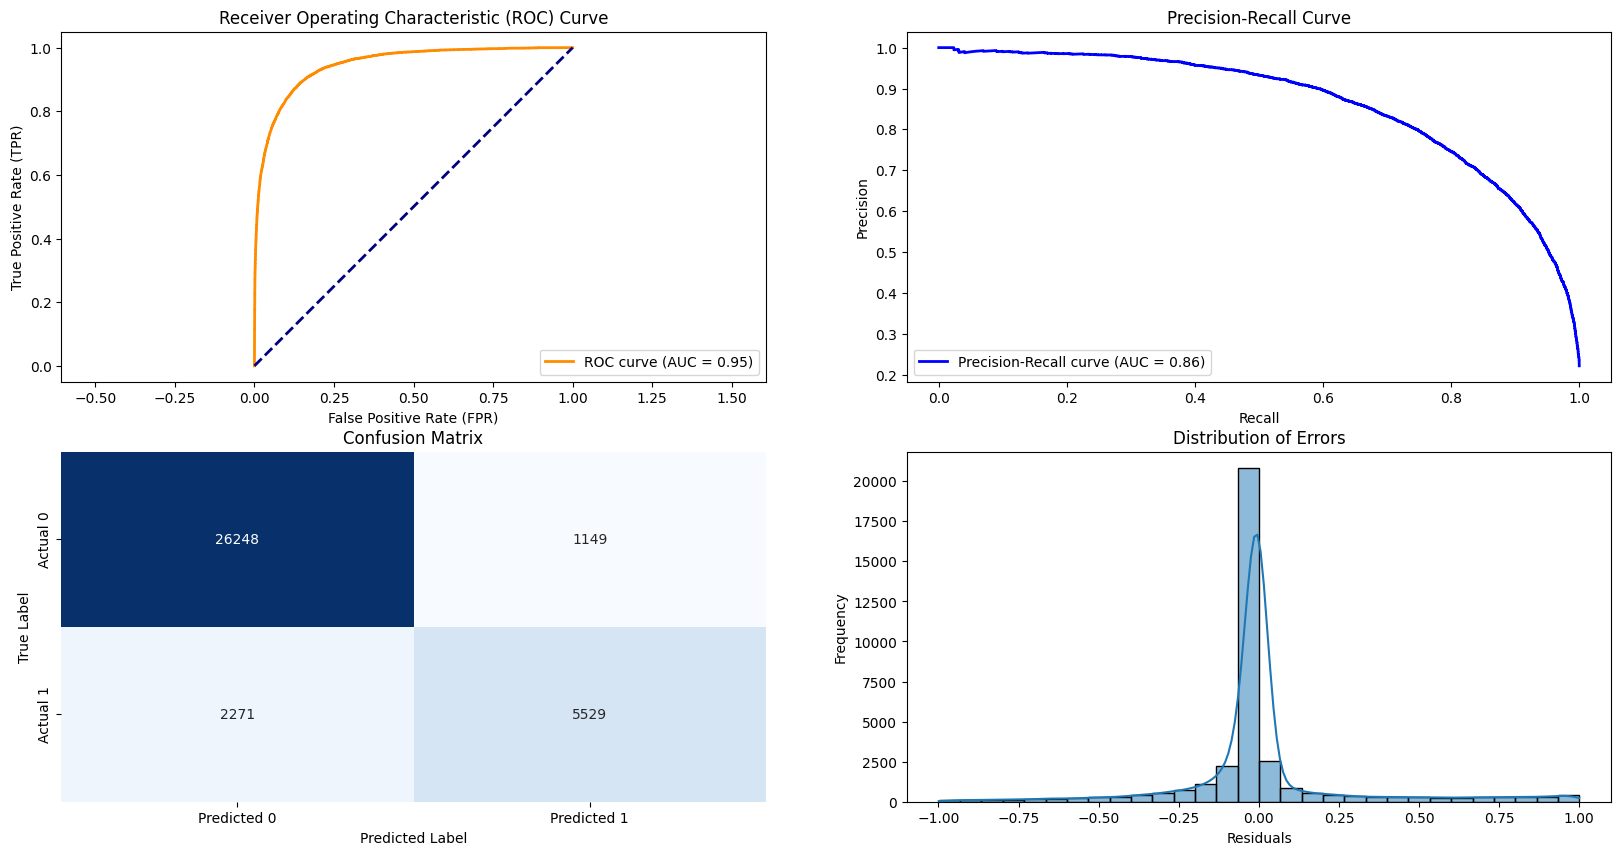

In [100]:
model = Model(best_model_lgb, 
              name='LightGBM No Resample', scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [101]:
metrics_lgb_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_lgb_no_resample.to_frame().T])
print(metrics_lgb_no_resample)

Accuracy                                 0.902833
Precision                                0.827942
Recall                                   0.708846
F1-Score                                  0.76378
ROC AUC                                  0.945983
Confusion Matrix    [[26248, 1149], [2271, 5529]]
PR AUC                                   0.862739
Name                         LightGBM No Resample
dtype: object


### SMOTE

In [ ]:

model = lgb.LGBMClassifier(objective="binary")


param_distributions = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [6, 8, 10, 12],
    'num_leaves': [20, 31, 40, 50],
    'min_child_samples': [20, 30, 40],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}


random_search = RandomizedSearchCV(model, param_distributions, n_iter=50, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42)

random_search.fit(X_train_smote_scaled, y_train_smote)

best_model_lgb = random_search.best_estimator_

[LightGBM] [Info] Number of positive: 82189, number of negative: 82189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3652
[LightGBM] [Info] Number of data points in the train set: 164378, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

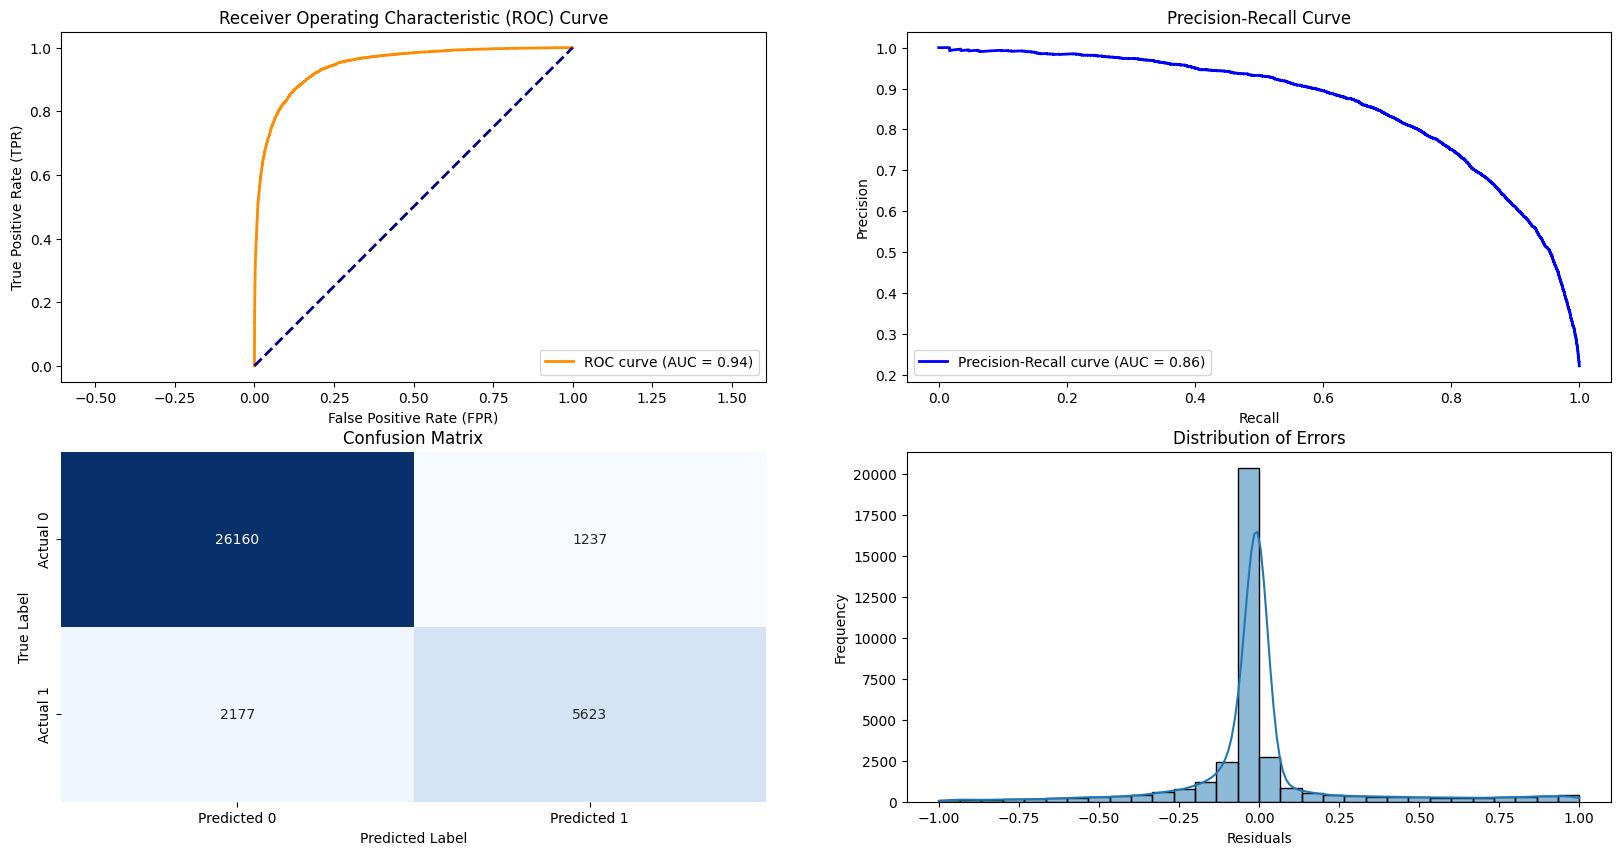

In [103]:
model = Model(best_model_lgb, 
              name='Ligth GBM SMOTE', scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [104]:
metrics_lgb_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_lgb_smote.to_frame().T])
print(metrics_lgb_smote)

Accuracy                                 0.903003
Precision                                0.819679
Recall                                   0.720897
F1-Score                                 0.767121
ROC AUC                                  0.944592
Confusion Matrix    [[26160, 1237], [2177, 5623]]
PR AUC                                   0.860947
Name                              Ligth GBM SMOTE
dtype: object


### Undersample

In [ ]:

model = lgb.LGBMClassifier(objective="binary")

param_distributions = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [6, 8, 10, 12],
    'num_leaves': [20, 31, 40, 50],
    'min_child_samples': [20, 30, 40],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

random_search = RandomizedSearchCV(model, param_distributions, n_iter=50, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42)

random_search.fit(X_train_under_scaled, y_train_under)

best_model_lgb = random_search.best_estimator_

[LightGBM] [Info] Number of positive: 23401, number of negative: 23401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3162
[LightGBM] [Info] Number of data points in the train set: 46802, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


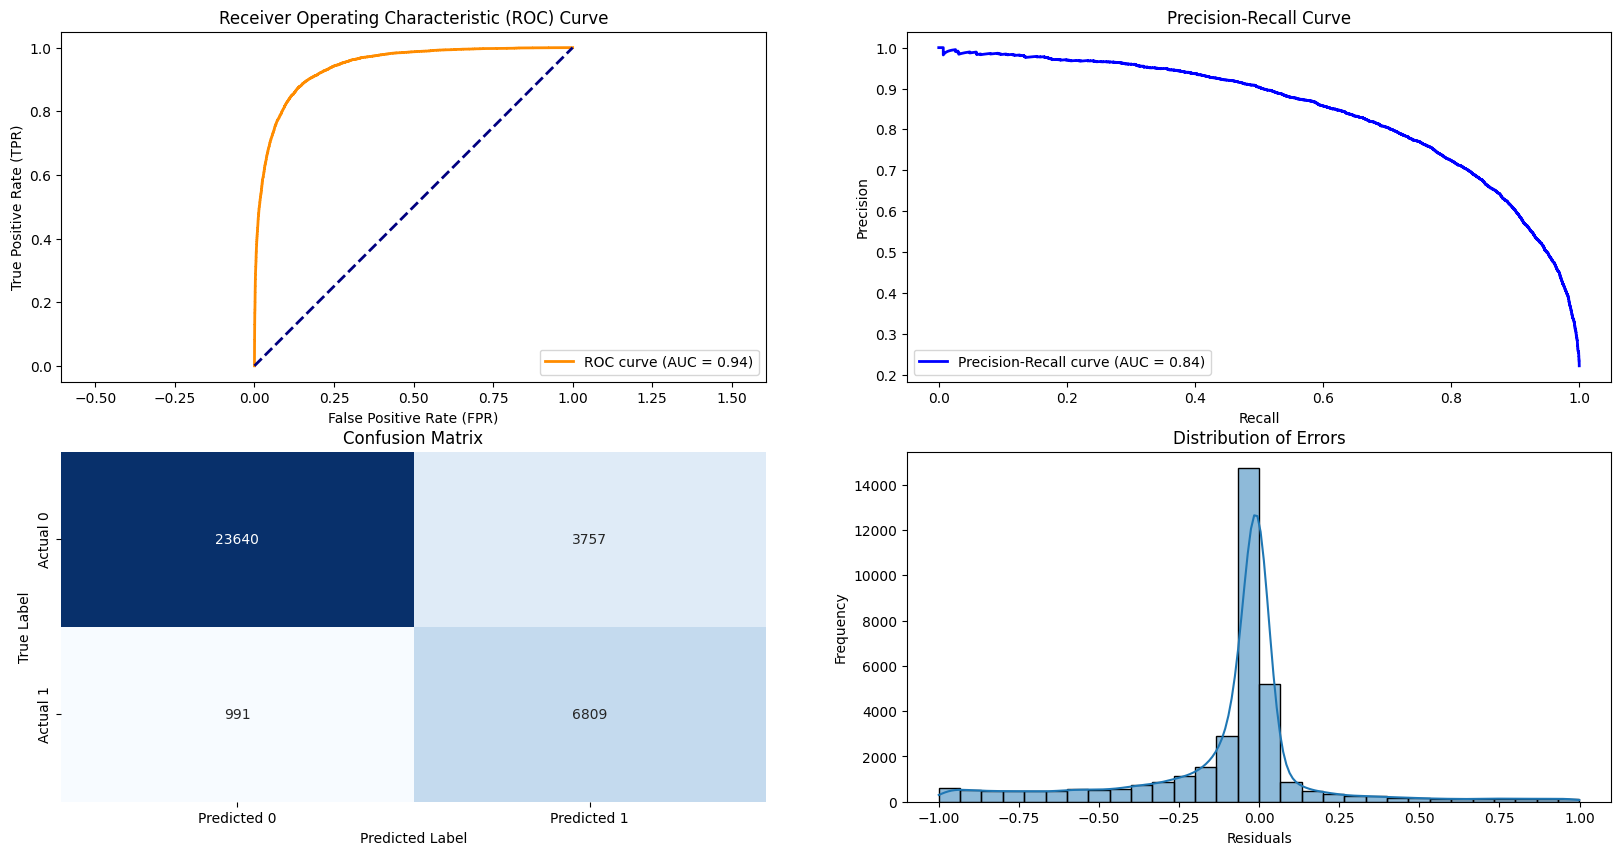

In [106]:
model = Model(best_model_lgb, 
              name='Ligth GBM Under', scaled=True, resample='under')
model.fit()
model.visualize_metrics()

In [107]:
metrics_lgb_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_lgb_under.to_frame().T])
print(metrics_lgb_under)

Accuracy                                0.865102
Precision                               0.644426
Recall                                  0.872949
F1-Score                                0.741479
ROC AUC                                 0.941053
Confusion Matrix    [[23640, 3757], [991, 6809]]
PR AUC                                  0.842778
Name                             Ligth GBM Under
dtype: object


## Neural Network

### No Resample

In [108]:
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Input(shape=[X_train.shape[1]]),
    BatchNormalization(), # normalises the activations of the previous layer, stabilising and accelerating training.
    Dense(128, activation='relu'),
    Dropout(0.3), # randomly deactivating 30% of the units during training to prevent overfitting.
    Dense(96, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'), 
    Dense(1, activation='sigmoid'),
])
optimizer = Adam(learning_rate=0.0001) # to minimize the loss function
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Model training
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    batch_size=100, # the number of samples to be used in each weight update
    epochs=400,
    shuffle = True, # mixes training data at each epoch
    callbacks=[early_stopping]
)

Epoch 1/400
1056/1056 [==============================] - 6s 4ms/step - loss: 0.4003 - binary_accuracy: 0.8188 - val_loss: 0.3416 - val_binary_accuracy: 0.8504
Epoch 2/400
1056/1056 [==============================] - 4s 4ms/step - loss: 0.3507 - binary_accuracy: 0.8475 - val_loss: 0.3299 - val_binary_accuracy: 0.8577
Epoch 3/400
1056/1056 [==============================] - 4s 4ms/step - loss: 0.3422 - binary_accuracy: 0.8517 - val_loss: 0.3257 - val_binary_accuracy: 0.8600
Epoch 4/400
1056/1056 [==============================] - 4s 4ms/step - loss: 0.3395 - binary_accuracy: 0.8516 - val_loss: 0.3233 - val_binary_accuracy: 0.8616
Epoch 5/400
1056/1056 [==============================] - 4s 4ms/step - loss: 0.3351 - binary_accuracy: 0.8542 - val_loss: 0.3209 - val_binary_accuracy: 0.8625
Epoch 6/400
1056/1056 [==============================] - 4s 4ms/step - loss: 0.3327 - binary_accuracy: 0.8552 - val_loss: 0.3194 - val_binary_accuracy: 0.8633
Epoch 7/400
1056/1056 [=======================

Best Validation Loss: 0.2113
Best Validation Accuracy: 0.9122


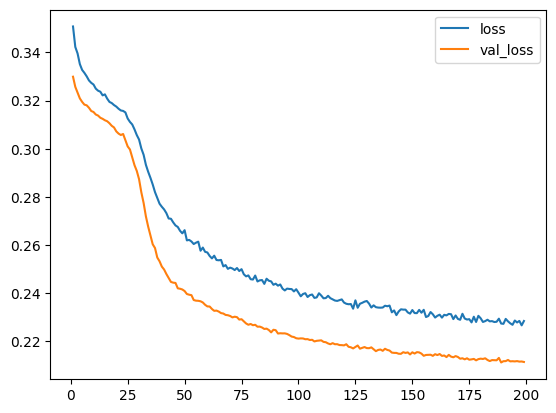

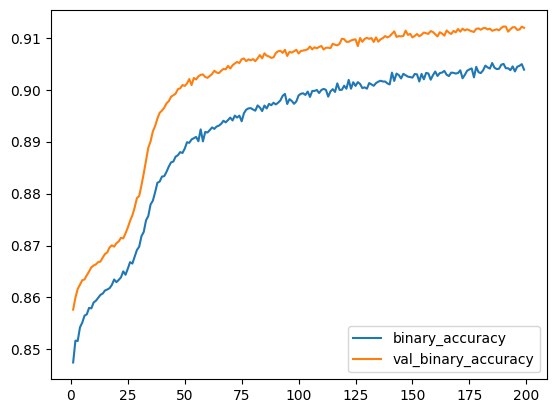

In [109]:
history_df = pd.DataFrame(history.history)

history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

In [110]:
y_pred_prob_test = model.predict(X_test_scaled)
y_pred_test = np.where(y_pred_prob_test.squeeze() < 0.5, 0, 1)
acc_test = metrics.accuracy_score(y_test, y_pred_test)
print(acc_test)

1100/1100 [==============================] - 2s 2ms/step
0.9118959002187687


In [111]:
accuracy = metrics.accuracy_score(y_test, y_pred_test)
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
f1 = metrics.f1_score(y_test, y_pred_test)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_test)
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
pr_auc = metrics.average_precision_score(y_test, y_pred_prob_test)
metrics_TF = pd.Series({
'Accuracy': accuracy,
'Precision': precision,
'Recall': recall,
'F1-Score': f1,
'ROC AUC': roc_auc,
'PR AUC': pr_auc,
'Confusion Matrix': conf_mat,
'Name':'NN No Resample'
})
print(metrics_TF)
models_df = pd.concat([models_df, metrics_TF.to_frame().T])

Accuracy                                 0.911896
Precision                                0.839082
Recall                                   0.745385
F1-Score                                 0.789463
ROC AUC                                   0.95663
PR AUC                                   0.887507
Confusion Matrix    [[26282, 1115], [1986, 5814]]
Name                               NN No Resample
dtype: object


## SMOTE

In [112]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    Input(shape=[X_train.shape[1]]),
    BatchNormalization(),
    Dense(256, activation='relu',  kernel_regularizer=l2(0.001)), # l2 in order to avoid instability
    Dropout(0.05),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.05),
    Dense(96, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'), 
    Dense(1, activation='sigmoid'),
])
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0) # clipnorm=1.0 is used to limit the size of the gradient.
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Model training
history = model.fit(
    X_train_smote_scaled, y_train_smote,
    validation_data=(X_test_smote_scaled, y_test),
    batch_size=1800,
    epochs=300,
    shuffle = True,
    callbacks=[early_stopping]
)

Epoch 1/300
92/92 [==============================] - 5s 27ms/step - loss: 0.9047 - binary_accuracy: 0.7010 - val_loss: 0.7892 - val_binary_accuracy: 0.7839
Epoch 2/300
92/92 [==============================] - 2s 24ms/step - loss: 0.7202 - binary_accuracy: 0.7966 - val_loss: 0.6787 - val_binary_accuracy: 0.8150
Epoch 3/300
92/92 [==============================] - 2s 25ms/step - loss: 0.6689 - binary_accuracy: 0.8084 - val_loss: 0.6463 - val_binary_accuracy: 0.8156
Epoch 4/300
92/92 [==============================] - 2s 25ms/step - loss: 0.6357 - binary_accuracy: 0.8153 - val_loss: 0.6383 - val_binary_accuracy: 0.8095
Epoch 5/300
92/92 [==============================] - 2s 24ms/step - loss: 0.6095 - binary_accuracy: 0.8186 - val_loss: 0.6022 - val_binary_accuracy: 0.8173
Epoch 6/300
92/92 [==============================] - 2s 26ms/step - loss: 0.5863 - binary_accuracy: 0.8222 - val_loss: 0.5917 - val_binary_accuracy: 0.8151
Epoch 7/300
92/92 [==============================] - 2s 23ms/ste

Best Validation Loss: 0.2930
Best Validation Accuracy: 0.8927


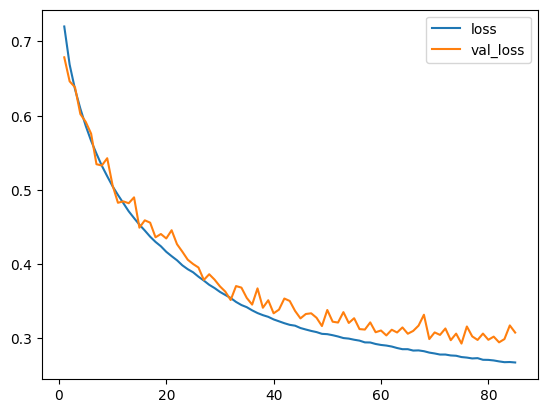

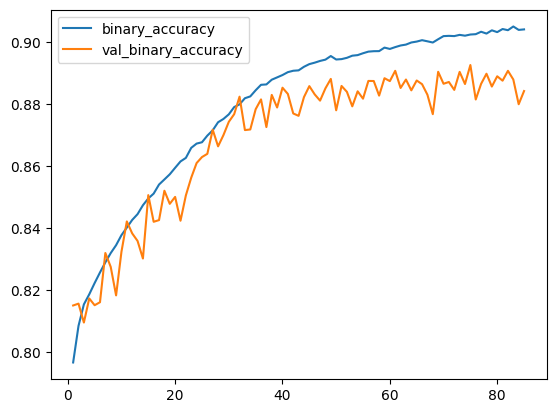

In [113]:
history_df = pd.DataFrame(history.history)

history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

In [114]:
y_pred_prob_test = model.predict(X_test_smote_scaled)
y_pred_test = np.where(y_pred_prob_test.squeeze() < 0.5, 0, 1)
acc_test = metrics.accuracy_score(y_test, y_pred_test)
print(acc_test)

1100/1100 [==============================] - 2s 2ms/step
0.8926897178736825


In [115]:
accuracy = metrics.accuracy_score(y_test, y_pred_test)
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
f1 = metrics.f1_score(y_test, y_pred_test)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_test)
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
pr_auc = metrics.average_precision_score(y_test, y_pred_prob_test)
metrics_TF = pd.Series({
'Accuracy': accuracy,
'Precision': precision,
'Recall': recall,
'F1-Score': f1,
'ROC AUC': roc_auc,
'PR AUC': pr_auc,
'Confusion Matrix': conf_mat,
'Name':'NN Smote'
})
print(metrics_TF)
models_df_smote = pd.concat([models_df_smote, metrics_TF.to_frame().T])

Accuracy                                  0.89269
Precision                                0.725884
Recall                                   0.828718
F1-Score                                   0.7739
ROC AUC                                  0.949539
PR AUC                                   0.867414
Confusion Matrix    [[24956, 2441], [1336, 6464]]
Name                                     NN Smote
dtype: object


## Undersample

In [116]:
model = Sequential([
    Input(shape=[X_train.shape[1]]),
    BatchNormalization(),
    Dense(96, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)), 
    Dropout(0.2),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1, activation='sigmoid'),
])
optimizer = Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Model training
history = model.fit(
    X_train_under_scaled, y_train_under,
    validation_data=(X_test_under_scaled, y_test),
    batch_size=100,
    epochs=200,
    callbacks=[early_stopping]
)

Epoch 1/200
469/469 [==============================] - 4s 5ms/step - loss: 0.6999 - binary_accuracy: 0.7380 - val_loss: 0.5993 - val_binary_accuracy: 0.7850
Epoch 2/200
469/469 [==============================] - 2s 4ms/step - loss: 0.6089 - binary_accuracy: 0.7859 - val_loss: 0.5784 - val_binary_accuracy: 0.7915
Epoch 3/200
469/469 [==============================] - 2s 4ms/step - loss: 0.5830 - binary_accuracy: 0.7942 - val_loss: 0.5628 - val_binary_accuracy: 0.7924
Epoch 4/200
469/469 [==============================] - 4s 8ms/step - loss: 0.5640 - binary_accuracy: 0.7980 - val_loss: 0.5349 - val_binary_accuracy: 0.7999
Epoch 5/200
469/469 [==============================] - 4s 9ms/step - loss: 0.5484 - binary_accuracy: 0.7999 - val_loss: 0.5340 - val_binary_accuracy: 0.7965
Epoch 6/200
469/469 [==============================] - 3s 6ms/step - loss: 0.5367 - binary_accuracy: 0.8017 - val_loss: 0.5223 - val_binary_accuracy: 0.7983
Epoch 7/200
469/469 [==============================] - 2s 

Best Validation Loss: 0.3450
Best Validation Accuracy: 0.8663


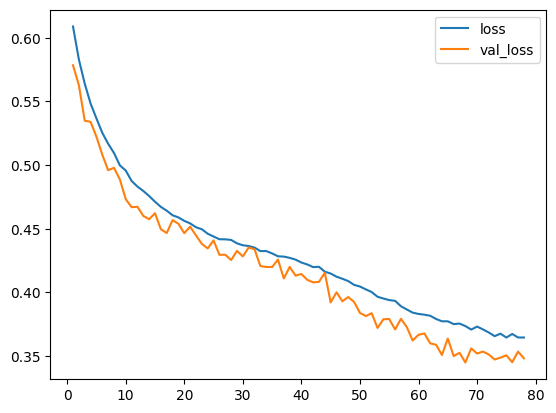

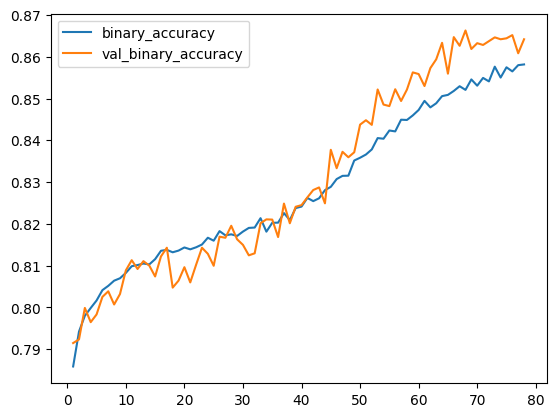

In [117]:
history_df = pd.DataFrame(history.history)

history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

In [118]:
y_pred_prob_test = model.predict(X_test_under_scaled)
y_pred_test = np.where(y_pred_prob_test.squeeze() < 0.5, 0, 1)
acc_test = metrics.accuracy_score(y_test, y_pred_test)
print(acc_test)

1100/1100 [==============================] - 2s 1ms/step
0.8662954229053612


In [119]:
accuracy = metrics.accuracy_score(y_test, y_pred_test)
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
f1 = metrics.f1_score(y_test, y_pred_test)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_test)
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
pr_auc = metrics.average_precision_score(y_test, y_pred_prob_test)
metrics_TF = pd.Series({
'Accuracy': accuracy,
'Precision': precision,
'Recall': recall,
'F1-Score': f1,
'ROC AUC': roc_auc,
'PR AUC': pr_auc,
'Confusion Matrix': conf_mat,
'Name':'NN Undersample'
})
print(metrics_TF)
models_df_under = pd.concat([models_df_under, metrics_TF.to_frame().T])

Accuracy                                 0.866295
Precision                                0.650282
Recall                                   0.858205
F1-Score                                 0.739914
ROC AUC                                  0.937069
PR AUC                                   0.833533
Confusion Matrix    [[23797, 3600], [1106, 6694]]
Name                               NN Undersample
dtype: object


# Conclusion
Now for each type of work (No Resample, SMOTE and Undersample) and for each metric we find the best method

## No Resample

In [120]:
models_df

Name  Accuracy Precision    Recall  F1-Score  \
0                  LDA No Resample    0.8578  0.719906  0.586538  0.646415   
0  Logistic Regression No Resample  0.859221  0.738634  0.564487  0.639924   
0                   DT No Resample  0.857971  0.729477  0.570769  0.640437   
0                   RF No Resample  0.885246  0.819976  0.617821  0.704687   
0                  KNN No Resample  0.855613  0.720117      0.57  0.636325   
0    Gradient Boosting No Resample  0.899991  0.816568  0.707692  0.758242   
0                  XGB No Resample  0.903969  0.833736  0.707821  0.765636   
0             CatBoost No Resample  0.900276  0.822945  0.700769  0.756959   
0             LightGBM No Resample  0.902833  0.827942  0.708846   0.76378   
0                   NN No Resample  0.911896  0.839082  0.745385  0.789463   

    ROC AUC               Confusion Matrix    PR AUC  
0  0.888577  [[25617, 1780], [3225, 4575]]  0.727093  
0  0.889739  [[25839, 1558], [3397, 4403]]  0.729967  
0   0.88525  [[25746, 1651], [3348, 4452]]  0.726767  
0  0.927123  [[26339, 1058], [2981, 4819]]  0.815329  
0  0.861607  [[25669, 1728], [3354, 4446]]  0.656541  
0   0.94288  [[26157, 1240], [2280, 5520]]  0.856161  
0   0.94877  [[26296, 1101], [2279, 5521]]    0.8683  
0  0.944194  [[26221, 1176], [2334, 5466]]  0.857553  
0  0.945983  [[26248, 1149], [2271, 5529]]  0.862739  
0   0.95663  [[26282, 1115], [1986, 5814]]  0.887507

In [121]:
models_df.index = models_df.Name
models_df = models_df.drop('Name',axis=1)

<Axes: xlabel='Name'>

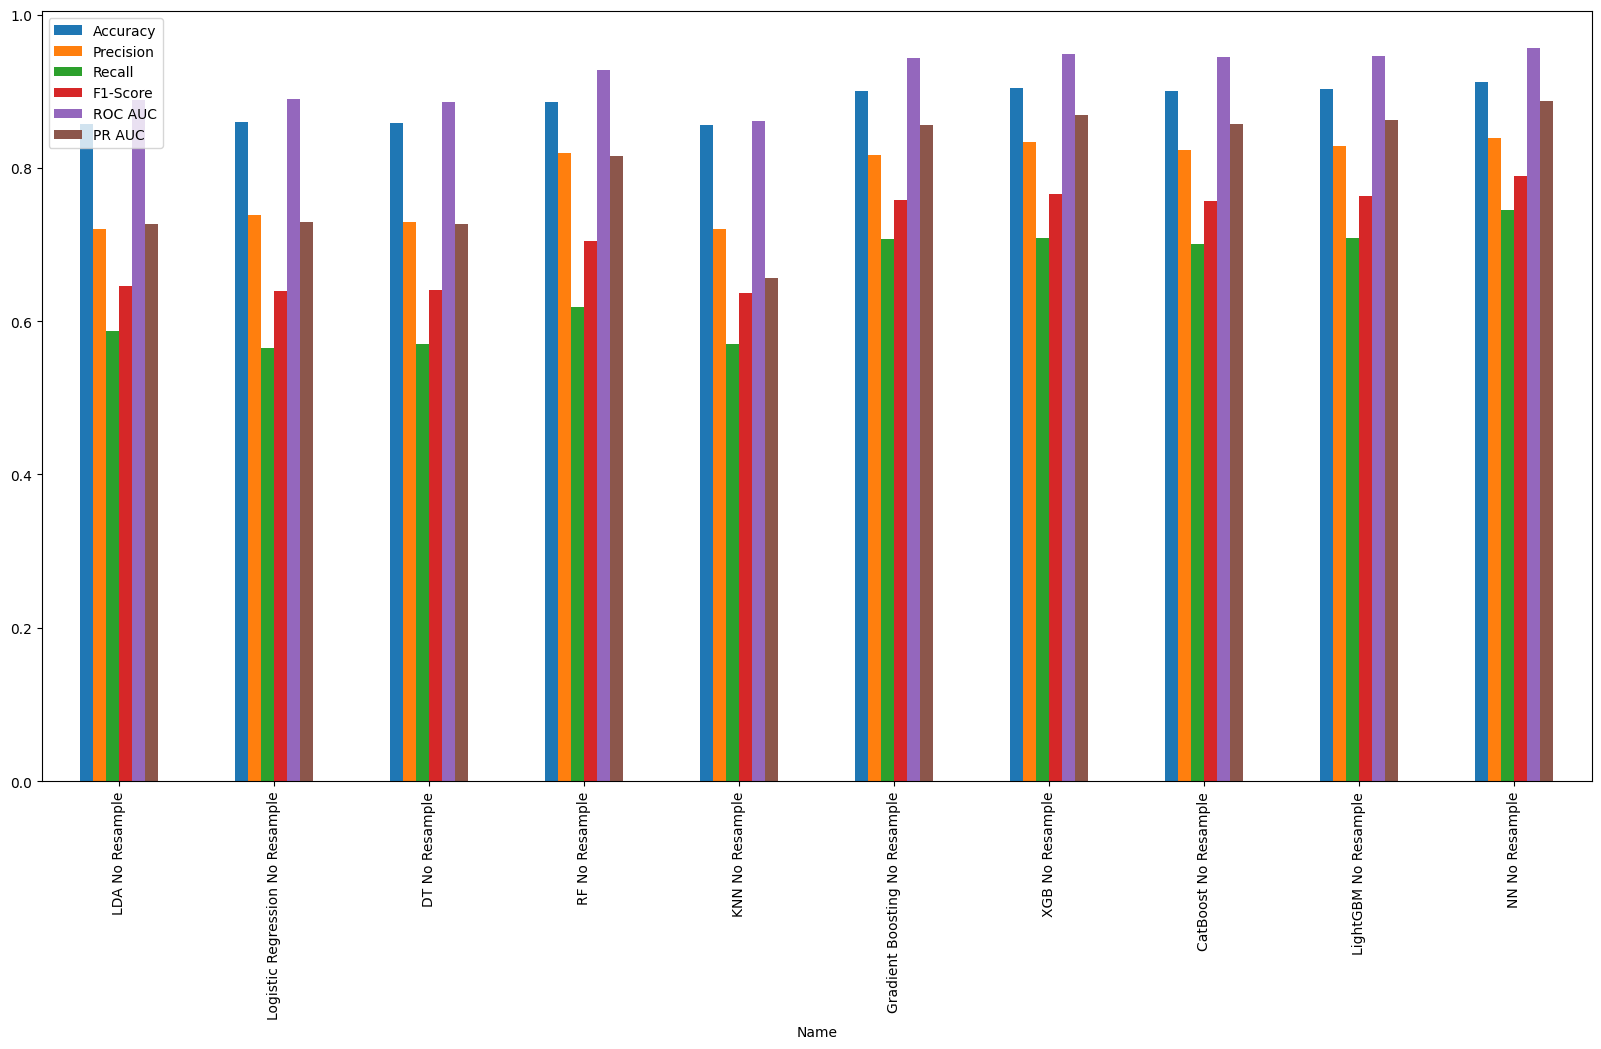

In [122]:
df = models_df[[x for x in models_df.columns if x != 'Confusion Matrix']]
df.plot.bar(figsize=(20,10))

In [123]:
best_values_no_resample = pd.DataFrame(columns=['Metric', 'Best Value', 'Method'])

for col in models_df.columns:
    if col != 'Confusion Matrix':
        best_value_row = models_df.sort_values(by=col, ascending=False).head(1)
        best_value = best_value_row[col].values[0]
        method_name = best_value_row.index[0]  
        new_row = pd.DataFrame({'Metric': [col], 'Best Value': [best_value], 'Method': [method_name]})
        best_values_no_resample = pd.concat([best_values_no_resample, new_row], ignore_index=True)

pd.DataFrame(best_values_no_resample)

Metric  Best Value          Method
0   Accuracy    0.911896  NN No Resample
1  Precision    0.839082  NN No Resample
2     Recall    0.745385  NN No Resample
3   F1-Score    0.789463  NN No Resample
4    ROC AUC    0.956630  NN No Resample
5     PR AUC    0.887507  NN No Resample

## SMOTE

In [124]:
models_df_smote

Name  Accuracy Precision    Recall  F1-Score  \
0                  LDA SMOTE  0.815638  0.559241  0.793333   0.65603   
0  Logistic Regression Smote   0.81166  0.551718  0.800769  0.653313   
0                   DT Smote  0.830952  0.599957  0.711795  0.651108   
0                   RF SMOTE  0.884791  0.746284  0.727436   0.73674   
0                  KNN SMOTE  0.800494  0.533826  0.787051  0.636166   
0    Gradient Boosting SMOTE  0.884933  0.761725  0.699615   0.72935   
0                  XGB Smote  0.902492  0.820235  0.717179  0.765253   
0             CatBoost SMOTE  0.897065  0.804846  0.706923  0.752713   
0            Ligth GBM SMOTE  0.903003  0.819679  0.720897  0.767121   
0                   NN Smote   0.89269  0.725884  0.828718    0.7739   

    ROC AUC               Confusion Matrix    PR AUC  
0   0.88886  [[22520, 4877], [1612, 6188]]  0.726089  
0  0.889469  [[22322, 5075], [1554, 6246]]  0.726918  
0  0.826855  [[23695, 3702], [2248, 5552]]  0.581907  
0  0.927299  [[25468, 1929], [2126, 5674]]  0.815562  
0  0.860175  [[22036, 5361], [1661, 6139]]   0.60457  
0  0.925584  [[25690, 1707], [2343, 5457]]  0.817516  
0  0.944331  [[26171, 1226], [2206, 5594]]  0.859232  
0  0.939834  [[26060, 1337], [2286, 5514]]  0.848513  
0  0.944592  [[26160, 1237], [2177, 5623]]  0.860947  
0  0.949539  [[24956, 2441], [1336, 6464]]  0.867414

In [125]:
models_df_smote.index = models_df_smote.Name
models_df_smote = models_df_smote.drop('Name',axis=1)

<Axes: xlabel='Name'>

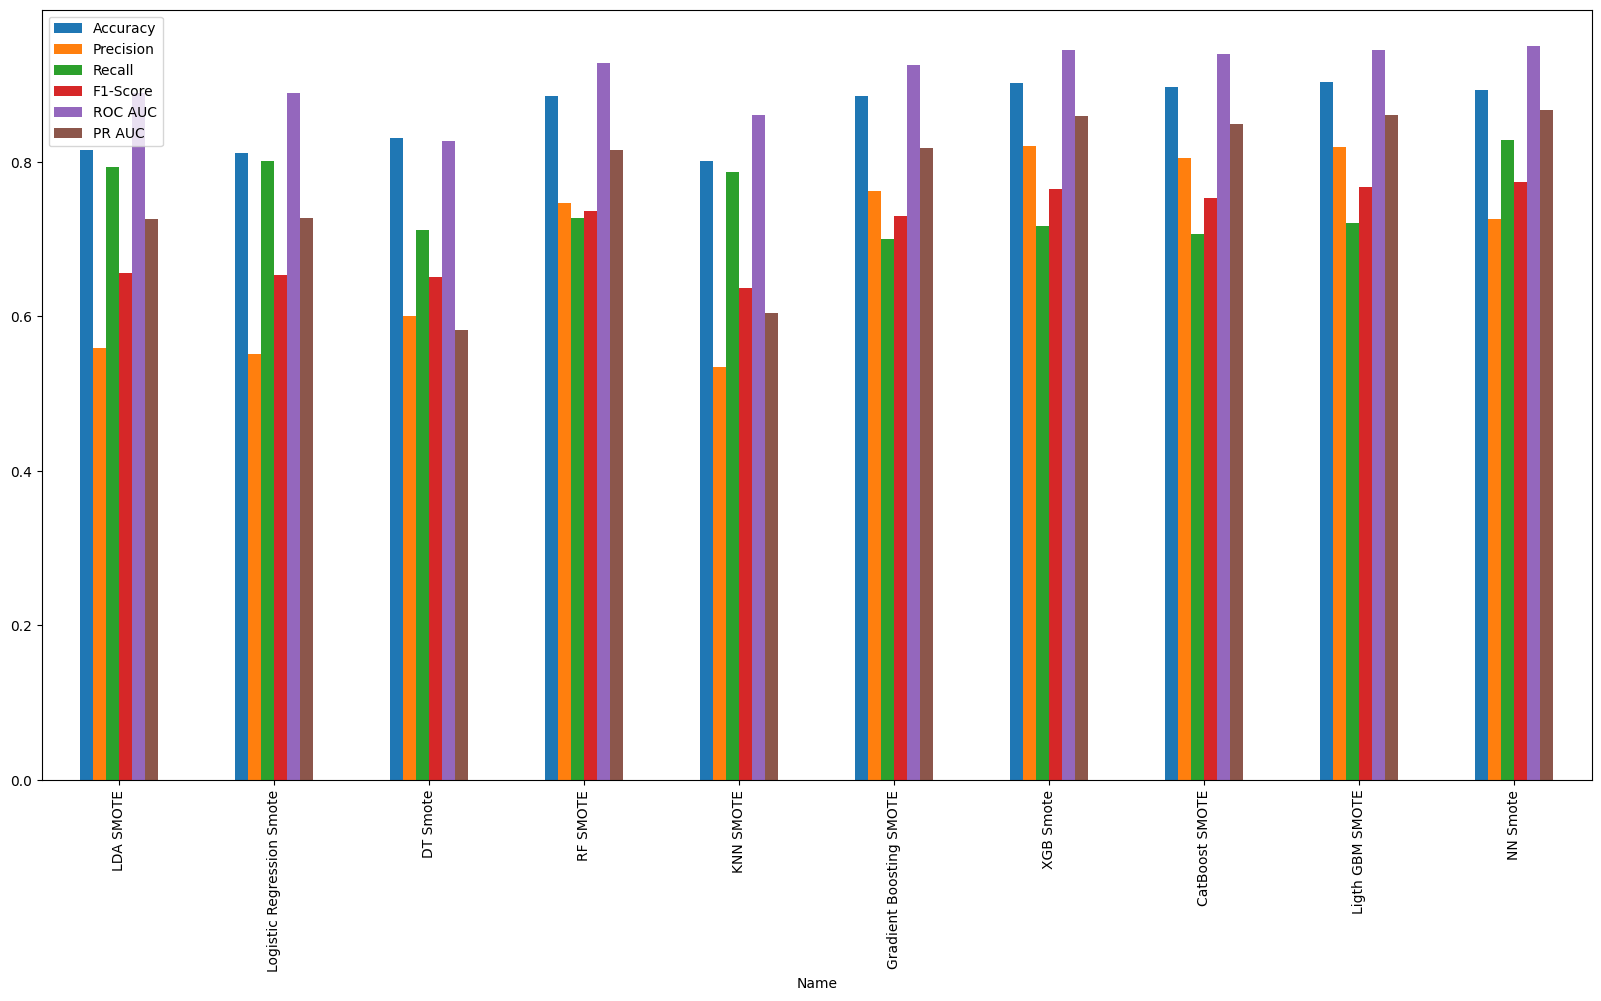

In [126]:
df_smote = models_df_smote[[x for x in models_df_smote.columns if x != 'Confusion Matrix']]
df_smote.plot.bar(figsize=(20,10))

In [127]:
best_values_smote = pd.DataFrame(columns=['Metric', 'Best Value', 'Method'])

for col in models_df_smote.columns:
    if col != 'Confusion Matrix':
        best_value_row = models_df_smote.sort_values(by=col, ascending=False).head(1)
        best_value = best_value_row[col].values[0]
        method_name = best_value_row.index[0]  
        new_row = pd.DataFrame({'Metric': [col], 'Best Value': [best_value], 'Method': [method_name]})
        best_values_smote = pd.concat([best_values_smote, new_row], ignore_index=True)

pd.DataFrame(best_values_smote)

Metric  Best Value           Method
0   Accuracy    0.903003  Ligth GBM SMOTE
1  Precision    0.820235        XGB Smote
2     Recall    0.828718         NN Smote
3   F1-Score    0.773900         NN Smote
4    ROC AUC    0.949539         NN Smote
5     PR AUC    0.867414         NN Smote

## Undersample

In [128]:
models_df_under

Name  Accuracy Precision    Recall  F1-Score  \
0                  LDA undersample  0.815354  0.558757  0.793077  0.655609   
0  Logistic Regression Undersample  0.811433  0.551301  0.801154  0.653149   
0                   DT Undersample    0.8045  0.539257  0.809231  0.647219   
0                   RF Undersample  0.842543  0.603275  0.845513  0.704143   
0                  KNN Undersample  0.796545  0.526865  0.803333  0.636368   
0    Gradient Boosting Undersample  0.861863  0.638794  0.866795  0.735531   
0                  XGB Undersample  0.864505  0.643093  0.873205  0.740688   
0             CatBoost Undersample  0.862261  0.638905  0.870385  0.736894   
0                  Ligth GBM Under  0.865102  0.644426  0.872949  0.741479   
0                   NN Undersample  0.866295  0.650282  0.858205  0.739914   

    ROC AUC               Confusion Matrix    PR AUC  
0  0.889342  [[22512, 4885], [1614, 6186]]  0.727967  
0  0.889934  [[22311, 5086], [1551, 6249]]   0.72871  
0  0.883556  [[22004, 5393], [1488, 6312]]  0.692408  
0  0.923195  [[23060, 4337], [1205, 6595]]  0.798911  
0  0.866511  [[21770, 5627], [1534, 6266]]  0.614456  
0  0.938293  [[23574, 3823], [1039, 6761]]  0.835885  
0  0.942543   [[23617, 3780], [989, 6811]]  0.845877  
0  0.939948  [[23560, 3837], [1011, 6789]]  0.837157  
0  0.941053   [[23640, 3757], [991, 6809]]  0.842778  
0  0.937069  [[23797, 3600], [1106, 6694]]  0.833533

In [129]:
models_df_under.index = models_df_under.Name
models_df_under = models_df_under.drop('Name',axis=1)

<Axes: xlabel='Name'>

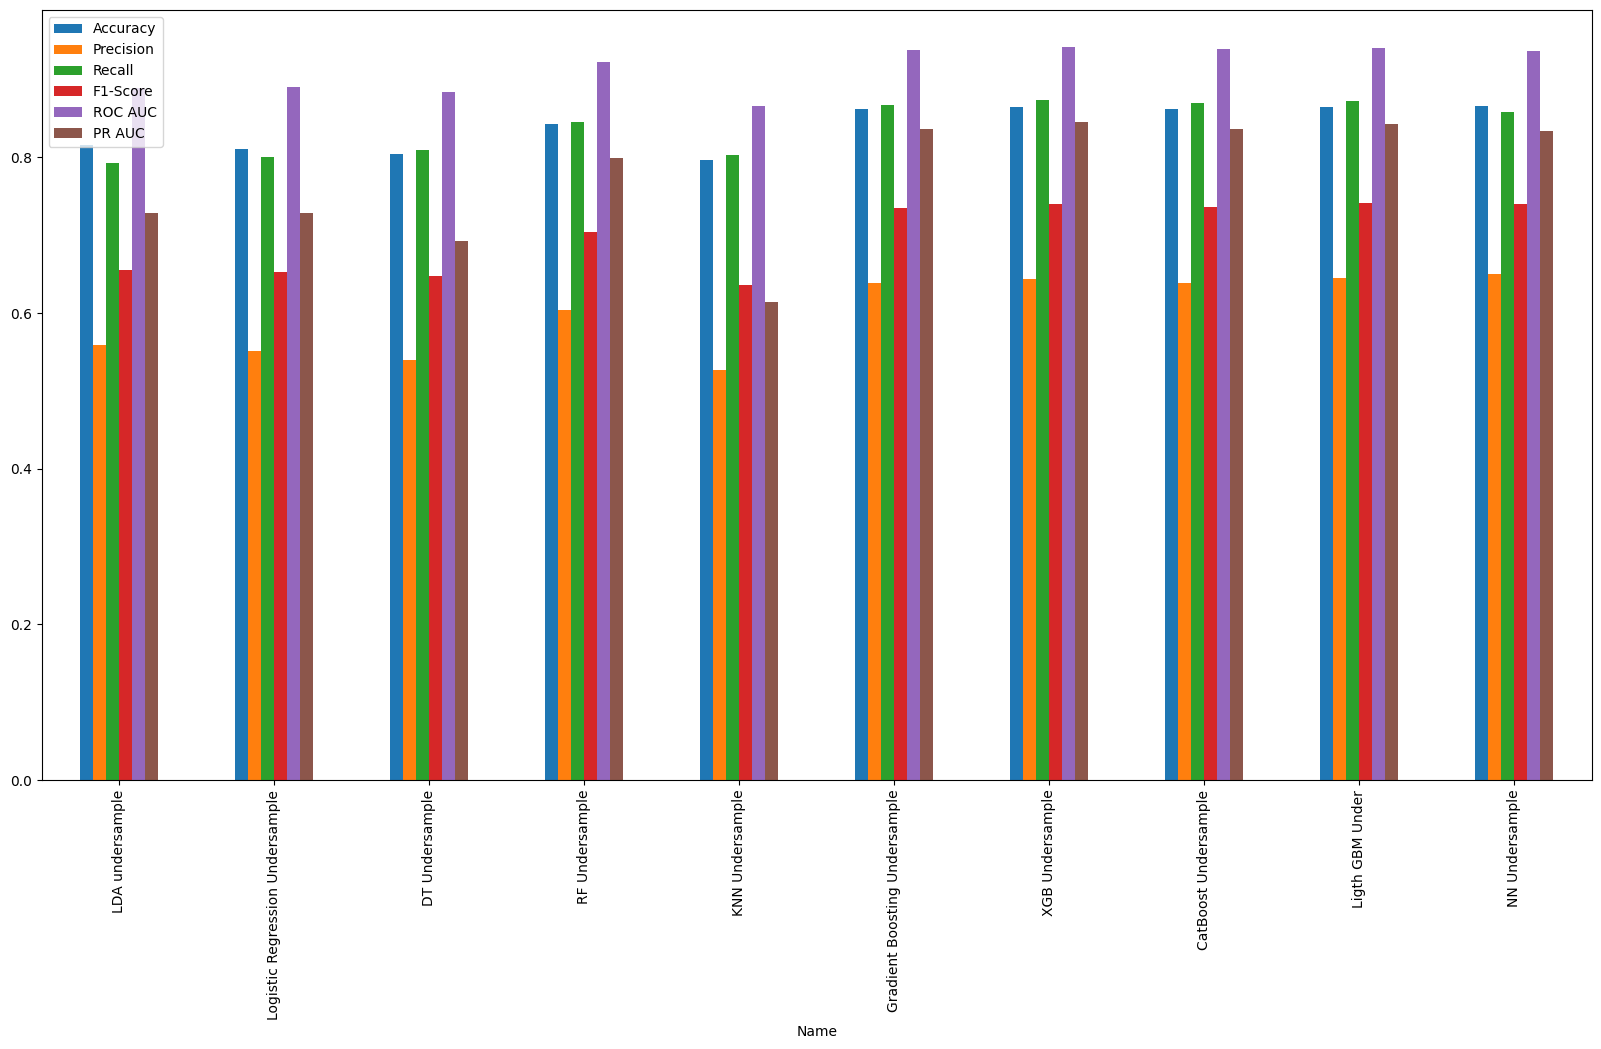

In [130]:
df_under = models_df_under[[x for x in models_df_under.columns if x != 'Confusion Matrix']]
df_under.plot.bar(figsize=(20,10))

In [131]:
best_values_under = pd.DataFrame(columns=['Metric', 'Best Value', 'Method'])

for col in models_df_under.columns:
    if col != 'Confusion Matrix':
        best_value_row = models_df_under.sort_values(by=col, ascending=False).head(1)
        best_value = best_value_row[col].values[0]
        method_name = best_value_row.index[0]  
        new_row = pd.DataFrame({'Metric': [col], 'Best Value': [best_value], 'Method': [method_name]})
        best_values_under = pd.concat([best_values_under, new_row], ignore_index=True)

pd.DataFrame(best_values_under)


Metric  Best Value           Method
0   Accuracy    0.866295   NN Undersample
1  Precision    0.650282   NN Undersample
2     Recall    0.873205  XGB Undersample
3   F1-Score    0.741479  Ligth GBM Under
4    ROC AUC    0.942543  XGB Undersample
5     PR AUC    0.845877  XGB Undersample

## Best method for each metrics
We can establish, for each metric, the best method among all runned. So, here I merged the three datasets and I don't make any differences between the three type of approach (No Resample, SMOTE, Undersample).

In [132]:

all_best_values = pd.concat([best_values_no_resample,
                             best_values_smote,
                             best_values_under],
                            ignore_index=True)

best_method_per_metric = all_best_values.loc[all_best_values.groupby('Metric')['Best Value'].idxmax()]

pd.DataFrame(best_method_per_metric)


Metric  Best Value           Method
0    Accuracy    0.911896   NN No Resample
3    F1-Score    0.789463   NN No Resample
5      PR AUC    0.887507   NN No Resample
1   Precision    0.839082   NN No Resample
4     ROC AUC    0.956630   NN No Resample
14     Recall    0.873205  XGB Undersample

## Comparison of metrics for different sampling methods
For each metrics and for each sampling methods, I calculated the average score.

In [133]:
recall_mean = [models_df['Recall'].mean(), models_df_smote['Recall'].mean(), models_df_under['Recall'].mean()]
precision_mean = [models_df['Precision'].mean(), models_df_smote['Precision'].mean(), models_df_under['Precision'].mean()]
pr_auc_mean = [models_df['PR AUC'].mean(), models_df_smote['PR AUC'].mean(), models_df_under['PR AUC'].mean()]
accuracy_mean = [models_df['Accuracy'].mean(), models_df_smote['Accuracy'].mean(), models_df_under['Accuracy'].mean()]
f1_mean = [models_df['F1-Score'].mean(), models_df_smote['F1-Score'].mean(), models_df_under['F1-Score'].mean()]

metrics_df = pd.DataFrame({
    'Method': ['Original', 'SMOTE', 'Under-sampling'],
    'Accuracy': accuracy_mean,
    'Recall': recall_mean,
    'Precision': precision_mean,
    'F1-Score': f1_mean,
    'PR AUC': pr_auc_mean
})

metrics_df

Method  Accuracy    Recall  Precision  F1-Score    PR AUC
0        Original  0.883482  0.648013   0.786838  0.710187  0.798796
1           SMOTE  0.862372  0.749372   0.692340  0.712169  0.770867
2  Under-sampling  0.839040  0.839385   0.599495  0.699099  0.775768

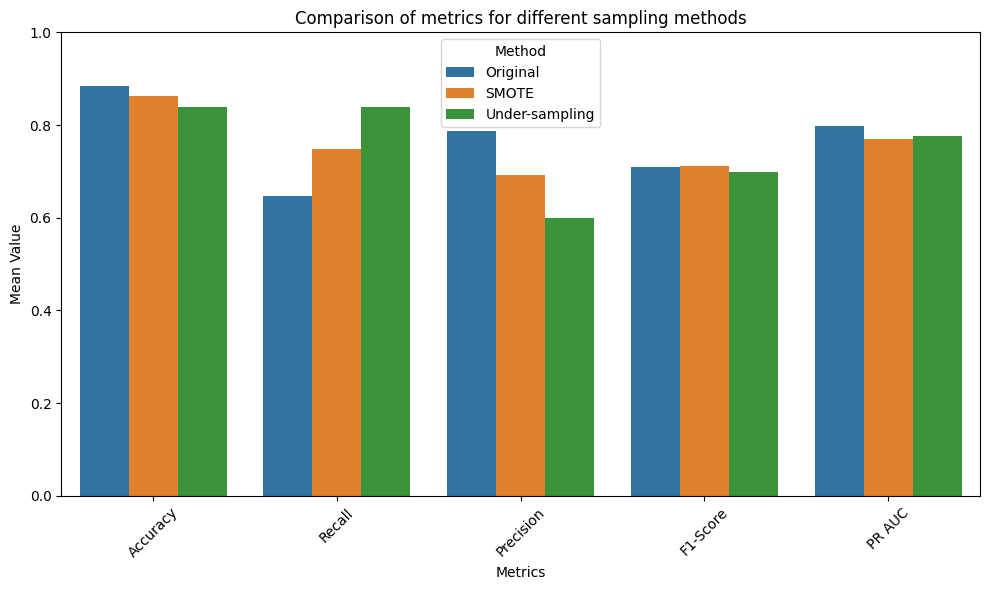

In [134]:

metrics_long_df = metrics_df.melt(id_vars='Method', var_name='Metric', value_name='Value')


plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', hue='Method', data=metrics_long_df)


plt.title('Comparison of metrics for different sampling methods')
plt.ylabel('Mean Value')
plt.xlabel('Metrics')
plt.ylim(0, 1) 
plt.legend(title='Method')
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

In the latter graph, it can be seen that, on average, the dataset to which no rebalancing technique was applied has a significantly lower recall score. Similarly, it is possible to note the trade-off between precision and recall. 

By adopting the SMOTE and Undersample techniques, the recall score increases, which leads to an increase in true positives (TP), but may also increase false positives (FP). In fact, it is the latter that causes the precision value to decrease.


Consequently, if more weight is to be given to false negatives (FN) in the prediction work, then the SMOTE and Undersample methods perform better than the original dataset.

In this case study, we are performing rain prediction, so we have to consider which scenario produces the highest cost:
 - The cost of identifying a rainy day as a non-rainy day (**False Negative**)
 
 - The cost of identifying a non-rainy day as a rainy day (**False Positive**)

In my opinion, I think that, the cost of **FN** is higher than the cost of **FP**. Referring back to the definition of precision and recall we have the following aspect:
$$min(FP) \implies max(Precision)$$
$$min(FN) \implies max(Recall)$$
For this reason, it is better to minimize the FN score, indeed maximize the recall score. So, this might to choose the **Undersampling** approach, which on average produces the biggest value of recall score.